In [1]:
from allensdk.brain_observatory.ecephys.dynamic_gating_ecephys_session import DynamicGatingEcephysSession

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import scipy.signal
import matplotlib as mpl
import os
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
import ccf_utils
import analysis_utils

%load_ext autoreload
%autoreload 2

In [7]:
structure_tree = pd.read_csv(r"..\ccf_structure_tree_2017.csv")

In [6]:
#This directory was created and populated by ../batch_processing/run_4Hz_bursts.py 
burst_data_dir = r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\all_areas_using_minima_125window'

#This dir contains ccgs, burst times and burst triggered behavior traces for each session. Its populated by ../batch_processing/run_4Hz_analysis
data_dir = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\session_analysis"

In [8]:
def triggered_average(timeseries, timestamps, alignment_times, time_before, time_after):

    aligned = []
    for al in alignment_times:
        start = al - time_before
        end = al + time_after
        aligned_trial = timeseries[(timestamps>=start)&(timestamps<end)]
        aligned.append(aligned_trial)
    
    return aligned

In [9]:
def load_numpy_data(glob_pattern):
    files = glob.glob(glob_pattern)
    file_data = []
    for f in files:
        data = np.load(f, allow_pickle=True)

        if '_running_triggered' in glob_pattern or 'pupil' in glob_pattern:
            if isinstance(data[0], pd.core.series.Series):
                data = [rr for rr in data if len(rr)>0]
                data = [rr.values for rr in data]
            data = np.array(data)
        
        file_data.append(data)
    return file_data

In [10]:
#Load metadata tables
master_stim = pd.read_csv(r"..\..\metadata_tables\master_stim_trials_table.csv")
units_rf = pd.read_csv(r"..\..\metadata_tables\units_with_rf_metrics.csv")
master_channels_table = pd.read_csv(r"..\..\metadata_tables\\channels_table.csv")
units_with_rf = units_rf.merge(master_channels_table, left_on='peak_channel_id', right_on='id', suffixes=[None, '_channel'])

In [19]:
all_burst_areas = glob.glob(os.path.join(burst_data_dir, '*_burst_times.npy'))
all_burst_areas = np.unique([os.path.basename(f).split('_')[1] for f in all_burst_areas])

sessions = os.listdir(data_dir)
# ccg_dict = {area: {} for area in all_burst_areas}

# session = sessions[0]

# session_hists = glob.glob(os.path.join(data_dir, session, '*_burst_time_session_histogram.npy'))
# pupil = load_numpy_data(os.path.join(data_dir, '*', 'VISp' + '_pupil_triggered_average.npy'))
# len(pupil)
# ccg_files = glob.glob(os.path.join(data_dir, '*', 'VISp' + '_' + 'VISp' + '_ccgs.npy'))
# len(ccg_files)


In [115]:
session_dir = os.path.join(data_dir, session)
session_areas = glob.glob(os.path.join(session_dir, '*_burst_times.npy'))
session_areas = np.unique([os.path.basename(f).split('_')[0] for f in session_areas])
area = 'VISp'
area2 = 'ORBm'
ccg_file = os.path.join(session_dir, f'{area}_{area2}_ccgs.npy')
ccgs = np.load(ccg_file)
ccgs.shape

(27, 200)

In [20]:
#Load burst-related data for each session
session_data = {s: {'ccgs': {}, 'random_ccgs': {}, 'pupil': {}, 'running': {}, 
                    'pupil_random': {}, 'running_random': {}, 
                    'behavior_hists': {}, 'passive_hists': {}, 
                    'psths': {}, 'rand_psths': {}} for s in sessions}
for session in sessions:

    session_dir = os.path.join(data_dir, session)
    session_areas = glob.glob(os.path.join(session_dir, '*_burst_times.npy'))
    session_burst_areas = np.unique([os.path.basename(f).split('_')[0] for f in session_areas])
    session_recorded_areas = glob.glob(os.path.join(session_dir, '*ccgs.npy'))
    session_recorded_areas = np.unique([os.path.basename(f).split('_')[1] for f in session_recorded_areas])

    session_dict = session_data[session]
    for area in session_burst_areas:
        pupil = load_numpy_data(os.path.join(session_dir, area + '_pupil_triggered_average.npy'))
        running = load_numpy_data(os.path.join(session_dir, area + '_running_triggered_average.npy'))
        pupil_rand = load_numpy_data(os.path.join(session_dir, area + '_pupil_triggered_average_random.npy'))
        running_rand = load_numpy_data(os.path.join(session_dir, area + '_running_triggered_average_random.npy'))
        session_dict['pupil'][area] = pupil
        session_dict['running'][area] = running
        session_dict['pupil_random'][area] = pupil_rand
        session_dict['running_random'][area] = running_rand
        session_dict['ccgs'][area] = {}
        session_dict['random_ccgs'][area] = {}
        session_dict['psths'][area] = {}
        session_dict['rand_psths'][area] = {}
        for area2 in session_recorded_areas:
            ccg_file = os.path.join(session_dir, f'{area}_{area2}_ccgs.npy')
            session_dict['ccgs'][area][area2] = np.load(ccg_file)

            rand_ccg_file = os.path.join(session_dir, f'{area}_{area2}_ccgs_random.npy')
            session_dict['random_ccgs'][area][area2] = np.load(rand_ccg_file)

            if area in ['VISp', 'MOp']:
                psth_file = os.path.join(session_dir, f'{area}_{area2}_psths.npy')
                session_dict['psths'][area][area2] = np.load(psth_file)

                rand_psth_file = os.path.join(session_dir, f'{area}_{area2}_psths_random.npy')
                session_dict['rand_psths'][area][area2] = np.load(rand_psth_file)


    for area in session_burst_areas:
        session_hists = load_numpy_data(os.path.join(session_dir, area + '_burst_time_session_histogram.npy'))
        session_hist_bins = load_numpy_data(os.path.join(session_dir, area + '_burst_time_session_histogram_bins.npy'))
        behavior_start = 0
        behavior_end = 3900
        behavior_hists = []
        passive_hists = []
        for hist, bins in zip(session_hists, session_hist_bins):

            behavior_start_bin = np.searchsorted(bins, behavior_start)
            behavior_end_bin = np.searchsorted(bins, behavior_end)

            behavior_hist = hist[behavior_start_bin:behavior_end_bin]
            behavior_hists.append(behavior_hist)

            if min(bins)<-1000:
                passive_start = -1500
                passive_end = 0
            else:
                passive_start = behavior_end
                passive_end = behavior_end + 1500
            
            passive_start_bin = np.searchsorted(bins, passive_start)
            passive_end_bin = passive_start_bin+24

            passive_hist = hist[passive_start_bin:passive_end_bin]

            passive_hists.append(passive_hist)
        behavior_hists = np.array([b[:64] for b in behavior_hists])
        passive_hists = np.array([p[:24] for p in passive_hists])
        session_dict['behavior_hists'][area] = behavior_hists
        session_dict['passive_hists'][area] = passive_hists


C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\2051970125.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [21]:
from lfp_filters import butter_bandpass_filter

def get_session_data_sessions_for_area(session_data, area):
    sessions = []
    for session, session_dict in session_data.items():
        if area in session_dict['ccgs']:
            sessions.append(session)
    return sessions

def get_areas_recorded_during_session(session_id):
    recorded_areas = glob.glob(os.path.join(data_dir, session_id, '*_ccgs.npy'))
    recorded_areas = np.unique([os.path.basename(f).split('_')[1] for f in recorded_areas])
    return recorded_areas

def get_qualifying_autoccgs(ccgs, threshold):
    butter_peaks = []
    for ccg in ccgs:
        butter = butter_bandpass_filter(ccg, 100, 3, 7, order=2)
        butter_sqr = butter**2
        #ax.plot(butter_sqr)
        butter_peaks.append(max(butter_sqr))

    butter_peaks = np.array(butter_peaks)
    return butter_peaks>threshold
    

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['qualifying'] = good_traces[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

VISp: num sessions 50 num events 1653


C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['qualifying'] = good_traces[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\1974889607.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

MOp: num sessions 14 num events 113


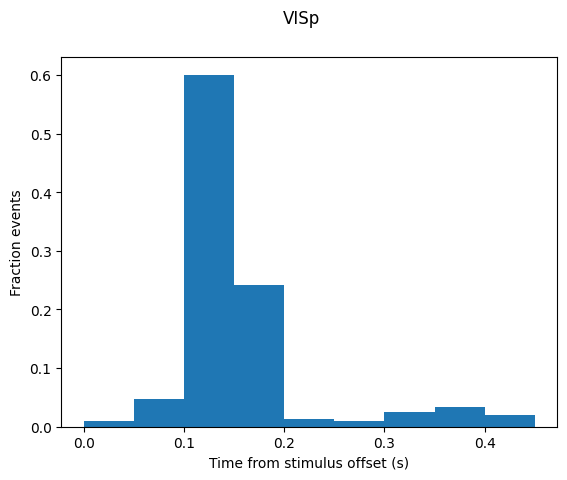

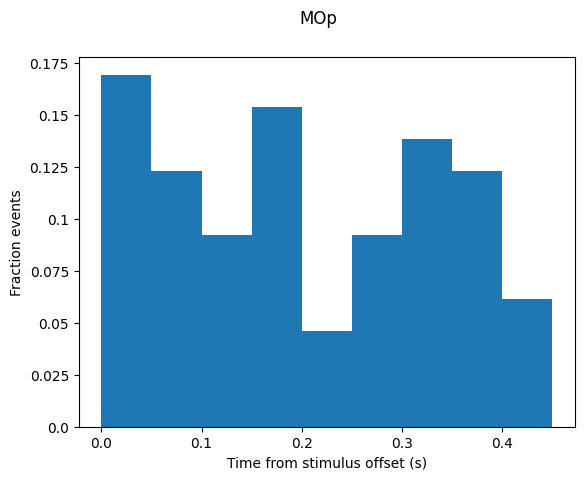

In [22]:
# Plot Histogram of alpha event times relative to stimulus offset
for region in ['VISp', 'MOp']:
    burst_times_relative_to_stim_end = []
    for session_id in sessions:
        session_dir = os.path.join(data_dir, session_id)
        session_areas = glob.glob(os.path.join(session_dir, '*_burst_times.npy'))
        session_burst_areas = np.unique([os.path.basename(f).split('_')[0] for f in session_areas])

        if region in session_burst_areas:
            session_burst_times = np.load(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\session_analysis',
                                            session_id, f'{region}_burst_times.npy'))
            sess_ccgs = session_data[session_id]['ccgs'][region][region]
            good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)

            session_stim = master_stim[master_stim['session_id']==int(session_id)].sort_values(by='start_time')
            inds_before_bursts = np.searchsorted(session_stim['start_time'].values, session_burst_times) - 1
            good_inds = (inds_before_bursts<len(session_stim))&(inds_before_bursts>-1)
            session_stims_before_bursts = session_stim.iloc[inds_before_bursts[good_inds]]

            session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
            burst_tensor_inds = np.arange(len(session_burst_times))[good_inds]
            session_stims_before_bursts['qualifying'] = good_traces[good_inds]
            
            q = session_stims_before_bursts[session_stims_before_bursts['qualifying']]

            burst_times_relative_to_stim_end.append(q['burst_time'] - q['end_time'])
    
    fig, ax = plt.subplots()
    fig.suptitle(region)
    all_diffs = [b for sub in burst_times_relative_to_stim_end for b in sub]
    print(f'{region}: num sessions {len(burst_times_relative_to_stim_end)} num events {len(all_diffs)}')
    ax.hist(all_diffs, bins=np.arange(0, 0.5, 0.05), density=True)
    yticks = ax.get_yticks()
    ax.set_yticklabels(np.round(yticks*0.05, 3))
    ax.set_xlabel('Time from stimulus offset (s)')
    ax.set_ylabel('Fraction events')
    #fig.savefig(f'{region}_events_relative_to_stim_offset_histogram.pdf')


In [23]:
#Get pupil and running data for alpha events and random session times
areas_to_plot = ['VISp', 'MOp']

area_pupil = {a: [] for a in areas_to_plot}
area_running = {a: [] for a in areas_to_plot}
area_pupil_rand = {a: [] for a in areas_to_plot}
area_running_rand = {a: [] for a in areas_to_plot}
for area in areas_to_plot:
    running_triggered = []
    running_triggered_rand = []
    pupil_triggered = []
    pupil_triggered_rand = []
    area_sessions = get_session_data_sessions_for_area(session_data, area)
    for session in area_sessions:

        sess_ccgs = session_data[session]['ccgs'][area][area]
        good_ccgs = get_qualifying_autoccgs(sess_ccgs, 0.1)
        
        pupil = session_data[session]['pupil'][area][0]
        good_pupil = pupil[good_ccgs]

        pupil_rand = session_data[session]['pupil_random'][area][0]
        good_pupil_rand = pupil_rand[good_ccgs]

        pupil_triggered.append(good_pupil)
        pupil_triggered_rand.append(good_pupil_rand)
        
        running = session_data[session]['running'][area][0]
        good_running = running[good_ccgs[:len(running)]]
        
        running_rand = session_data[session]['running_random'][area][0]
        good_running_rand = running_rand[good_ccgs[:len(running_rand)]]
        
        if good_running.size>0:
            good_running = np.array([g for g in good_running])
            good_running_rand = np.array([g for g in good_running_rand])
            running_triggered.append(good_running)
            running_triggered_rand.append(good_running_rand)

    area_pupil[area] = np.array([p for p in pupil_triggered])
    area_running[area] = np.array([r for r in running_triggered])
    area_pupil_rand[area] = np.array([p for p in pupil_triggered_rand])
    area_running_rand[area] = np.array([r for r in running_triggered_rand])

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\2992861059.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_running = np.array([g for g in good_running])
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\2992861059.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_running_rand = np.array([g for g in good_running_rand])
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\2992861059.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with d

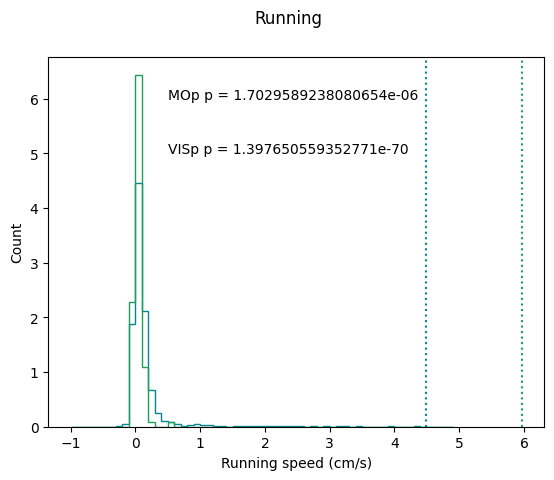

In [26]:
#Plot running speed for alpha vs random session times
colors = {'VISp': ccf_utils.get_area_color('VISp', structure_tree), 'MOp': ccf_utils.get_area_color('MOp', structure_tree)}

fig, ax = plt.subplots()
fig.suptitle('Running')
for ia, area in enumerate(['VISp', 'MOp']):

    running_means = []
    rand_running_means = []
    for running, running_rand in zip(area_running[area], area_running_rand[area]):

        session_running = np.array([p for p in running if p.size>999])
        session_rand_running = np.array([p for p in running_rand if p.size>999])

        if len(session_running)>0:
            peri_burst = np.mean(session_running[:, 500:600], axis=1)
            peri_rand = np.mean(session_rand_running[:, 500:600], axis=1)

            running_means.append(peri_burst)
            rand_running_means.append(peri_rand)

    
    running_flattened = [p for s in running_means for p in s]
    rand_running_flattened = [p for s in rand_running_means for p in s]

    ax.hist(running_flattened, bins=np.arange(-1, 5, 0.1), color=colors[area], density=True, histtype='step')
    #ax.hist(rand_running_flattened, bins=np.arange(-1, 5, 0.1), color='k', alpha=0.5, histtype='step')
    ax.axvline(np.mean(rand_running_flattened), c=colors[area], ls='dotted')
    ax.set_xlabel('Running speed (cm/s)')
    ax.set_ylabel('Count')
    p_val = scipy.stats.ranksums(running_flattened, rand_running_flattened)
    ax.text(0.5,5+ia,f'{area} p = {p_val[1]}')

#fig.savefig(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures\VISp_MOp_running_hist.pdf')

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\3091692760.py:9: RuntimeWarning: Mean of empty slice
  mean_rand = np.nanmean(pupil_rand)
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\3091692760.py:9: RuntimeWarning: Mean of empty slice
  mean_rand = np.nanmean(pupil_rand)


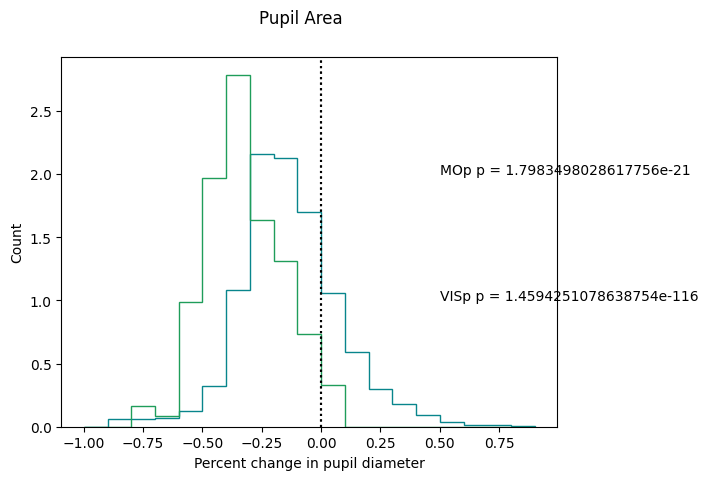

In [27]:
#Plot pupil area for alpha vs random session times
fig, ax = plt.subplots()
fig.suptitle('Pupil Area')
for ia, area in enumerate(['VISp', 'MOp']):

    pupil_diffs = []
    for pupil, pupil_rand in zip(area_pupil[area], area_pupil_rand[area]):

        mean_rand = np.nanmean(pupil_rand)
        session_pupil = np.array([p for p in pupil if p.size>999])

        if len(session_pupil)>0:
            peri_burst = np.mean(session_pupil[:, 500:600], axis=1)
            diff_from_mean = (peri_burst - mean_rand)/mean_rand

            pupil_diffs.append(diff_from_mean)
    
    pupil_diffs_flattened = [p for s in pupil_diffs for p in s]
    ax.hist(pupil_diffs_flattened, bins=np.arange(-1, 1, 0.1), color=colors[area], density=True, histtype='step')
    ax.axvline(0, c='k', ls='dotted')
    ax.set_xlabel('Percent change in pupil diameter')
    ax.set_ylabel('Count')
    p_val = scipy.stats.wilcoxon(pupil_diffs_flattened)
    ax.text(0.5, 1+ia ,f'{area} p = {p_val[1]}')

#fig.savefig(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures\VISp_MOp_pupil_hist.pdf')

In [28]:
#Collect ccgs for area pairs during VISp and MOp alpha events

areas_to_plot = ['VISp', 'MOp']

ccg_dict = {a: {} for a in areas_to_plot}
rand_ccg_dict = {a: {} for a in areas_to_plot}

for area in areas_to_plot:
    area_sessions = get_session_data_sessions_for_area(session_data, area)
    for session in area_sessions:

        sess_ccgs = session_data[session]['ccgs'][area][area]
        good_ccgs = get_qualifying_autoccgs(sess_ccgs, 0.1)
        
        other_areas =  get_areas_recorded_during_session(session)

        for area2 in other_areas:
            ccgs = np.load(os.path.join(data_dir, session, f'{area}_{area2}_ccgs.npy'))
            qualifying = ccgs[good_ccgs]

            rand_ccgs = np.load(os.path.join(data_dir, session, f'{area}_{area2}_ccgs_random.npy'))
            qualifying_rand = rand_ccgs[good_ccgs]

            if not area2 in ccg_dict[area]:
                ccg_dict[area][area2] = []
                rand_ccg_dict[area][area2] = []
           
            ccg_dict[area][area2].append(qualifying)
            rand_ccg_dict[area][area2].append(qualifying_rand)


In [ ]:
areas_to_plot = ['VISp', 'MOp']

time = np.linspace(-1, 1, 200)
for area in areas_to_plot:
    area_ccgs = ccg_dict[area]
    for area2, ccgs in area_ccgs.items():
        fig, axes = plt.subplots(1, 2)
        ax = axes[0]
        fig.suptitle(f'{area} to {area2}')

        rand_ccgs = rand_ccg_dict[area][area2]

        concat = np.concatenate(ccgs)
        rand_concat = np.concatenate(rand_ccgs)

        diff = concat - rand_concat
        diff_mean = np.mean(diff, axis=0)
        diff_std = np.std(diff, axis=0)
        diff_sem =diff_std/diff.shape[0]**0.5

        mean = np.mean(concat, axis=0)
        rand_mean = np.mean(rand_concat, axis=0)

        

        ax.plot(time, mean, 'k')
        ax.plot(time, rand_mean, 'r')

        axes[1].plot(time, diff_mean, 'k')
        axes[1].fill_between(time, diff_mean+diff_sem, diff_mean-diff_sem, color='k', alpha=0.3)

        [a.axvline(0, c='k', ls='dotted') for a in axes]

    

In [29]:
from nitime.analysis import MTCoherenceAnalyzer
from nitime.analysis import CoherenceAnalyzer

import nitime.timeseries as ts

base_sub = lambda x: x - np.mean(x)

def multi_taper_coherence(psths1, psths2, fs=100):
    coh = []
    base_sub = lambda x: x - np.mean(x)

    for p1, p2 in zip(psths1, psths2):
        t = ts.TimeSeries([base_sub(p1), base_sub(p2)], sampling_rate=fs)
        c = MTCoherenceAnalyzer(t)
        coh.append(c.coherence[0,1])
    return c.frequencies, coh

def get_lag_from_coherence(psths1, psths2, fs=100, band=[3,7]):
    coh_delays = []
    for p1, p2 in zip(psths1, psths2):
        t = ts.TimeSeries([base_sub(p1), base_sub(p2)], sampling_rate=fs)
        c = CoherenceAnalyzer(t)
        ind_band_low = np.searchsorted(c.frequencies, 3)
        ind_band_high = np.searchsorted(c.frequencies, 7)

        delays = c.delay[0,1] #positive means first signal leads
        band_delay = np.median(delays[ind_band_low:ind_band_high])
        coh_delays.append(band_delay)
        
    return coh_delays

In [30]:
#Calculate coherence between VISp/MOp and other areas during alpha events and random experiment times

from scipy.signal import coherence
areas_to_plot = ['VISp', 'MOp']

psth_dict = {a: {} for a in areas_to_plot}
rand_psth_dict = {a: {} for a in areas_to_plot}

coherence_dict = {a: {} for a in areas_to_plot}
rand_coherence_dict = {a: {} for a in areas_to_plot}

coherence_delay_dict = {a: {} for a in areas_to_plot}
rand_coherence_delay_dict = {a: {} for a in areas_to_plot}

session_dict = {a: {} for a in areas_to_plot}

for area in areas_to_plot:
    area_sessions = get_session_data_sessions_for_area(session_data, area)
    for session in area_sessions:

        sess_ccgs = session_data[session]['ccgs'][area][area]
        good_ccgs = get_qualifying_autoccgs(sess_ccgs, 0.1)
        
        if np.sum(good_ccgs)>5:
            other_areas =  get_areas_recorded_during_session(session)

            area1_psths = np.load(os.path.join(data_dir, session, f'{area}_{area}_psths.npy'))
            area1_psths = area1_psths[good_ccgs]

            area1_rand_psths = np.load(os.path.join(data_dir, session, f'{area}_{area}_psths_random.npy'))[good_ccgs]
            
            for area2 in other_areas:
                psths = np.load(os.path.join(data_dir, session, f'{area}_{area2}_psths.npy'))
                qualifying = psths[good_ccgs]

                rand_psths = np.load(os.path.join(data_dir, session, f'{area}_{area2}_psths_random.npy'))
                qualifying_rand = rand_psths[good_ccgs]

                if not area2 in psth_dict[area]:
                    psth_dict[area][area2] = []
                    rand_psth_dict[area][area2] = []
                    coherence_dict[area][area2] = []
                    rand_coherence_dict[area][area2] = []
                    session_dict[area][area2] = []
                    coherence_delay_dict[area][area2] = []
                    rand_coherence_delay_dict[area][area2] = []
            
                psth_dict[area][area2].append(qualifying)
                rand_psth_dict[area][area2].append(qualifying_rand)

                freqs, coh = multi_taper_coherence(area1_psths, qualifying, fs=100)
                freqs, rand_coh = multi_taper_coherence(area1_psths, qualifying_rand, fs=100)

                coh_delay = get_lag_from_coherence(area1_psths, qualifying, fs=100, band=[3,7])
                rand_coh_delay = get_lag_from_coherence(area1_rand_psths, qualifying_rand, fs=100, band=[3,7])

                # num_iterations = 100
                # shuffle_rand_coh = []
                # for it in range(num_iterations):
                #     r_p = qualifying_rand[np.random.permutation(qualifying_rand.shape[0])]
                #     freqs, rand_coh = multi_taper_coherence(area1_psths, r_p, fs=100)
                #     shuffle_rand_coh.append(rand_coh)
                
                coherence_dict[area][area2].append(coh)
                rand_coherence_dict[area][area2].append(rand_coh)
                coherence_delay_dict[area][area2].append(coh_delay)
                rand_coherence_delay_dict[area][area2].append(rand_coh_delay)

                session_dict[area][area2].append(session)


c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\nitime\analysis\coherence.py:200: RuntimeWarning: invalid value encountered in divide
  delay[i, j] = this_phase / (2 * np.pi * self.frequencies)
c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\nitime\analysis\coherence.py:200: RuntimeWarning: divide by zero encountered in divide
  delay[i, j] = this_phase / (2 * np.pi * self.frequencies)


In [34]:
boxcar = lambda x: np.convolve(x, np.ones(4), 'same')/4

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\3462729681.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,2)


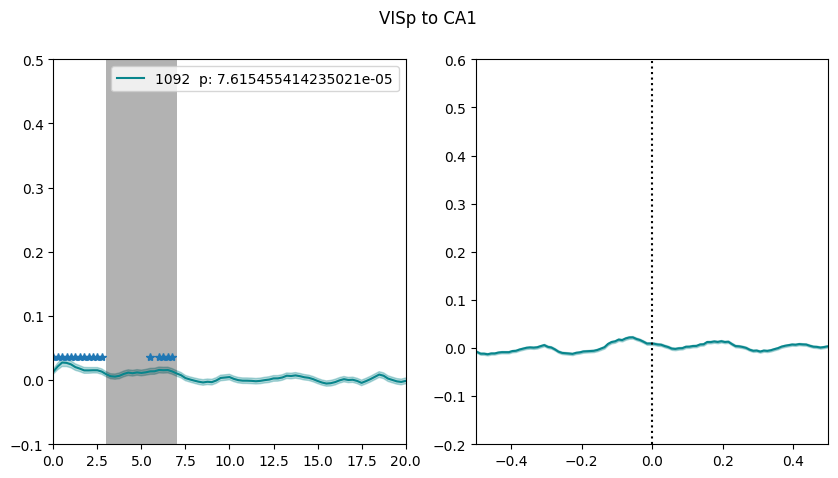

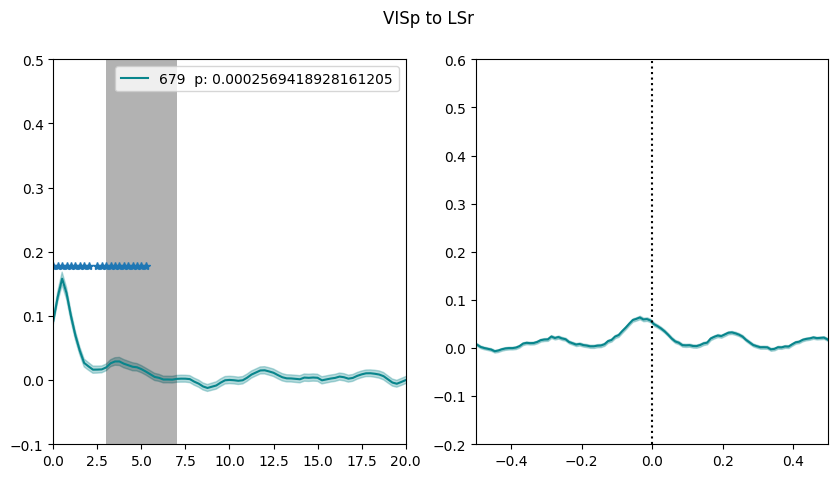

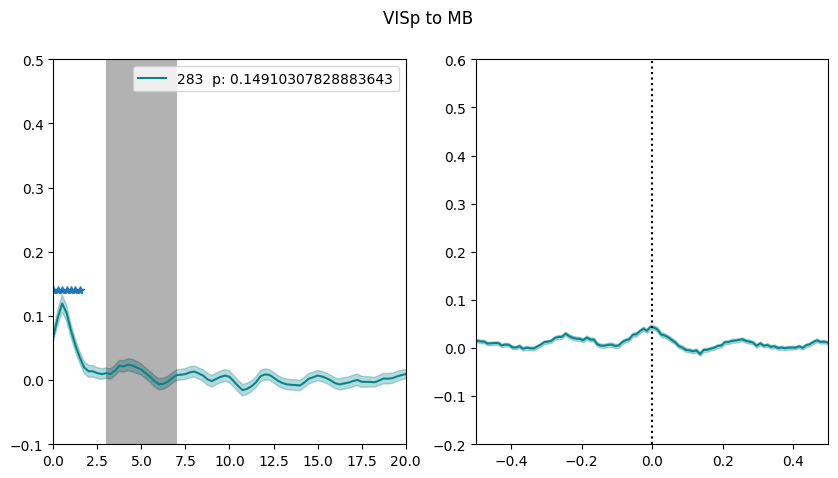

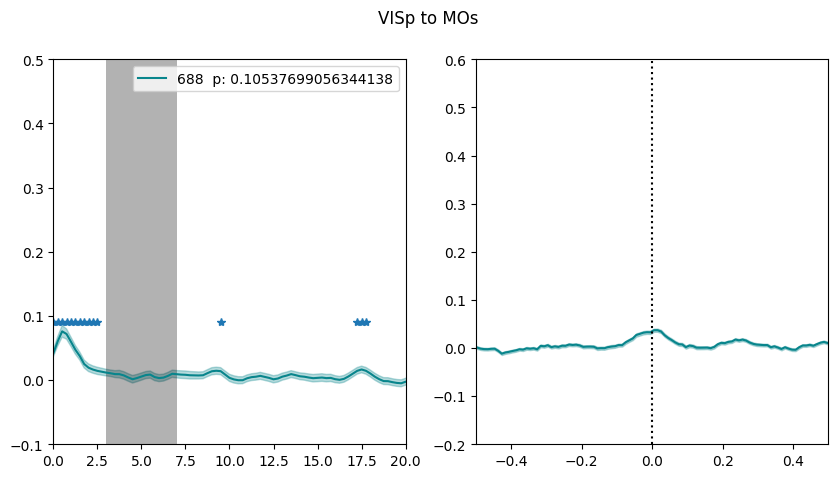

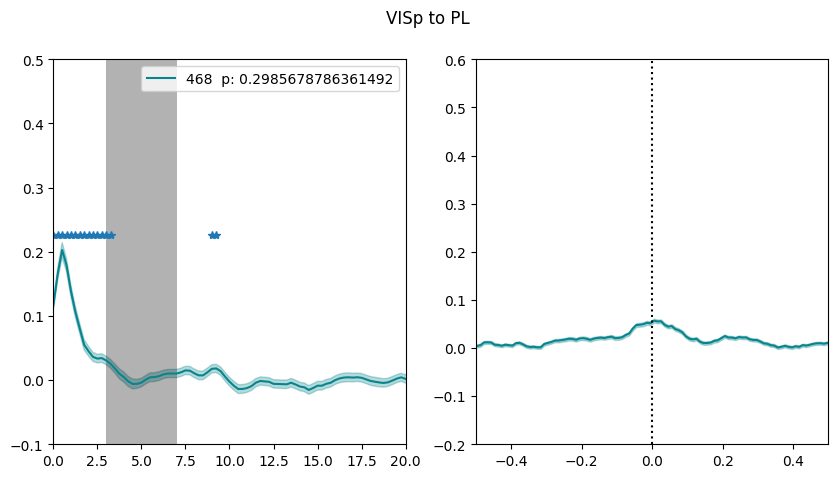

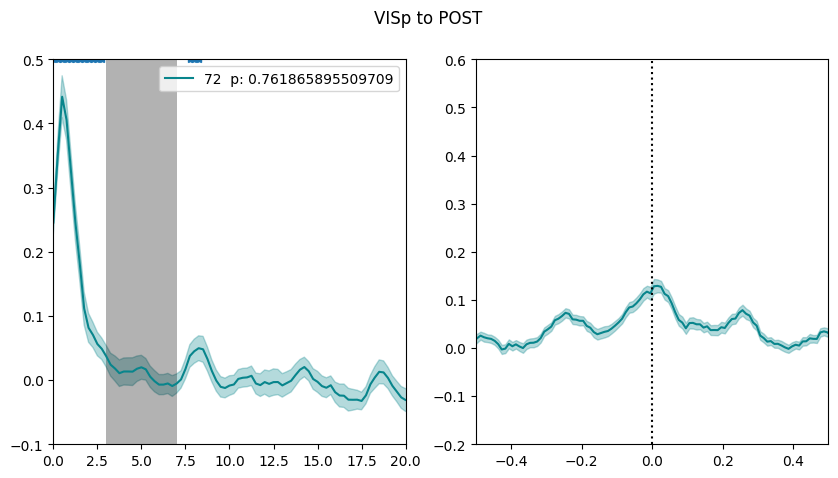

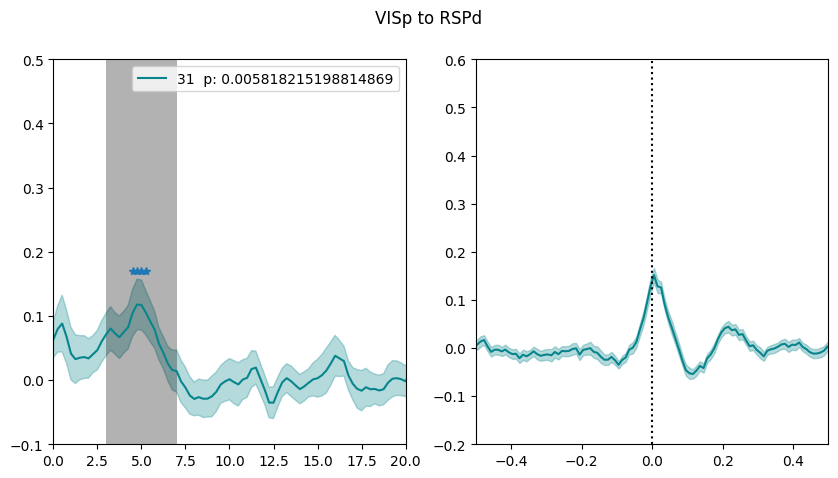

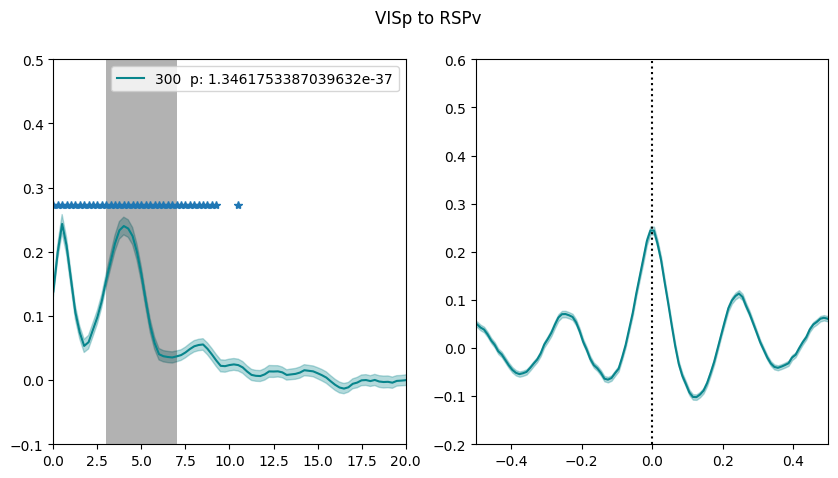

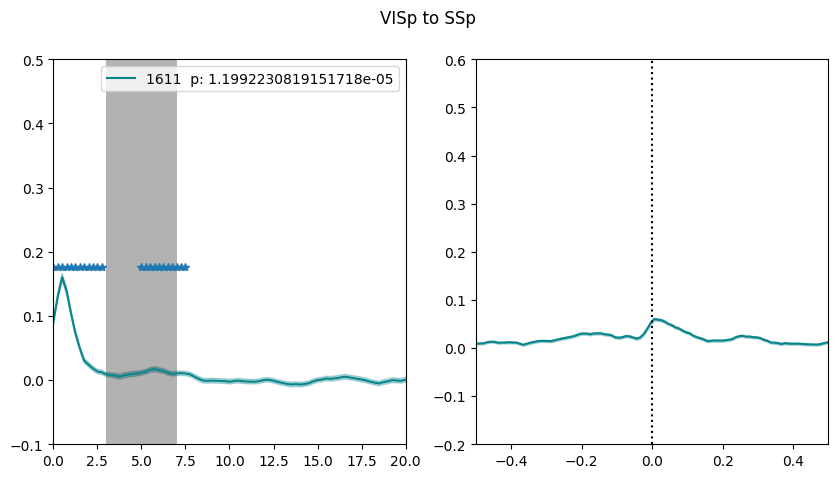

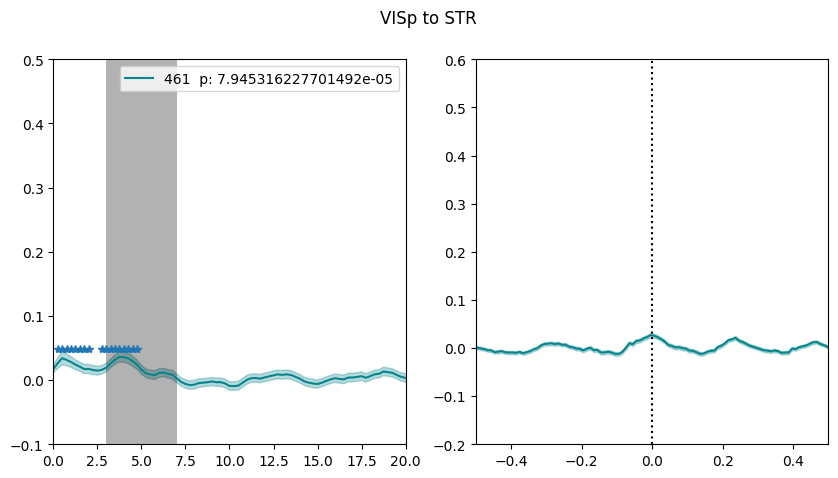

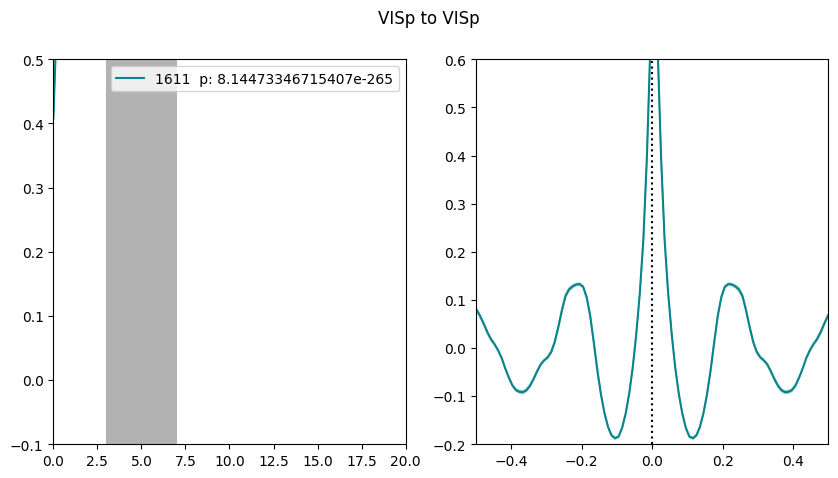

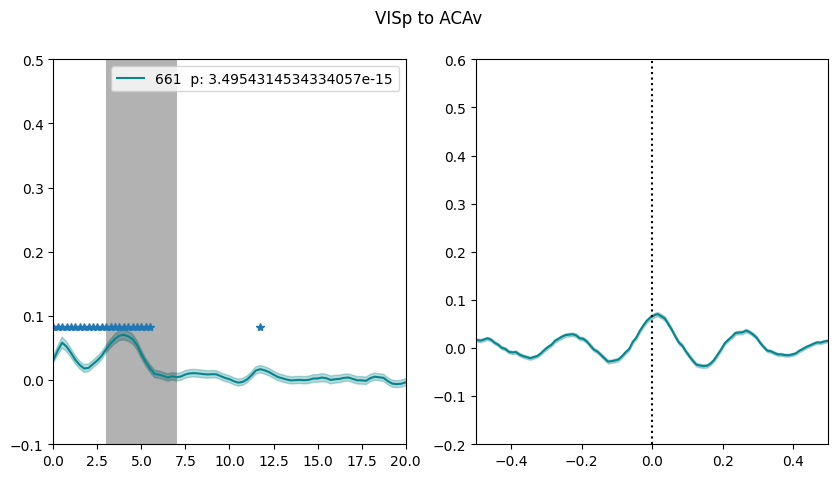

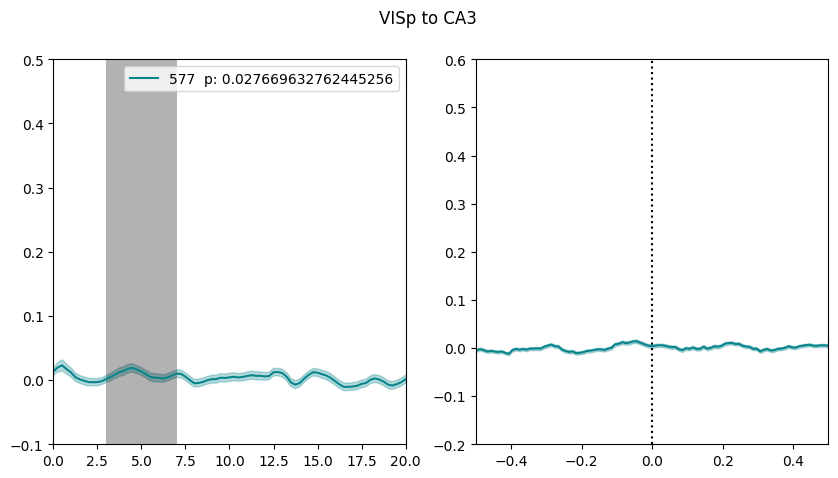

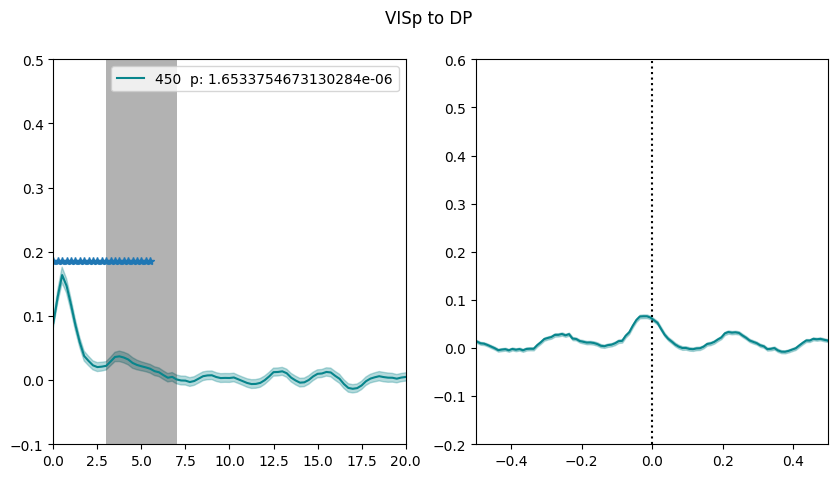

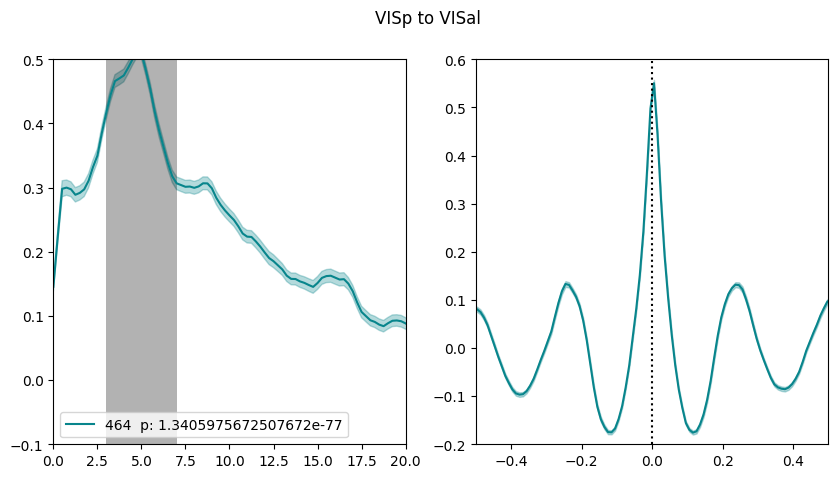

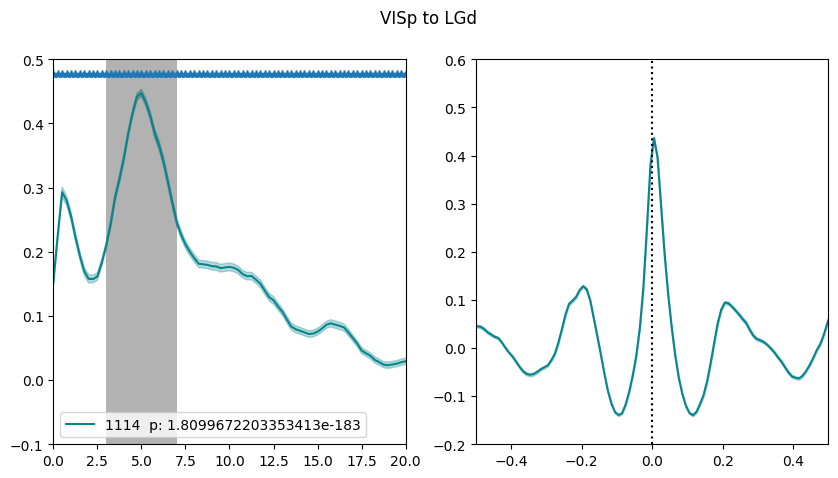

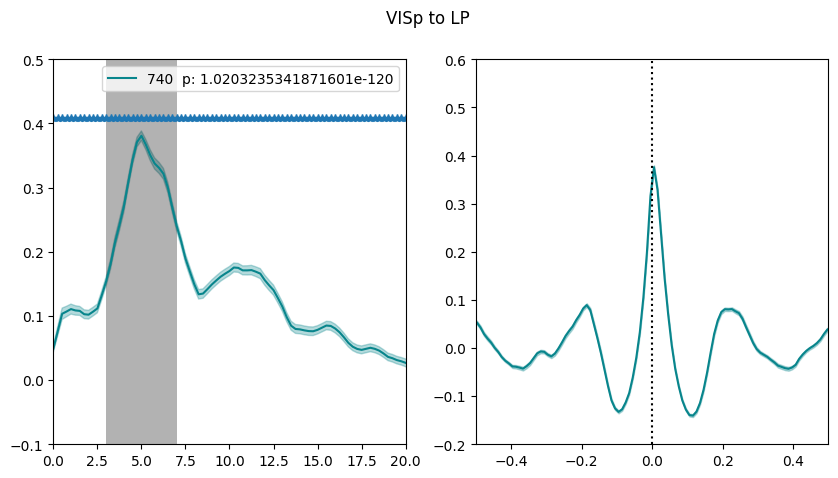

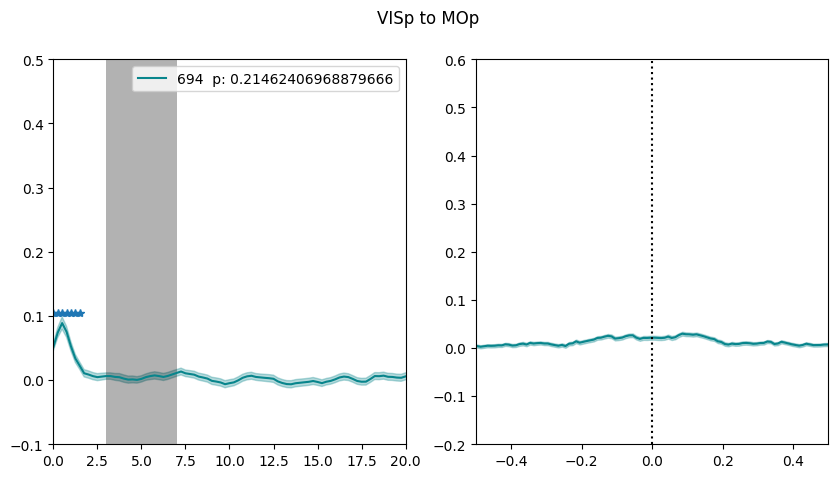

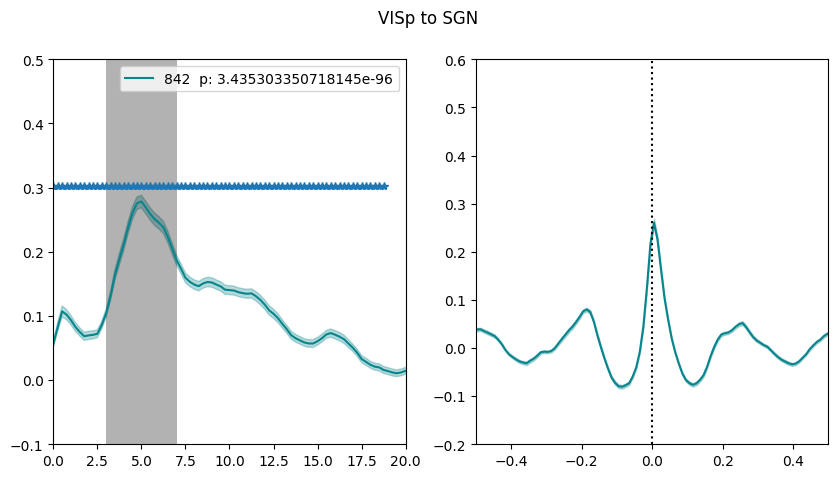

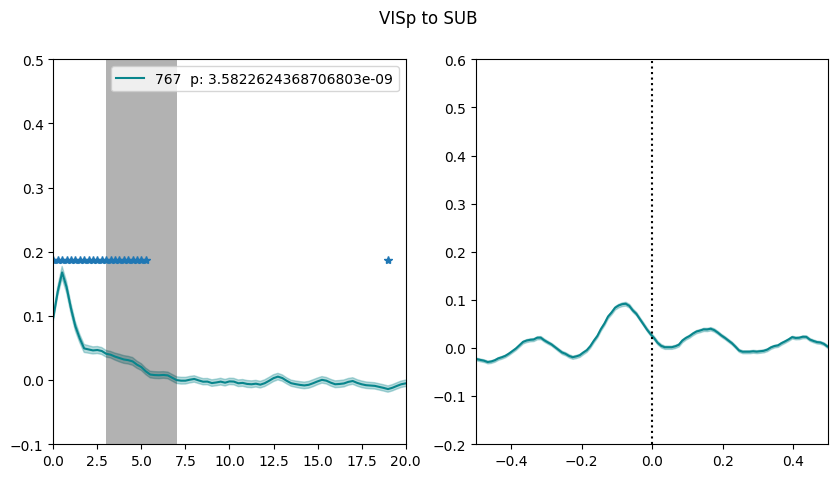

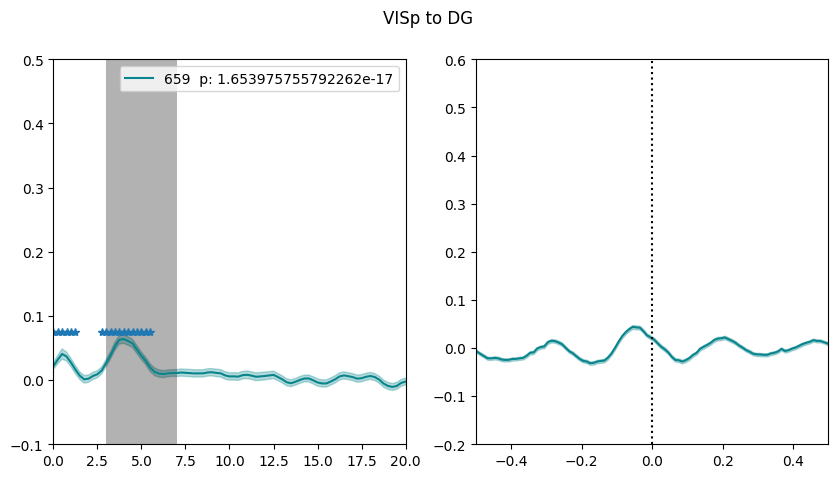

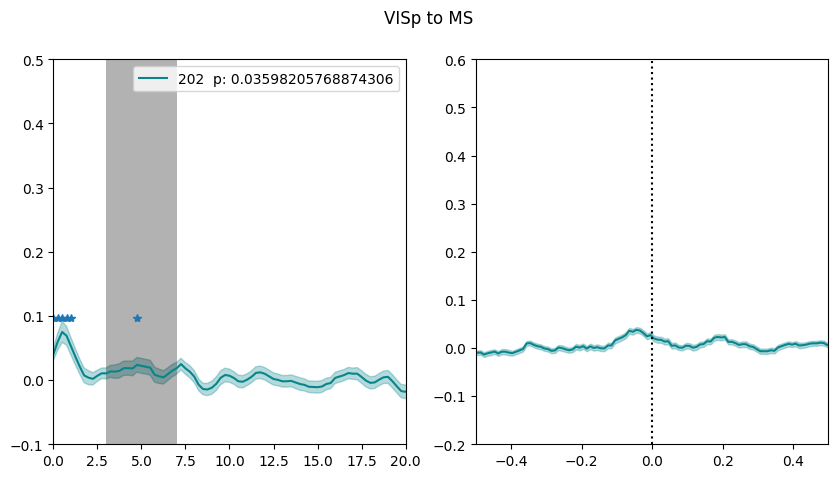

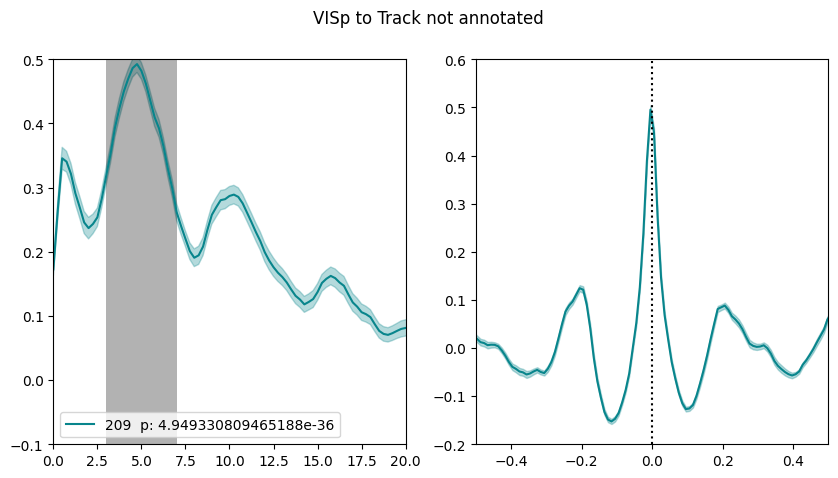

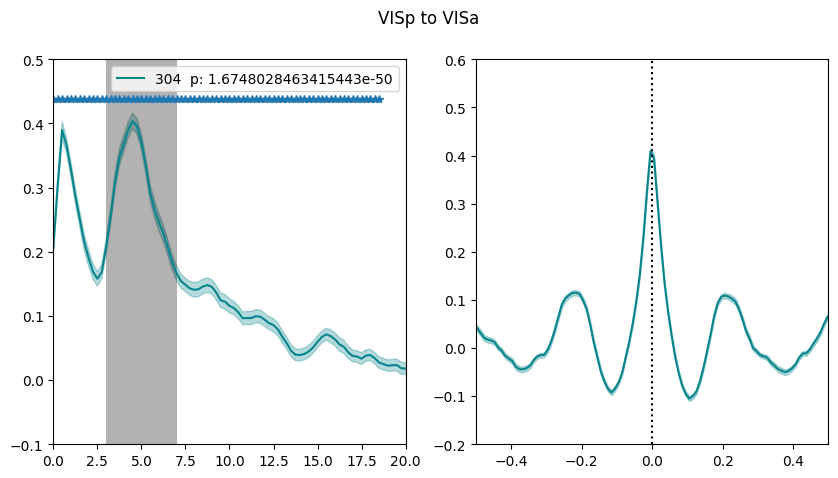

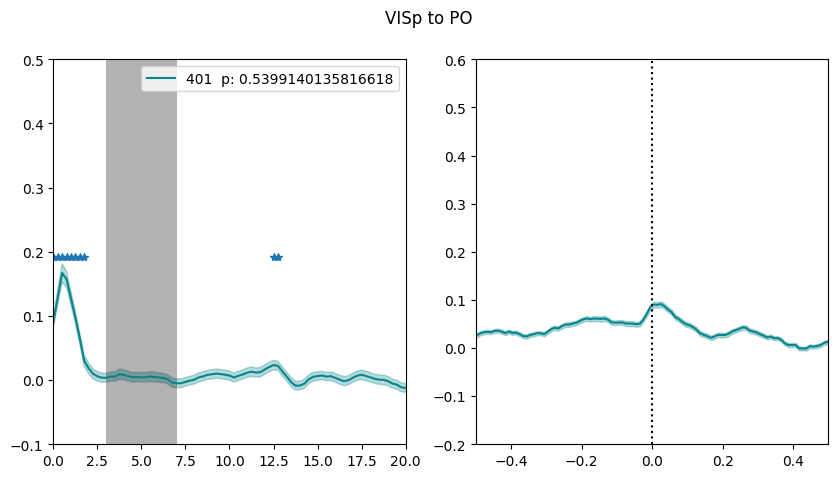

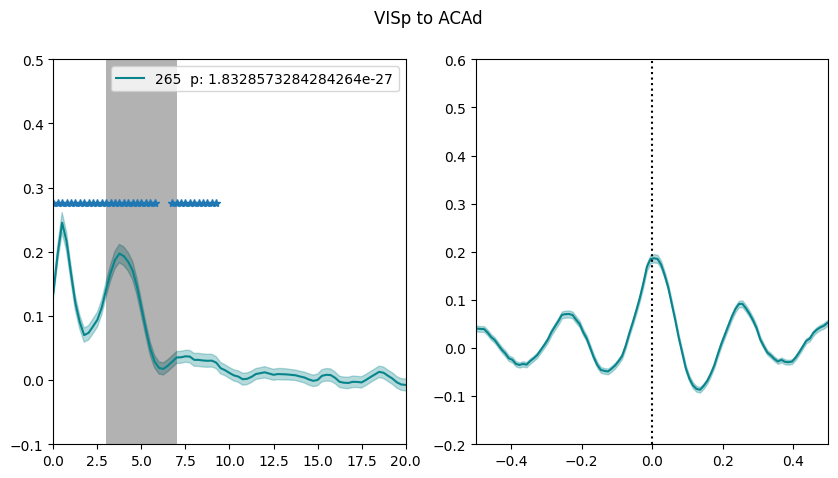

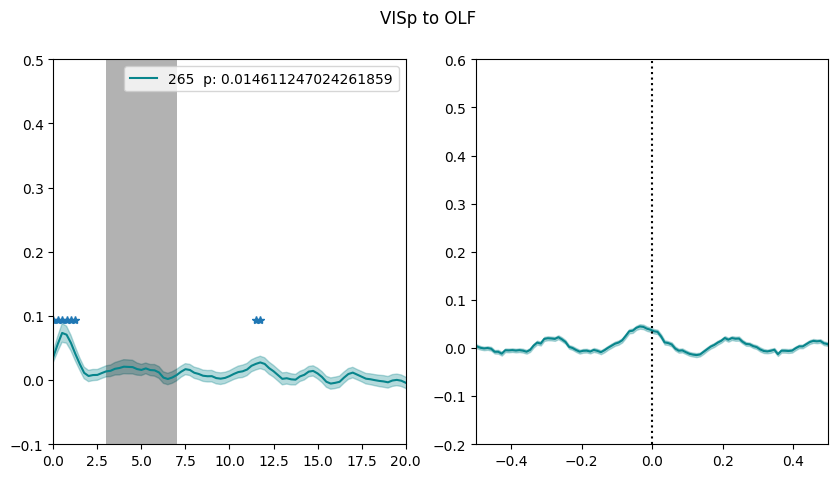

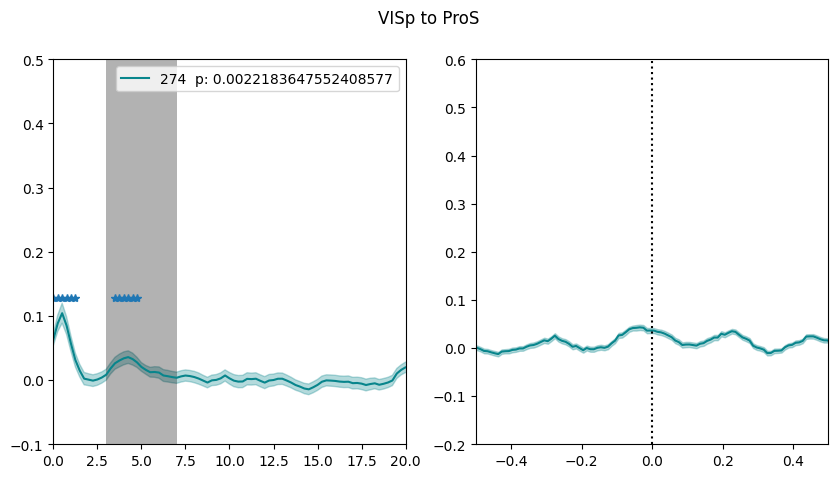

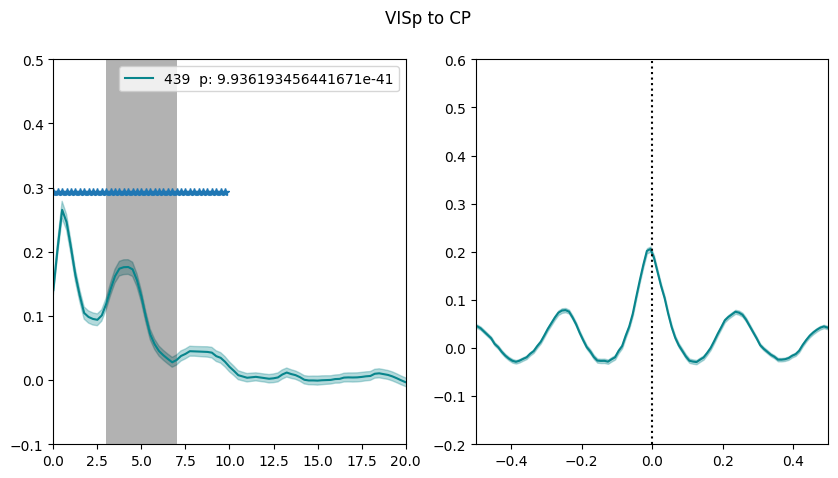

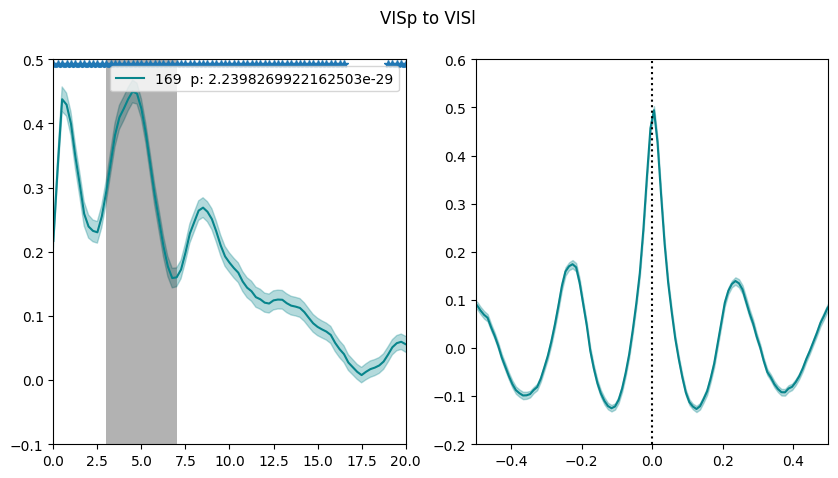

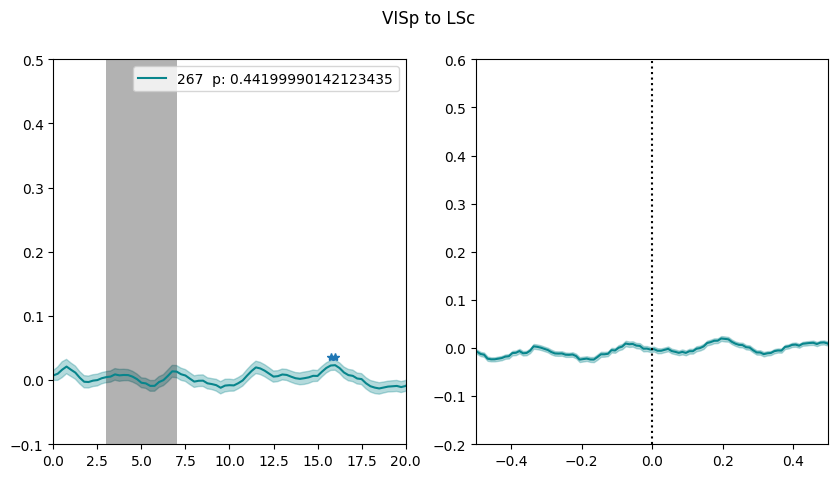

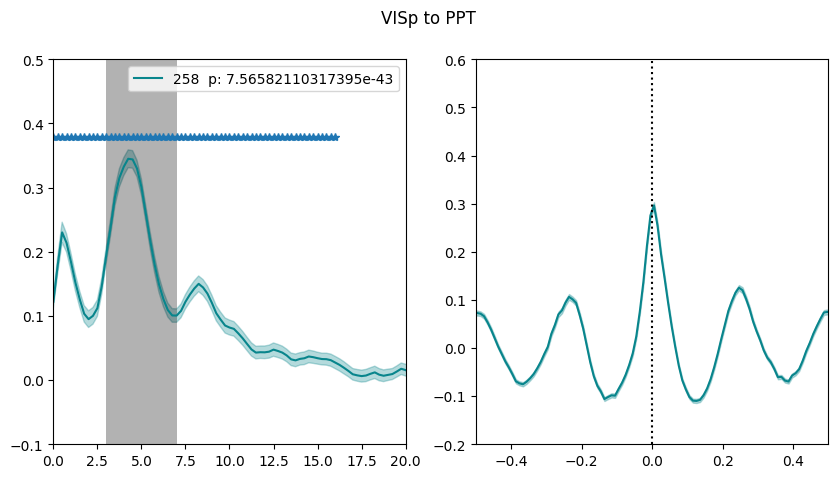

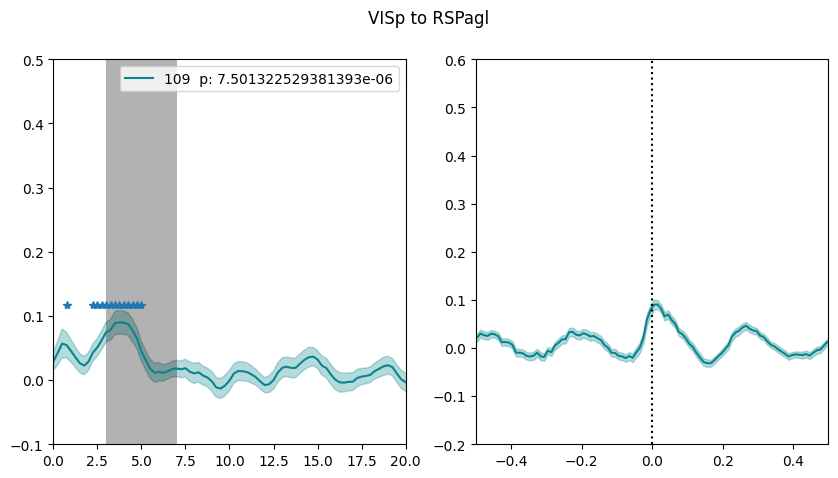

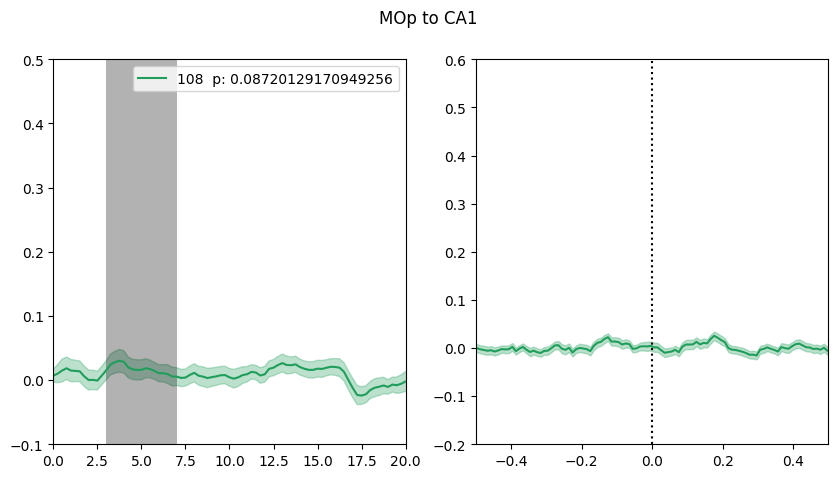

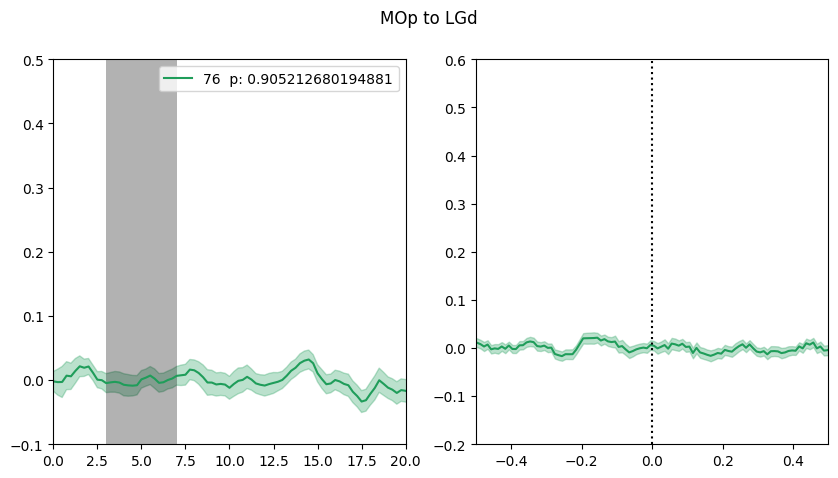

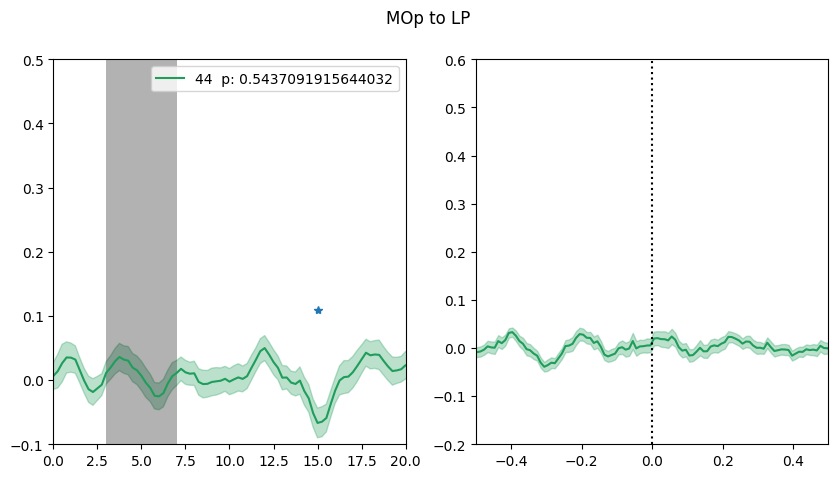

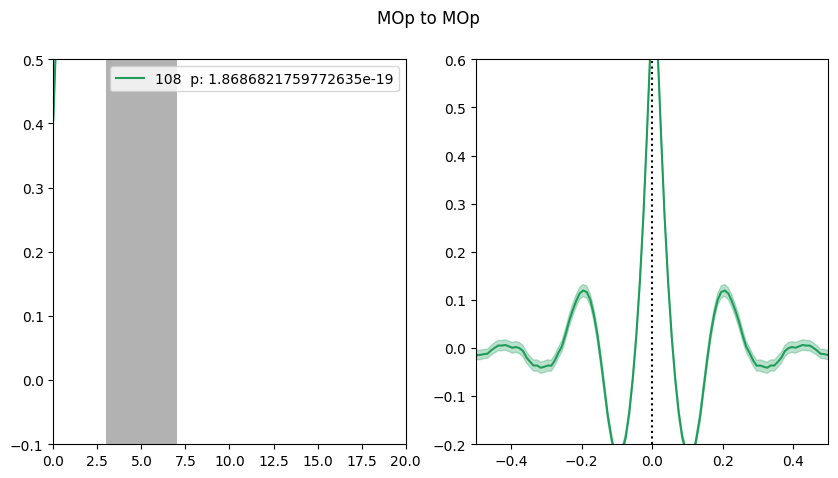

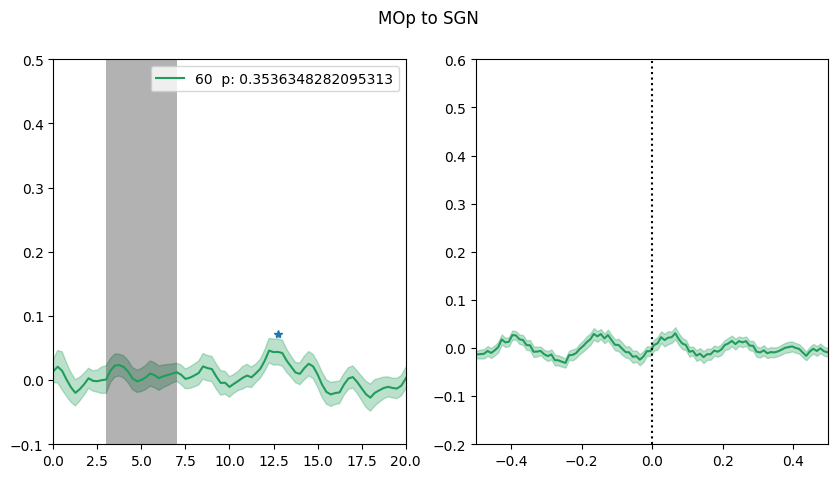

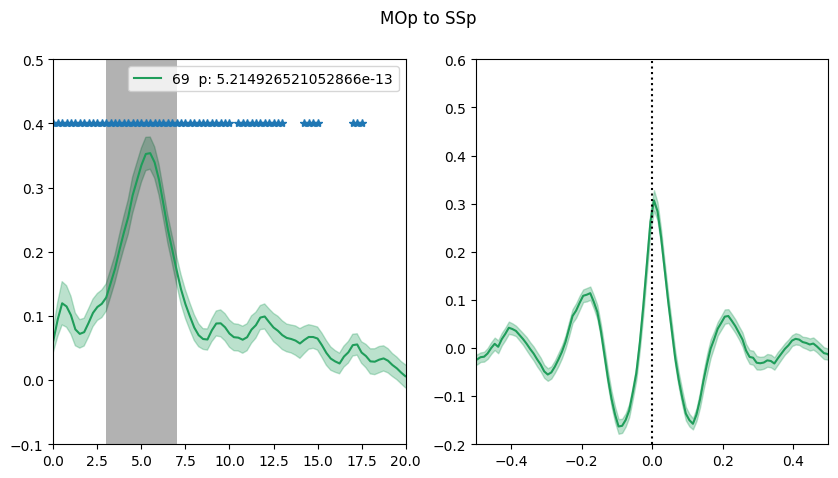

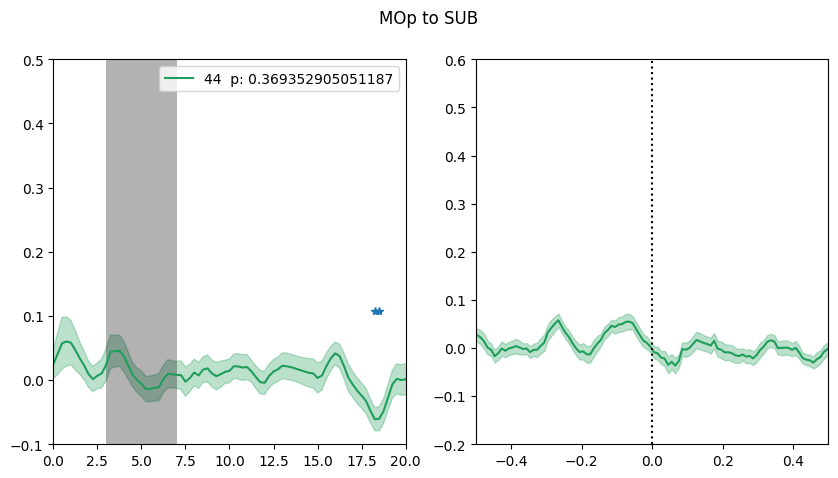

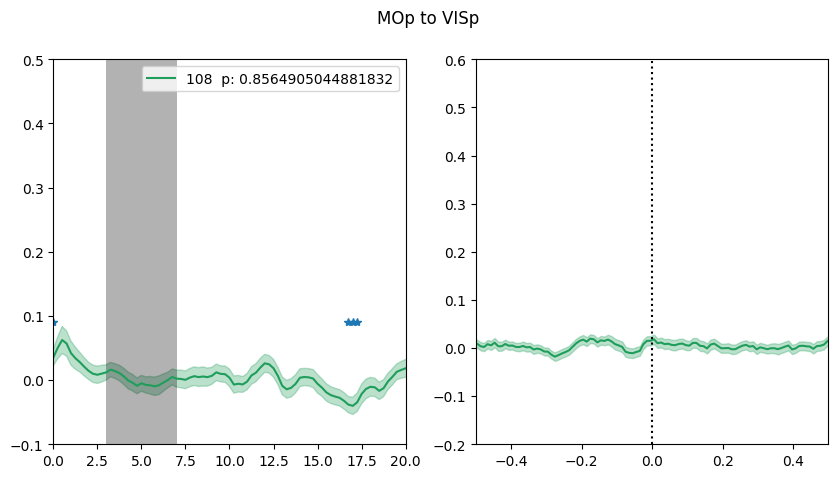

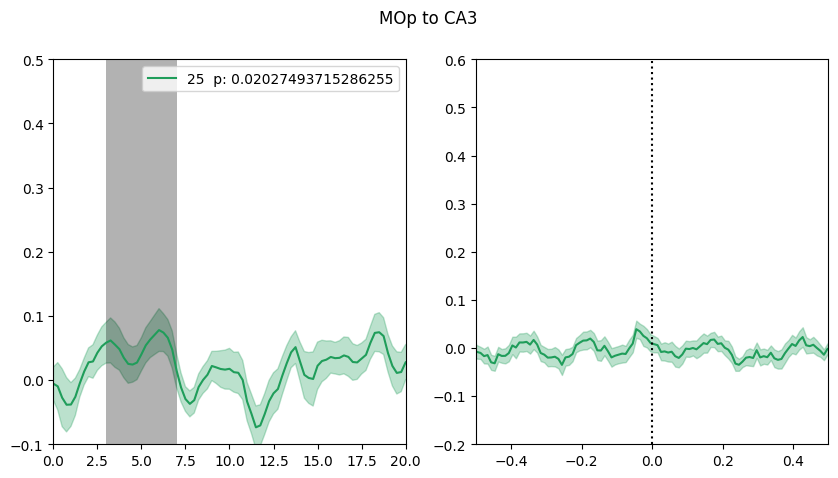

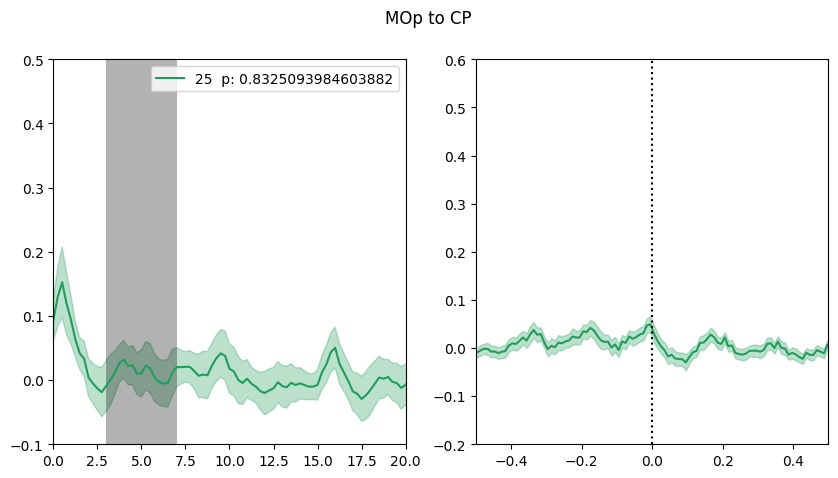

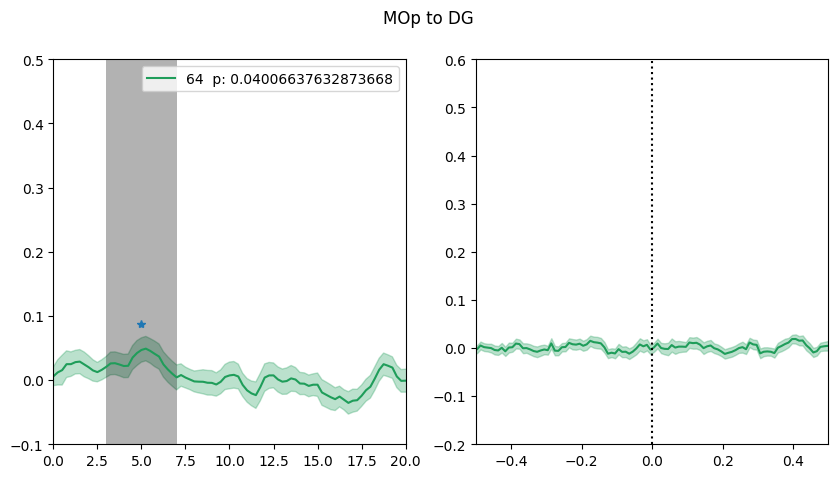

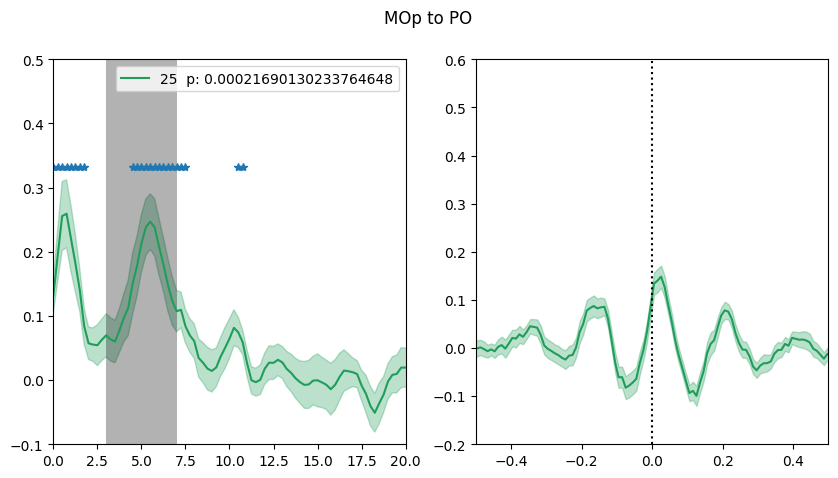

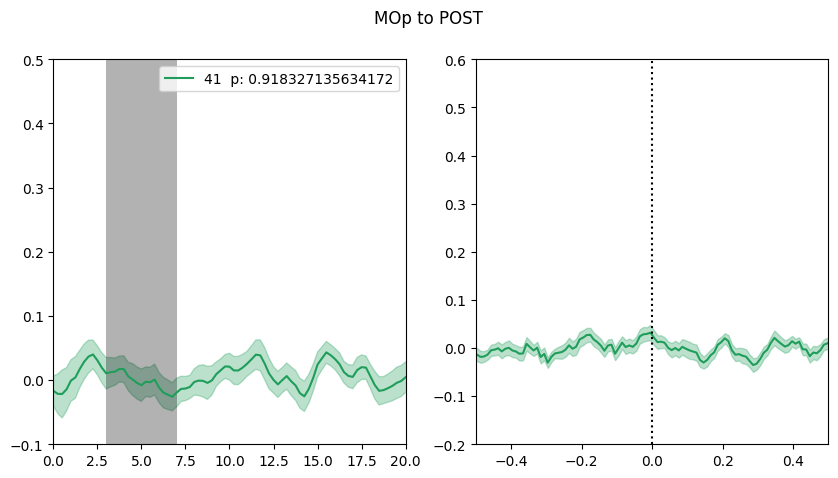

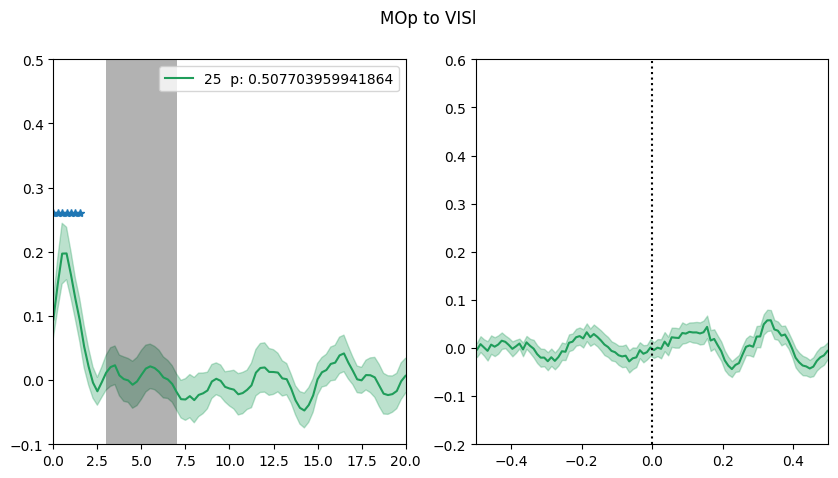

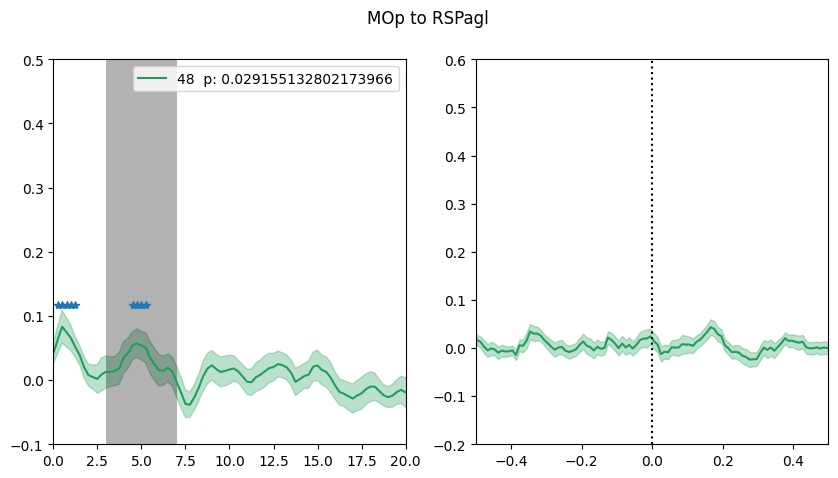

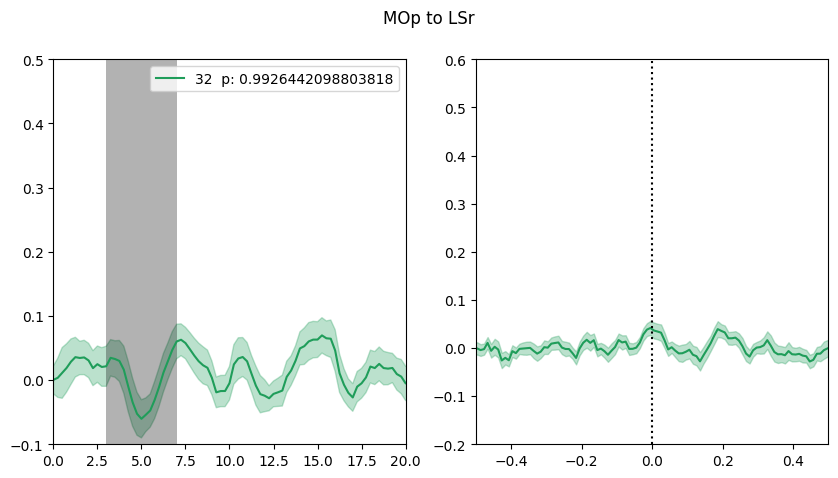

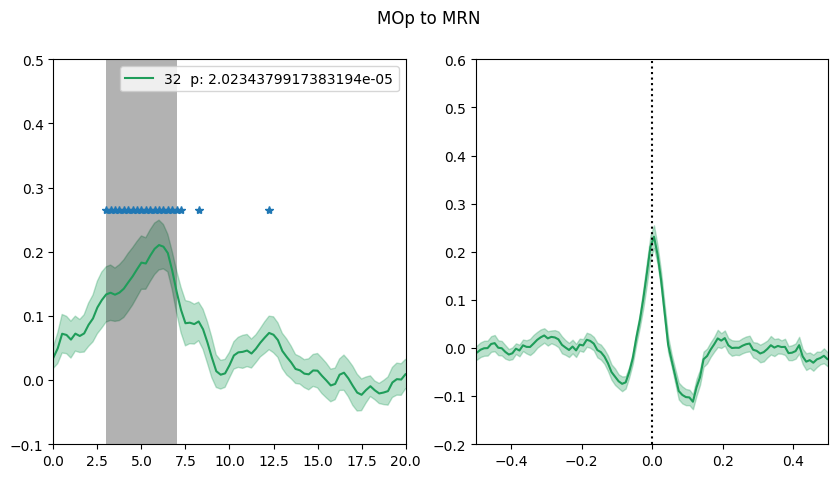

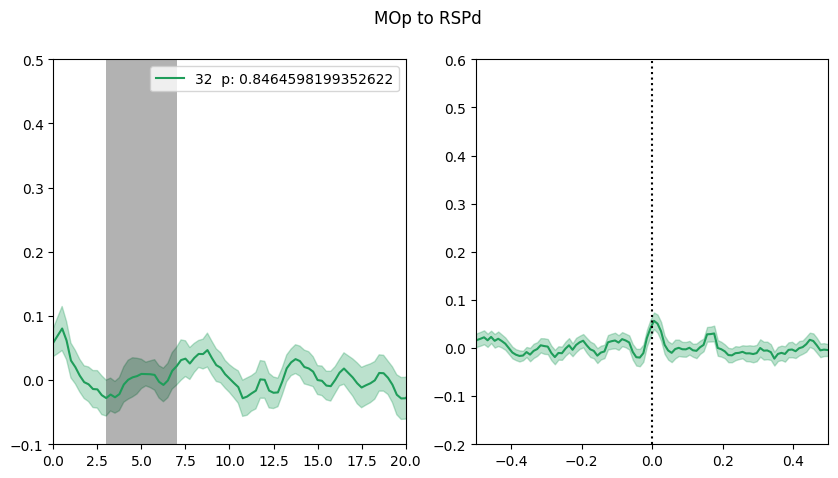

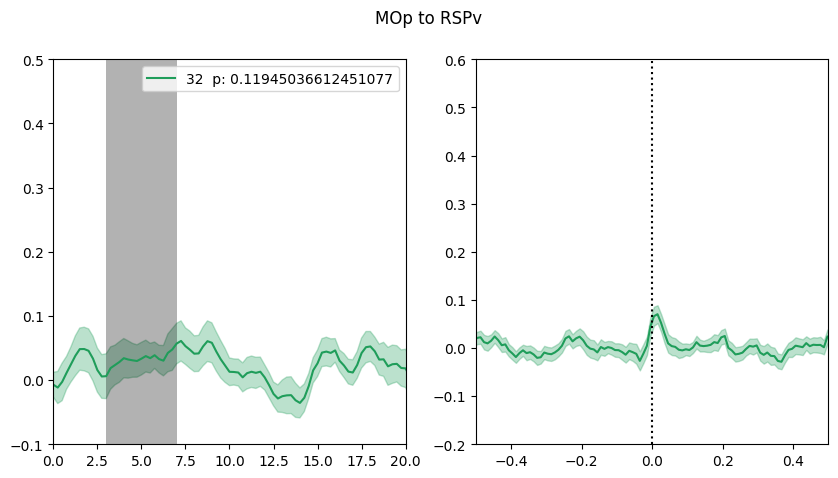

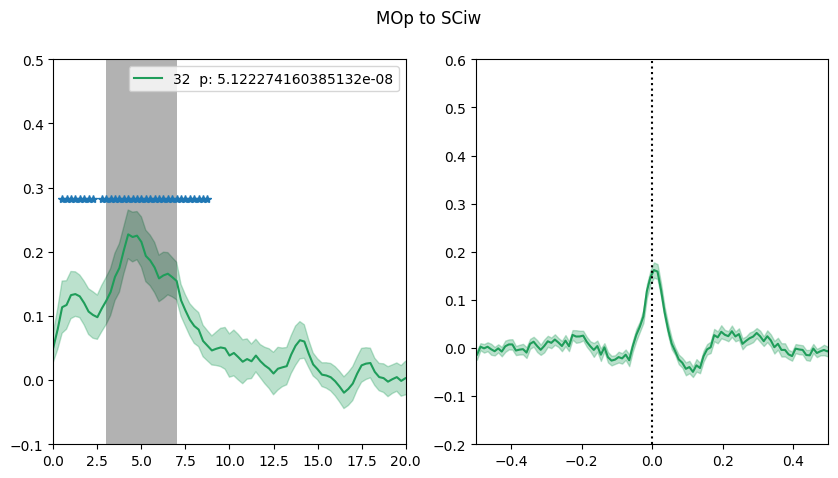

In [35]:
areas_to_plot = ['VISp', 'MOp']
coh_band = {a: {} for a in areas_to_plot}
coh_band_sem = {a: {} for a in areas_to_plot}
coh_sig = {a: {} for a in areas_to_plot}
ind_band_low = np.searchsorted(freqs, 3)
ind_band_high = np.searchsorted(freqs, 7)
time = np.linspace(-1, 1, 200)
for area in areas_to_plot:
    area_coherence = coherence_dict[area]
    area_ccgs = ccg_dict[area]
    for area2, coh in area_coherence.items():
        color = colors[area]
        #coh = np.array([np.mean(c, axis=0) for c in coh if len(c)>5])
        coh = np.concatenate(coh)
        coh = np.array([boxcar(c) for c in coh])

        if coh.shape[0]<25:
            continue
        
        session_coh = [np.mean(c, axis=0) for c in area_coherence[area2]]


        ccgs = ccg_dict[area][area2]
        ccgs = np.concatenate(ccgs)

        fig, axes = plt.subplots(1,2)
        fig.set_size_inches([10, 5])
        #diff_and_mean_ax = axes[0]
        diff_ax = axes[0]
        ccg_ax = axes[1]
        fig.suptitle(f'{area} to {area2}')

        #coh = np.concatenate(coh)
        #rand_coh = np.concatenate([np.mean(rc, axis=0) for rc in rand_coherence_dict[area][area2]])
        #rand_coh = np.array([np.mean(c, axis=0) for c in rand_coherence_dict[area][area2] if len(c)>5])
        rand_coh = np.concatenate(rand_coherence_dict[area][area2])
        rand_coh = np.array([boxcar(c) for c in rand_coh])

        session_rand_coh = [np.mean(c, axis=0) for c in rand_coherence_dict[area][area2]]

        coh_diff = coh - rand_coh
        pvals = np.array([scipy.stats.wilcoxon(c)[1] for c in coh_diff.T])
        sig_freqs = pvals<0.01
        sig_plot = np.ones(len(sig_freqs))
        sig_plot[~sig_freqs] = np.nan

        mean_coh_diff = np.mean(coh_diff, axis=0)
        sem_coh_diff = np.std(coh_diff, axis=0)/(coh.shape[0])**0.5

        mean_coh = np.mean(coh, axis=0)
        sem_coh = np.std(coh, axis=0)/(coh.shape[0])**0.5
        mean_rand_coh = np.mean(rand_coh, axis=0)
        sem_rand_coh = np.std(rand_coh, axis=0)/(rand_coh.shape[0])**0.5

        mean_in_band_per_trial = np.mean(coh_diff[:, ind_band_low:ind_band_high], axis=1)
        coh_band[area][area2] = np.mean(mean_coh_diff[ind_band_low:ind_band_high])
        coh_band_sem[area][area2] = np.std(mean_in_band_per_trial)/(len(mean_in_band_per_trial)**0.5)
        coh_sig[area][area2] = scipy.stats.wilcoxon(np.mean(coh_diff[:, ind_band_low:ind_band_high], axis=1))[1]

        # ax.plot(freqs, mean_coh, color)
        # ax.fill_between(freqs, mean_coh + sem_coh, mean_coh - sem_coh, color = color, alpha=0.3)
        # ax.plot(freqs, mean_rand_coh, 'r')
        # ax.fill_between(freqs, mean_rand_coh + sem_rand_coh, mean_rand_coh - sem_rand_coh, color = 'r', alpha=0.3)


        # for s_c in session_coh:
        #     ax.plot(freqs, s_c)

        #ax.legend(['mean'] + session_dict[area][area2])
        
        diff_ax.plot(freqs, mean_coh_diff, color)
        diff_ax.fill_between(freqs, mean_coh_diff+sem_coh_diff, mean_coh_diff-sem_coh_diff, color=color, alpha=0.3)
        ymax = diff_ax.get_ylim()[1]
        diff_ax.plot(freqs, sig_plot*ymax, '*')

        [a.set_xlim([0, 20]) for a in [diff_ax]]
        [a.set_ylim([-0.1, 0.5]) for a in [diff_ax]]

        [a.axvspan(3,7, facecolor='k', alpha=0.3) for a in [diff_ax]]

        legend_str = f'{coh.shape[0]}  p: {coh_sig[area][area2]}'
        diff_ax.legend([legend_str])
        

        mean_ccg = np.mean(ccgs, axis=0)
        sem_ccg = np.std(ccgs, axis=0)/(ccgs.shape[0])**0.5
        ccg_ax.plot(time, np.mean(ccgs, axis=0), color)
        ccg_ax.fill_between(time, mean_ccg+sem_ccg, mean_ccg-sem_ccg, alpha=0.3, color=color)
        ccg_ax.axvline(0, color='k', ls='dotted')
        ccg_ax.set_xlim([-0.5, 0.5])
        ccg_ax.set_ylim([-0.2, 0.6])

        # fig.savefig(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures\coherence_plots',
        #                         f'{area}_to_{area2}_coherence.pdf'))

In [43]:
from statsmodels.stats.multitest import fdrcorrection

In [44]:
coh_sig_corrected = {a: {} for a in areas_to_plot}

for area in ['VISp', 'MOp']:
    pvals = []
    for area2, pval in coh_sig[area].items():
        pvals.append(pval)
    
    corrected_pvals = fdrcorrection(pvals)
    for ind, (area2, pval) in enumerate(coh_sig[area].items()):
        coh_sig_corrected[area][area2] = corrected_pvals[0][ind]

In [45]:
other_areas = list(coh_band['VISp'].keys()) + list(coh_band['MOp'].keys())
other_areas = np.unique(other_areas)
other_areas = np.array([o for o in other_areas if 'Track' not in o])
other_areas = np.sort(other_areas)
other_area_brain_divisions = [ccf_utils.get_brain_division_for_area(o, structure_tree) for o in other_areas]

brain_division_order = {
    'Isocortex': 1,
    'Hippocampal formation': 2,
    'Thalamus': 3,
    'Striatum': 4,
    'Pallidum': 5,
    'Midbrain': 6,
    'Olfactory areas': 7,
    'not in list': 8
}

other_area_brain_division_order = [brain_division_order[o] for o in other_area_brain_divisions]

area_df = pd.DataFrame({'area': other_areas, 'brain_division': other_area_brain_divisions, 'order': other_area_brain_division_order})
other_areas = area_df.sort_values(by=['order', 'area'])['area'].values


Text(0.5, 0, 'CCF Region')

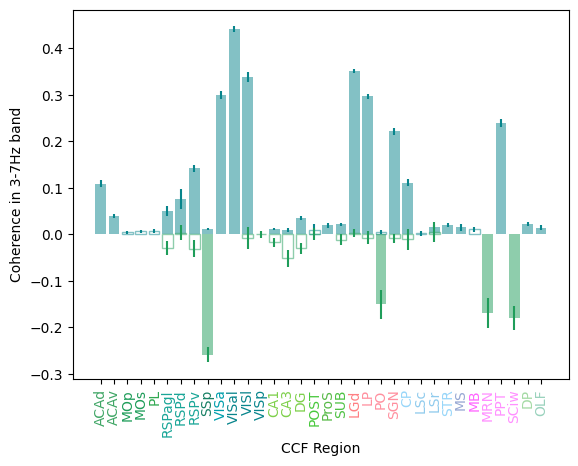

In [46]:
fig, ax = plt.subplots()
multiplier = {'VISp': 1, 'MOp': -1}
for area in areas_to_plot:
    area_coh = []
    area_coh_sem = []
    area_coh_sig = []
    for area2 in other_areas:

        c = coh_band[area].get(area2, np.nan)
        sig = coh_sig_corrected[area].get(area2, np.nan)
        sem = coh_band_sem[area].get(area2, np.nan)
        if area==area2:
            c = np.nan
            sig= np.nan
            sem = np.nan
        area_coh.append(c)
        area_coh_sig.append(sig)
        area_coh_sem.append(sem)

    area_coh = np.array(area_coh)
    bars = ax.bar(np.arange(len(other_areas)), multiplier[area]*area_coh, 
                            alpha=0.5, color=colors[area], yerr=area_coh_sem,
                            error_kw=dict(ecolor=colors[area]))
    for ib, bar in enumerate(bars):
        sig = area_coh_sig[ib]
        if ~np.isnan(sig) and not sig:
            bar.set_color('w')
            bar.set_edgecolor(colors[area])
        

ax.set_xticks(np.arange(len(other_areas)))
ax.set_xticklabels(other_areas, rotation=90)
tick_colors = [ccf_utils.get_area_color(o, structure_tree) for o in other_areas]
for xtick, tick_color in zip(ax.get_xticklabels(), tick_colors):
    xtick.set_color(tick_color)

ax.set_ylabel('Coherence in 3-7Hz band')
ax.set_xlabel('CCF Region')
#fig.savefig(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\Figures\VISp_MOp_coherence_bar_plots.pdf')

VISp to VISal lag: 1.5882775578075972e-16
VISp to VISl lag: 0.00012760237119076117
VISp to LGd lag: 2.415347387718132e-49
VISp to LP lag: 0.010325402857717356
VISp to CP lag: 3.0077715447254523e-24
MOp to SSp lag: 0.0023634714579872317
MOp to PO lag: 0.00021690130233764648


C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_303728\60446723.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_delays = np.array(area_delays)[corrected_pvals]


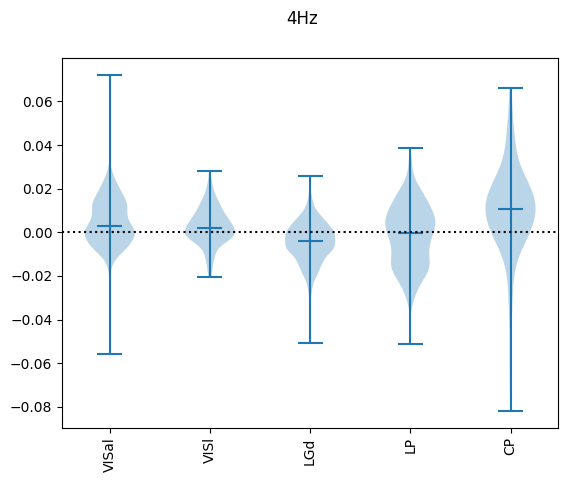

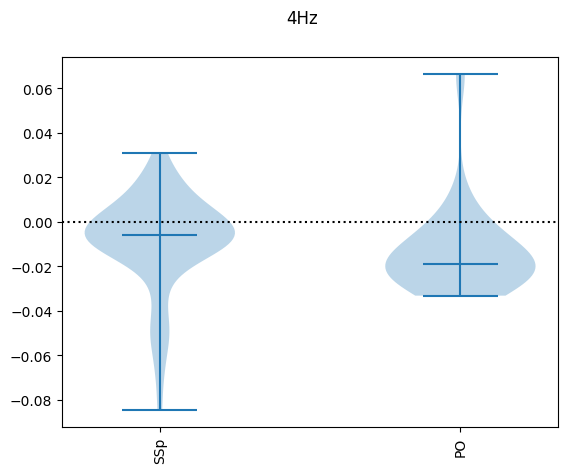

In [48]:
areas_to_plot_for_lag = {'VISp': ['VISl', 'VISal', 'LGd', 'LP', 'CP'], 'MOp': ['SSp', 'PO']}
for area in areas_to_plot:
    for delay_dict, label in zip([coherence_delay_dict], ['4Hz']):
        delay_data = delay_dict[area]
        fig, ax = plt.subplots()
        fig.suptitle(label)
        area_delays = []
        area_delay_names = []
        area_delay_pvals = []
        for area2 in other_areas:
            if area2 in delay_data and not area==area2 and area2 in areas_to_plot_for_lag[area]:
                delays = delay_data[area2]
        # for area2, delays in delay_data.items():
                if area2 in coh_sig_corrected[area] and coh_sig_corrected[area][area2]:
                    delays_flattened = [v for s in delays for v in s]
                    area_delays.append(delays_flattened)
                    area_delay_names.append(area2)
                    print(f'{area} to {area2} lag: {scipy.stats.wilcoxon(delays_flattened)[1]}')
                    area_delay_pvals.append(scipy.stats.wilcoxon(delays_flattened)[1])

        corrected_pvals = fdrcorrection(area_delay_pvals)[0]
        area_delays = np.array(area_delays)[corrected_pvals]
        area_delay_names = np.array(area_delay_names)[corrected_pvals]
        
        ax.violinplot(area_delays, showmedians=True)
        ax.axhline(0, color='k', ls='dotted')
        ax.set_xticks(np.arange(1, len(area_delays)+1))
        ax.set_xticklabels(area_delay_names, rotation=90)
        #ax.set_ylim(-0.05, 0.05)

        #fig.savefig(f'{area}_{label}_lags.pdf')

CP RF and no RF analysis

In [ ]:
import h5py
import tensor_utils as tu

In [ ]:
task_tensor = h5py.File(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor.hdf5")
burst_tensor = h5py.File(r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_VISp_bursts.hdf5")


In [ ]:
from analysis_utils import exponential_convolve

In [ ]:
def determine_visually_responsive(unit_response_mean, vis_response_slice=slice(25, 35), baseline_slice=slice(15, 25)):

    baseline_mean = np.mean(unit_response_mean[baseline_slice], axis=0)
    baseline_std = np.std(unit_response_mean[baseline_slice])
    response_mean = np.mean(unit_response_mean[vis_response_slice])

    # print(baseline_mean, baseline_std, (baseline_std*2 + baseline_mean), response_mean)
    return response_mean > (baseline_std*2 + baseline_mean)

def determine_visually_responsive_array(unit_response_array, vis_response_slice=slice(27, 37), baseline_slice=slice(15, 25)):

    baseline_means = np.mean(unit_response_array[:, baseline_slice], axis=1)
    response_means = np.mean(unit_response_array[:, vis_response_slice], axis=1)

    pval = scipy.stats.kstest(baseline_means, response_means)
    return pval[1]<0.05 and np.mean(response_means)>np.mean(baseline_means)    

In [ ]:
def exponential_convolve_array(array, tau=2):
    newarray = np.zeros_like(array)
    for ic, cell in enumerate(array):
        for it, trial in enumerate(cell):
            trial = exponential_convolve(trial, tau)
            newarray[ic, it] = trial
    
    return newarray

In [ ]:
def get_image_response(unit_ids, session_task_tensor):

    area_sess_stim_tensor = tu.get_tensor_by_unit_ids(unit_ids, 
                                                        session_task_tensor)

    area_sess_stim_tensor_base_sub = area_sess_stim_tensor - np.mean(area_sess_stim_tensor[:, :, 200:250])
    area_sess_stim_tensor_base_sub_smooth = exponential_convolve_array(area_sess_stim_tensor_base_sub)

    return area_sess_stim_tensor_base_sub_smooth

In [ ]:
cp_rf = []
cp_no_rf = []
v1 = []
for session_id in ['1182628226', '1182871514', '1183071525', '1194850630', '1195036753']:

    session_task_tensor = task_tensor[session_id]
    session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
    cp_rf_units = session_units[(session_units['structure_acronym']=='CP')&(session_units['is_sig_rf'])]['unit_id'].values
    cp_no_rf_units = session_units[(session_units['structure_acronym']=='CP')&(~session_units['is_sig_rf'])]['unit_id'].values
    v1_units = session_units[session_units['isi_label']=='VISp']['unit_id'].values


    for us, agg in zip([cp_rf_units, cp_no_rf_units, v1_units], [cp_rf, cp_no_rf, v1]):

        resp = get_image_response(us, session_task_tensor)
        unit_means = np.mean(resp, axis=1)
        agg.append(unit_means)

CP RF: 80
CP No RF: 205
V1: 239


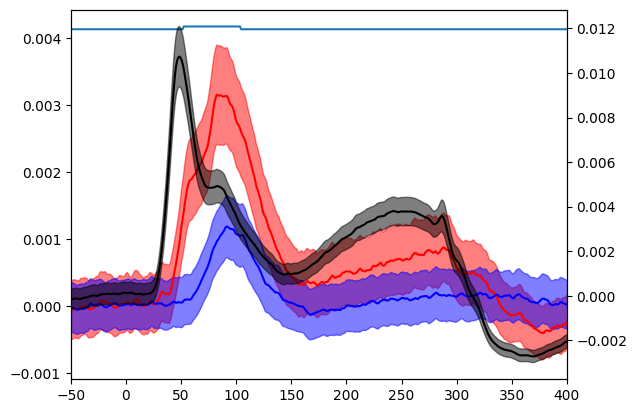

In [ ]:
cp_rf_array = np.concatenate(cp_rf)
cp_no_rf_array = np.concatenate(cp_no_rf)
v1_array = np.concatenate(v1)

print(f'CP RF: {cp_rf_array.shape[0]}')
print(f'CP No RF: {cp_no_rf_array.shape[0]}')
print(f'V1: {v1_array.shape[0]}')

mean0 = lambda x: np.mean(x, axis=0)
sem0 = lambda x: np.std(x, axis=0)/x.shape[0]**0.5
time = np.linspace(-250, 500, 750)

fig, ax = plt.subplots()
ax2 = ax.twinx()
colors = ['r', 'b', 'k']
for array, color, a in zip([cp_rf_array, cp_no_rf_array, v1_array], colors, [ax, ax, ax2]):

    mean = mean0(array)
    sem = sem0(array)

    a.plot(time, mean, color=color)
    a.fill_between(time, mean-sem, mean+sem, color=color, alpha=0.5)

ax.set_xlim([-50, 400])

cp_rf_no_rf_pval = [scipy.stats.ranksums(rf_time, no_rf_time)[1] for rf_time, no_rf_time in zip(cp_rf_array.T, cp_no_rf_array.T)]
corrected_sig = statsmodels.stats.multitest.fdrcorrection(cp_rf_no_rf_pval)[0]
ylim = ax.get_ylim()
ax.plot(time, corrected_sig*ylim[1]*0.01+ylim[1])

#fig.savefig('v1_cp_rf_norf_mean_response.pdf')


In [68]:
v1_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_VISp_bursts.hdf5"
v1_random_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_VISp_random_times.hdf5"
v1_tensor = h5py.File(v1_tensor_file)
v1_random_tensor = h5py.File(v1_random_tensor_file)

# m1_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_MOp_bursts.hdf5"
# m1_tensor = h5py.File(m1_tensor_file)

In [72]:
sem = lambda x: np.std(x, axis=0)/len(x)**0.5
mean0 = lambda x: np.mean(x, axis=0)
unpack_lists = lambda x: [ss for s in x for ss in s]
base_sub_array = lambda x: x - np.mean(x, axis=1)[:, None]

for area_of_interest in ['CP']:

    sessions = session_dict['VISp'][area_of_interest]
    rf_coherence = []
    no_rf_coherence = []
    rf_mean = []
    no_rf_mean = []
    for session_id in sessions:
        session_tensor = v1_tensor[session_id]
        session_random_tensor = v1_random_tensor[session_id]

        sess_ccgs = session_data[session_id]['ccgs']['VISp']['VISp']
        good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)

        session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
        v1_sess_tensor = tu.get_tensor_by_unit_ids(session_units[session_units['structure_acronym']=='VISp']['unit_id'].values, session_tensor)

        v1_means = np.mean(v1_sess_tensor, axis=0)
        v1_mean_binned = np.mean(np.reshape(v1_means, (v1_means.shape[0], 400, 10)), axis=2)

        area_units = session_units[session_units['structure_acronym']==area_of_interest]

        # if area_units['is_sig_rf'].sum()<10:
        #     continue


        for rf_or_not, coh_agg, mean_agg in zip([area_units['is_sig_rf'], ~area_units['is_sig_rf']], [rf_coherence, no_rf_coherence], [rf_mean, no_rf_mean]):

            if np.sum(rf_or_not)==0:
                continue

            rf_area_tensor = tu.get_tensor_by_unit_ids(area_units[rf_or_not]['unit_id'].values, session_tensor)
            rf_area_random_tensor = tu.get_tensor_by_unit_ids(area_units[rf_or_not]['unit_id'].values, session_random_tensor)
            
            mean = np.mean(rf_area_tensor, axis=0)
            mean_binned = np.mean(np.reshape(mean, (mean.shape[0], 400, 10)), axis=2)
            print(rf_area_tensor.shape)
            freqs, coh = multi_taper_coherence(base_sub_array(mean_binned[good_traces]), base_sub(v1_mean_binned[good_traces]), fs=100)

            random_mean = np.mean(rf_area_random_tensor, axis=0)
            random_mean_binned = np.mean(np.reshape(random_mean, (random_mean.shape[0], 400, 10)), axis=2)
            freqs, rand_coh = multi_taper_coherence(base_sub_array(random_mean_binned[good_traces]), base_sub_array(v1_mean_binned[good_traces]), fs=100)


            coh_agg.append(np.array(coh) - np.array(rand_coh))
            mean_agg.append(mean_binned[good_traces])

    if len(rf_coherence)==0:
        continue
    
    rf_coherence = np.array(unpack_lists(rf_coherence))
    rf_coherence = np.array([r for r in rf_coherence if not np.any(np.isnan(r))])
    no_rf_coherence = np.array(unpack_lists(no_rf_coherence))
    #diff = rf_coherence - no_rf_coherence

    rf_mean = np.array(unpack_lists(rf_mean))
    no_rf_mean = np.array(unpack_lists(no_rf_mean))


    area_rf_coh = np.nanmean(rf_coherence, axis=0)
    area_rf_coh_sem = np.nanstd(rf_coherence, axis=0)/len(rf_coherence)**0.5
    area_no_rf_coh = np.nanmean(no_rf_coherence, axis=0)
    area_no_rf_coh_sem = np.nanstd(no_rf_coherence, axis=0)/len(no_rf_coherence)**0.5

    # diff_mean = np.mean(diff, axis=0)
    # diff_sem = np.std(diff, axis=0)/diff.shape[0]**0.5


    rf_mean_basesub = base_sub_array(rf_mean)
    no_rf_mean_basesub = base_sub_array(no_rf_mean)

    rf_mean_trace = np.mean(rf_mean, axis=0)
    no_rf_mean_trace = np.mean(no_rf_mean_basesub, axis=0)


(19, 96, 4000)
(56, 96, 4000)
(24, 342, 4000)
(16, 342, 4000)
(23, 250, 4000)
(36, 250, 4000)
(13, 80, 4000)
(25, 80, 4000)
(1, 10, 4000)
(72, 10, 4000)


In [70]:
ind_band_low = np.searchsorted(freqs, 3)
ind_band_high = np.searchsorted(freqs, 7)

rf_band = np.mean(rf_coherence[:, ind_band_low:ind_band_high], axis=1)
no_rf_band = np.mean(no_rf_coherence[:, ind_band_low:ind_band_high], axis=1)

scipy.stats.wilcoxon(rf_band, no_rf_band)


WilcoxonResult(statistic=28158.0, pvalue=3.760576319098457e-14)

CP RF coherence: (201,)
CP No RF coherence: (439, 250)
CP RF 4Hz mean: (439, 250)
CP No RF 4Hz mean: (439, 250)


(-0.5, 1.5)

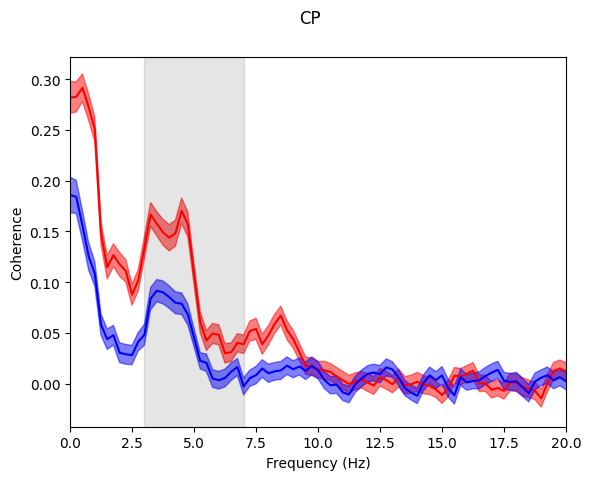

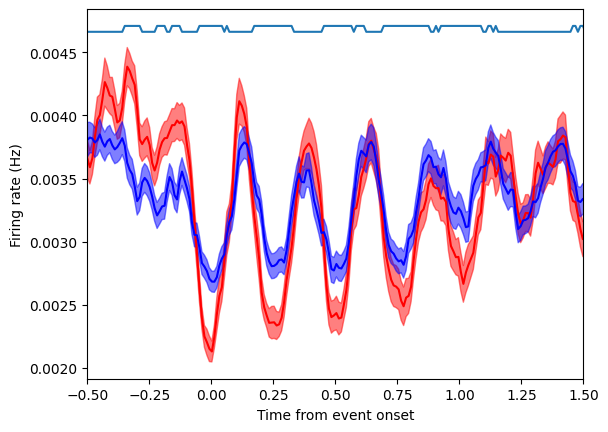

In [71]:
sem = lambda x: np.std(x, axis=0)/len(x)**0.5
mean0 = lambda x: np.mean(x, axis=0)
unpack_lists = lambda x: [ss for s in x for ss in s]
base_sub_array = lambda x: x - np.mean(x, axis=1)[:, None]

fig, ax = plt.subplots()
fig.suptitle(area_of_interest)

ax.plot(freqs, area_rf_coh, 'r')
ax.fill_between(freqs, area_rf_coh+area_rf_coh_sem, area_rf_coh-area_rf_coh_sem, color='r', alpha=0.5)
ax.plot(freqs, area_no_rf_coh, 'b')
ax.fill_between(freqs, area_no_rf_coh+area_no_rf_coh_sem, area_no_rf_coh-area_no_rf_coh_sem, color='b', alpha=0.5)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coherence')
# ax.plot(freqs, diff_mean)
# ax.fill_between(freqs, diff_mean - diff_sem, diff_mean+diff_sem, alpha=0.5)
ax.axvspan(3,7, color='k', alpha=0.1)
ax.set_xlim(0,20)
fig.savefig('CP_rf_norf_coherence.pdf')

rf_mean_basesub = base_sub_array(rf_mean)[:, 150:]
no_rf_mean_basesub = base_sub_array(no_rf_mean)[:, 150:]

rf_mean_basesub = rf_mean[:, 150:]
no_rf_mean_basesub = no_rf_mean[:, 150:]

rf_mean_basesub = np.array([exponential_convolve(r) for r in rf_mean_basesub])
no_rf_mean_basesub = np.array([exponential_convolve(r) for r in no_rf_mean_basesub])

mean_sig_pvalues = np.array([scipy.stats.wilcoxon(rf_time, no_rf_time)[1] for rf_time, no_rf_time in zip(rf_mean_basesub.T, no_rf_mean_basesub.T)])
corrected_sig = statsmodels.stats.multitest.fdrcorrection(mean_sig_pvalues)[0]



print(f'CP RF coherence: {area_rf_coh.shape}')
print(f'CP No RF coherence: {no_rf_mean_basesub.shape}')
print(f'CP RF 4Hz mean: {rf_mean_basesub.shape}')
print(f'CP No RF 4Hz mean: {no_rf_mean_basesub.shape}')
 
time = np.linspace(-0.5, 2, 250)
fig, ax = plt.subplots()
ax.plot(time, (mean0(rf_mean_basesub)), 'r')
ax.fill_between(time, mean0(rf_mean_basesub)+sem(rf_mean_basesub), mean0(rf_mean_basesub)-sem(rf_mean_basesub), color='r', alpha=0.5)
ax.plot(time, mean0(no_rf_mean_basesub), 'b')
ax.fill_between(time, mean0(no_rf_mean_basesub)+sem(no_rf_mean_basesub), mean0(no_rf_mean_basesub)-sem(no_rf_mean_basesub), color='b', alpha=0.5)
ylim = ax.get_ylim()
ax.plot(time, corrected_sig*ylim[1]*0.01+ylim[1])

ax.set_xlabel('Time from event onset')
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlim(-0.5, 1.5)

#fig.savefig('CP_rf_norf_mean_trace.pdf')


## Looking at individual units

In [50]:
num_v1_bursts = [len(p) for p in psth_dict['VISp']['VISp']]
for num, sess in zip(num_v1_bursts, session_dict['VISp']['VISp']):
    print(f'session {sess}: {num}')

session 1175253205: 11
session 1177900858: 185
session 1178173272: 502
session 1178460518: 202
session 1178693650: 238
session 1182427414: 7
session 1182628226: 61
session 1182871514: 258
session 1183071525: 102
session 1194850630: 9
session 1195036753: 9
session 1200659846: 14
session 1211232400: 7
session 1214566710: 6


In [ ]:
def get_preimage_burst_response_arrays(session_units, session_task_tensor, session_burst_tensor, area_of_interest, session_stims_before_bursts,
                                        vis_slice = slice(270,520), burst_slice=slice(2000,2250)):

    area_sess_burst_tensor = tu.get_tensor_by_unit_ids(session_units[session_units['structure_acronym']==area_of_interest]['unit_id'].values, 
                                                        session_burst_tensor)
    area_sess_stim_tensor = tu.get_tensor_by_unit_ids(session_units[session_units['structure_acronym']==area_of_interest]['unit_id'].values, 
                                                        session_task_tensor)
    pre_image_firing_rates = []
    burst_firing_rates = []
    image_ids = []
    stim_tensor_inds = []
    burst_tensor_inds = []
    for ind, row in session_stims_before_bursts.iterrows():
        if not row['qualifying']:
            continue

        if row['burst_time'] - row['start_time']>0.55:
            continue

        if row['burst_time'] - row['start_time']<0.25:
            continue

        if row['omitted']:
            continue

        

        stim_trial_response = np.mean(area_sess_stim_tensor[:, row['index']][:, 270:520], axis=1)# - np.mean(v1_sess_stim_tensor[:, row['index']][:, 200:250], axis=1)
        burst_trial_response = np.mean(area_sess_burst_tensor[:, row['tensor_burst_ind']][:, 2000:2250], axis=1)

        pre_image_firing_rates.append(stim_trial_response)
        burst_firing_rates.append(burst_trial_response)
        image_ids.append(row['image_name'])
        stim_tensor_inds.append(row['index'])
        burst_tensor_inds.append(row['tensor_burst_ind'])
    
    return np.array(pre_image_firing_rates), np.array(burst_firing_rates)

In [51]:
sessions_with_many_v1_bouts = [session_dict['VISp']['VISp'][ind] for ind, num in enumerate(num_v1_bursts) if num>50]
sessions_with_many_v1_bouts

['1177900858',
 '1178173272',
 '1178460518',
 '1178693650',
 '1182628226',
 '1182871514',
 '1183071525']

In [2055]:
session_dict['VISp']['CP']

['1182628226', '1182871514', '1183071525', '1194850630', '1195036753']

In [2347]:
session_id = '1183071525'
session_burst_tensor = burst_tensor[session_id]
session_task_tensor = task_tensor[session_id]

session_burst_times = np.load(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\session_analysis',
                                session_id, 'VISp_burst_times.npy'))
sess_ccgs = session_data[session_id]['ccgs']['VISp']['VISp']
good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)


In [2348]:
session_stim = master_stim[master_stim['session_id']==int(session_id)].sort_values(by='start_time')
inds_before_bursts = np.searchsorted(session_stim['start_time'].values, session_burst_times) - 1
good_inds = (inds_before_bursts<len(session_stim))&(inds_before_bursts>-1)
session_stims_before_bursts = session_stim.iloc[inds_before_bursts[good_inds]]

In [2349]:
session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
burst_tensor_inds = np.arange(len(session_burst_times))[good_inds]
session_stims_before_bursts['tensor_burst_ind'] = burst_tensor_inds
session_stims_before_bursts['qualifying'] = good_traces[good_inds]

session_stims_before_bursts[['index', 'start_time', 'burst_time', 'tensor_burst_ind', 'qualifying']]

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\4292460551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\4292460551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['tensor_burst_ind'] = burst_tensor_inds
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\4292460551.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

index   start_time  burst_time  tensor_burst_ind  qualifying
15629     35    64.762613       65.18                 0       False
15656     62    85.046206       85.27                 1       False
15755    161   159.391637      159.58                 2       False
15770    176   170.667733      171.07                 3        True
15853    259   232.969769      233.18                 4       False
...      ...          ...         ...               ...         ...
20718   5124  3885.339786     3885.52               245       False
20765   5171  3920.635973     3920.82               246       False
20779   5185  3931.144753     3931.55               247        True
20788   5194  3937.900423     4682.29               248        True
20788   5194  3937.900423     5338.14               249        True

[250 rows x 5 columns]

In [2350]:
session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
session_units = session_units.sort_values(by='dorsal_ventral_ccf_coordinate')
v1_sess_burst_tensor = tu.get_tensor_by_unit_ids(session_units[session_units['structure_acronym']=='CP']['unit_id'].values, session_burst_tensor)
v1_sess_stim_tensor = tu.get_tensor_by_unit_ids(session_units[session_units['structure_acronym']=='CP']['unit_id'].values, session_task_tensor)
tensor_unit_ids = session_units[session_units['structure_acronym']=='CP']['unit_id'].values

In [2351]:
#correct indexing into tensor for 4 sessions with omission bug
if session_id in ['1234203203',
                    '1176989662',
                    '1178460518',
                    '1232954220',
                    ]:

    session_stims_before_bursts['index'] = session_stims_before_bursts['index'] + 1

(187302.3267524168, 187552.3267524168)

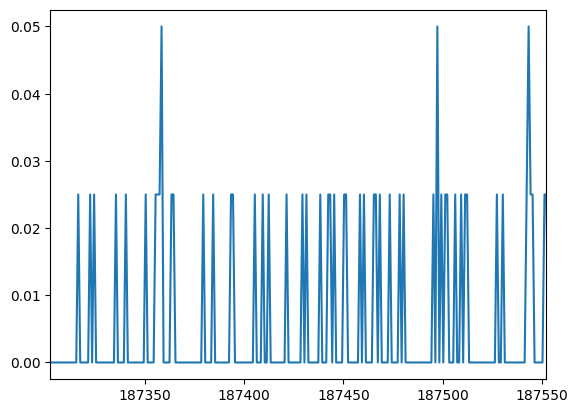

In [2313]:
ind_to_plot = 2

stim_trial_ind = session_stims_before_bursts['index'].iloc[ind_to_plot]
burst_trial_ind = session_stims_before_bursts['tensor_burst_ind'].iloc[ind_to_plot]

time = np.arange(-250, 500) + 1000*session_stims_before_bursts.iloc[ind_to_plot]['start_time']
fig, ax = plt.subplots()
ax.plot(time, np.mean(v1_sess_stim_tensor[:, stim_trial_ind], axis=0))
ax.set_xlim(time[250], time[250]+250)


(281220.0, 281470.0)

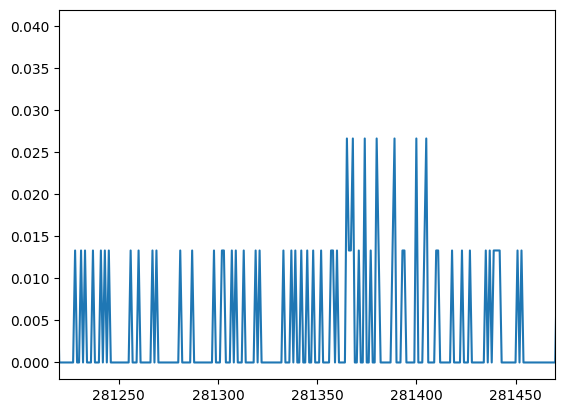

In [1863]:
fig, ax = plt.subplots()
time = np.arange(-2000, 2000) + session_burst_times[burst_trial_ind]*1000
ax.plot(time, np.mean(v1_sess_burst_tensor[:, burst_trial_ind], axis=0))
ax.set_xlim(time[2000], time[2000]+250)


In [ ]:
cp_units = session_units[session_units['structure_acronym']=='CP']
cp_units.head()

In [54]:
v1_responses = get_preimage_burst_response_arrays(session_units, session_task_tensor, session_burst_tensor, 'VISp',session_stims_before_bursts)
lgd_responses = get_preimage_burst_response_arrays(session_units, session_task_tensor, session_burst_tensor, 'VISl',session_stims_before_bursts)

NameError: name 'session_units' is not defined

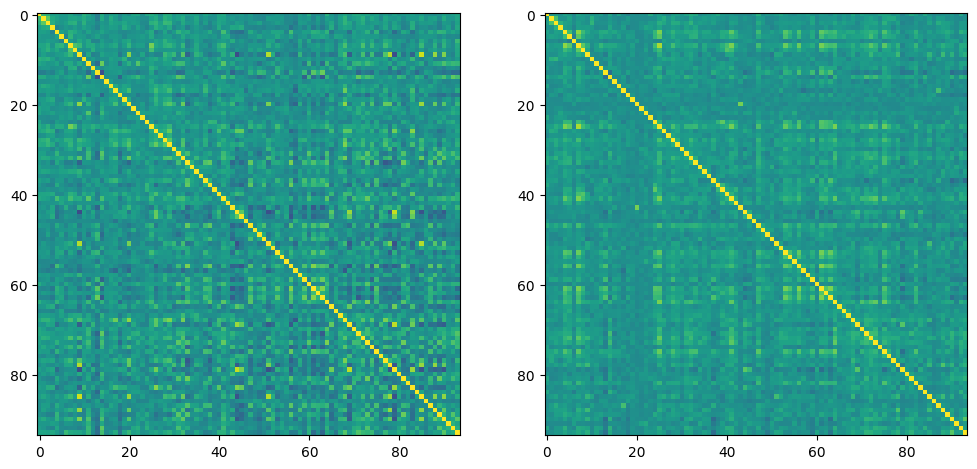

In [1849]:
v1_lgd_stim = np.concatenate([v1_responses[0], lgd_responses[0]], axis=1)
v1_lgd_burst = np.concatenate([v1_responses[1], lgd_responses[1]], axis=1)

fig, ax = plt.subplots(1,2)
fig.set_size_inches([12,6])
v1_lgd_stim_corr = np.corrcoef(v1_lgd_stim.T)
v1_lgd_burst_corr = np.corrcoef(v1_lgd_burst.T)
ax[0].imshow(v1_lgd_stim_corr, clim=[-1,1])
ax[1].imshow(v1_lgd_burst_corr, clim=[-1,1])

In [1844]:
v1_responses[0].shape[1]

94

In [1845]:
v1_to_lgn_stim_corr = v1_lgd_stim_corr[v1_responses[0].shape[1]:,:v1_responses[0].shape[1]]
v1_to_lgd_burst_corr = v1_lgd_burst_corr[v1_responses[0].shape[1]:,:v1_responses[0].shape[1]]

print(np.nanmedian(v1_to_lgn_stim_corr), np.nanmedian(v1_to_lgd_burst_corr))
print(np.nanmedian(v1_lgd_stim_corr[:v1_responses[0].shape[1], :v1_responses[0].shape[1]]), np.nanmedian(v1_lgd_burst_corr[:v1_responses[0].shape[1], :v1_responses[0].shape[1]]))

0.03697963394532993 0.05148324750470913
0.04245124436189473 0.05154111998840764


Text(0, 0.5, 'Response to subsequent 4Hz event')

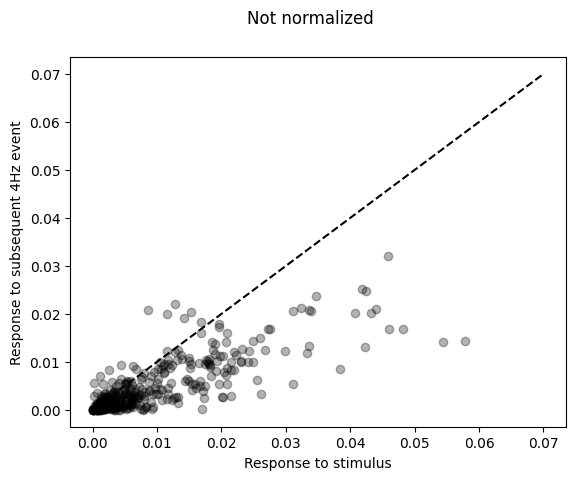

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Not normalized')
for unit in range(burst_image_tuning_norm_sorted.shape[1]):
    imresp = image_tuning_sorted[:, unit]
    burstresp = burst_image_tuning_sorted[:, unit]
    ax.plot(imresp, burstresp, 'ko', alpha=0.3)

ax.plot([0,0.07], [0,0.07], 'k--')
ax.set_xlabel('Response to stimulus')
ax.set_ylabel('Response to subsequent 4Hz event')


In [2352]:
pre_image_firing_rates = []
burst_firing_rates = []
image_ids = []
stim_tensor_inds = []
burst_tensor_inds = []
for ind, row in session_stims_before_bursts.iterrows():
    if not row['qualifying']:
        continue

    if row['burst_time'] - row['start_time']>0.55:
        continue

    if row['burst_time'] - row['start_time']<0.25:
        continue

    if row['omitted']:
        continue


    stim_trial_response = np.mean(v1_sess_stim_tensor[:, row['index']][:, 270:520], axis=1) - np.mean(v1_sess_stim_tensor[:, row['index']][:, 200:250], axis=1)
    burst_trial_response = np.mean(v1_sess_burst_tensor[:, row['tensor_burst_ind']][:, 2000:2250], axis=1) - np.mean(v1_sess_burst_tensor[:, row['tensor_burst_ind']][:, 1750:2000], axis=1)

    pre_image_firing_rates.append(stim_trial_response)
    burst_firing_rates.append(burst_trial_response)
    image_ids.append(row['image_name'])
    stim_tensor_inds.append(row['index'])
    burst_tensor_inds.append(row['tensor_burst_ind'])

In [2160]:
burst_firing_rates = np.array(burst_firing_rates)
pre_image_firing_rates = np.array(pre_image_firing_rates)

plt.plot(np.mean(pre_image_firing_rates[:, sig_rf], axis=0), np.mean(burst_firing_rates[:, sig_rf], axis=0), 'ko')
plt.plot(np.mean(pre_image_firing_rates[:, np.invert(sig_rf)], axis=0), np.mean(burst_firing_rates[:, np.invert(sig_rf)], axis=0), 'ro')


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [1691]:
bin_spike_array = lambda x: np.mean(x.reshape(x.shape[0], -1, 10), axis=2)

determine_visually_responsive_array(bin_spike_array(unit[tensor_inds]))

False

In [1854]:
rf_dir = r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\rf_mats'
def get_unit_rf(unitid, rf_dir=rf_dir):
    try:
        rf = np.load(os.path.join(rf_dir, str(unitid) + '.npy'))
    except:
        rf = np.full((9,9), np.nan)
    return rf

In [2188]:
bin_spikes = lambda x: np.mean(x.reshape(-1, 10), axis=1)
bin_spike_array = lambda x: np.mean(x.reshape(x.shape[0], -1, 10), axis=2)

def get_image_burst_responses(session_units, session_task_tensor, session_burst_tensor, area_of_interest, session_stims_before_bursts,
                                        vis_slice = slice(270,520), burst_slice=slice(2000,2250)):

    tensor_unit_ids = session_units[session_units['structure_acronym']==area_of_interest]['unit_id'].values

    area_sess_burst_tensor = tu.get_tensor_by_unit_ids(tensor_unit_ids, session_burst_tensor)
    area_sess_stim_tensor = tu.get_tensor_by_unit_ids(tensor_unit_ids, session_task_tensor)

    unit_tuning_responses = []
    sig_response = []
    sig_rf = []
    urfs = []

    for unit, unitid in zip(area_sess_stim_tensor, tensor_unit_ids):
        unit_image_responses = []
        image_sig = []
        for image in np.unique(image_ids):

            image_inds = np.array(image_ids)==image
            tensor_inds = np.array(stim_tensor_inds)[image_inds]
            
            unit_resp_array = bin_spike_array(unit[tensor_inds])
            unit_resp = bin_spikes(np.mean(unit[tensor_inds], axis=0))
            #image_sig.append(determine_visually_responsive(unit_resp))
            image_sig.append(determine_visually_responsive_array(unit_resp_array))
            unit_image_responses.append(unit_resp)
        
        sig_response.append(np.any(image_sig))
        unit_tuning_responses.append(unit_image_responses)

        urf_sig = session_units[session_units['unit_id']==unitid]['is_sig_rf'].values
        sig_rf.append(urf_sig)
        urf = get_unit_rf(unitid)
        urfs.append(urf)

    unit_burst_tuning_responses = []
    for unit in area_sess_burst_tensor:
        unit_burst_responses = []
        for image in np.unique(image_ids):

            image_inds = np.array(image_ids)==image
            tensor_inds = np.array(burst_tensor_inds)[image_inds]


            unit_resp = bin_spikes(np.mean(unit[tensor_inds], axis=0))

            unit_burst_responses.append(unit_resp)
        
        unit_burst_tuning_responses.append(unit_burst_responses)


    unit_tuning_responses = np.array(unit_tuning_responses)
    unit_burst_tuning_responses = np.array(unit_burst_tuning_responses)
    sig_rf = np.array(sig_rf).flatten()

    return unit_tuning_responses, unit_burst_tuning_responses, sig_rf

In [2353]:
cp_responses = get_image_burst_responses(session_units, session_task_tensor, session_burst_tensor, 'CP', session_stims_before_bursts)
v1_responses = get_image_burst_responses(session_units, session_task_tensor, session_burst_tensor, 'VISp', session_stims_before_bursts)

c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\scipy\stats\_stats_py.py:8380: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return ks_2samp(xvals, yvals, alternative=alternative, method=method)


In [2372]:
units_to_plot = session_units[(session_units['structure_acronym']=='CP')&(session_units['is_sig_rf'])]['unit_id'].values
resp = get_image_response(units_to_plot, session_task_tensor, session_burst_tensor)

In [2368]:
bin_spikes = lambda x: np.mean(x.reshape(-1, 10), axis=1)
bin_spike_array = lambda x: np.mean(x.reshape(x.shape[0], -1, 10), axis=2)

unit_tuning_responses = []
sig_response = []
sig_rf = []
urfs = []

for unit, unitid in zip(v1_sess_stim_tensor, tensor_unit_ids):
    unit_image_responses = []
    image_sig = []
    for image in np.unique(image_ids):

        image_inds = np.array(image_ids)==image
        tensor_inds = np.array(stim_tensor_inds)[image_inds]

        unit_resp_array = bin_spike_array(unit[tensor_inds])
        unit_resp = bin_spikes(np.mean(unit[tensor_inds], axis=0))
        #image_sig.append(determine_visually_responsive(unit_resp))
        image_sig.append(determine_visually_responsive_array(unit_resp_array))
        unit_image_responses.append(unit_resp)
    
    sig_response.append(np.any(image_sig))
    unit_tuning_responses.append(unit_image_responses)

    urf_sig = session_units[session_units['unit_id']==unitid]['is_sig_rf'].values
    sig_rf.append(urf_sig)
    urf = get_unit_rf(unitid)
    urfs.append(urf)

unit_burst_tuning_responses = []
for unit in v1_sess_burst_tensor:
    unit_burst_responses = []
    for image in np.unique(image_ids):

        image_inds = np.array(image_ids)==image
        tensor_inds = np.array(burst_tensor_inds)[image_inds]


        unit_resp = bin_spikes(np.mean(unit[tensor_inds], axis=0))

        unit_burst_responses.append(unit_resp)
    
    unit_burst_tuning_responses.append(unit_burst_responses)


unit_tuning_responses = np.array(unit_tuning_responses)
unit_burst_tuning_responses = np.array(unit_burst_tuning_responses)
sig_rf = np.array(sig_rf).flatten()

c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\scipy\stats\_stats_py.py:8380: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return ks_2samp(xvals, yvals, alternative=alternative, method=method)


In [ ]:
unit = v1_sess_stim_tensor[3]
for image in np.unique(image_ids):

    image_inds = np.array(image_ids)==image
    tensor_inds = np.array(stim_tensor_inds)[image_inds]

    unit_resp_array = bin_spike_array(unit[tensor_inds])
    plt.figure()
    plt.plot(unit_resp_array.T)
    unit_resp = bin_spikes(np.mean(unit[tensor_inds], axis=0))
    #image_sig.append(determine_visually_responsive(unit_resp))
    image_sig.append(determine_visually_responsive_array(unit_resp_array))
    unit_image_responses.append(unit_resp)


In [2132]:
def plot_raster(tensor_trials, time, ax):
    for it, trial in enumerate(tensor_trials):
        sts = np.where(trial)
        if len(sts)>0:
            sts = sts[0] + time[0]
            ax.eventplot(sts, orientation='horizontal', lineoffsets=it, colors='k')
    
    ax.set_xlim(time[0], time[-1])

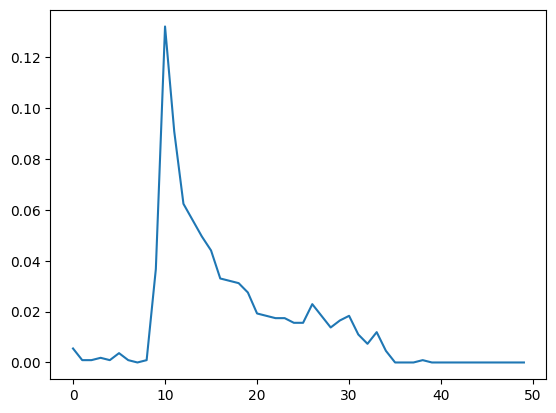

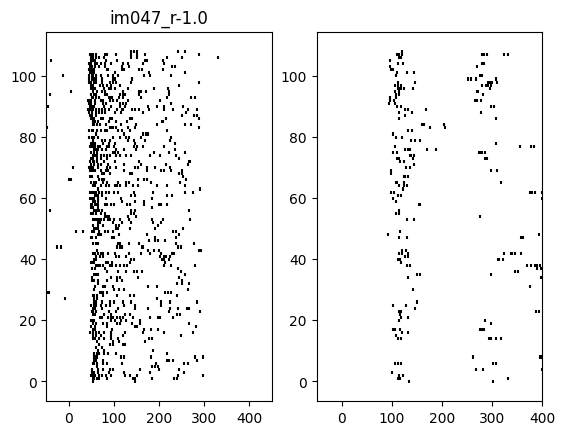

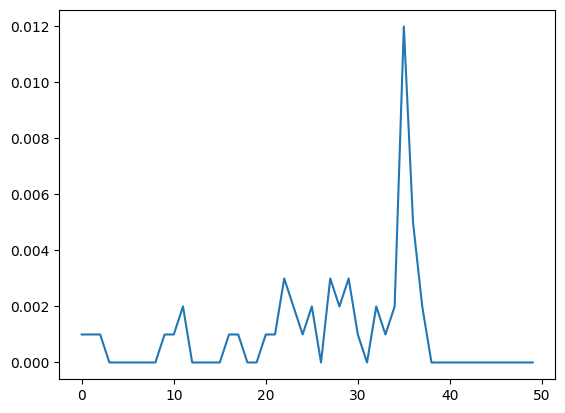

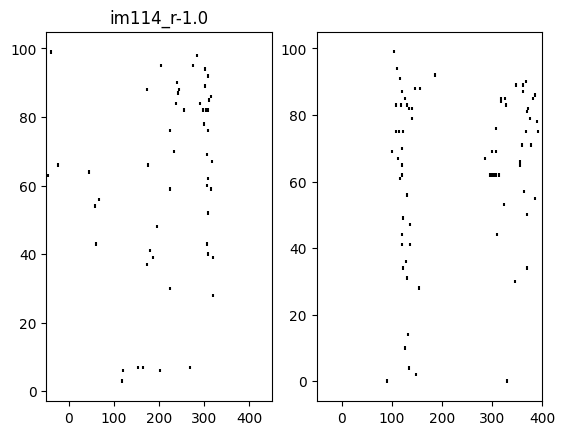

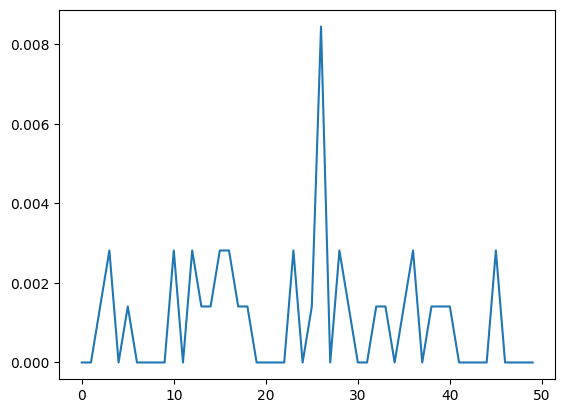

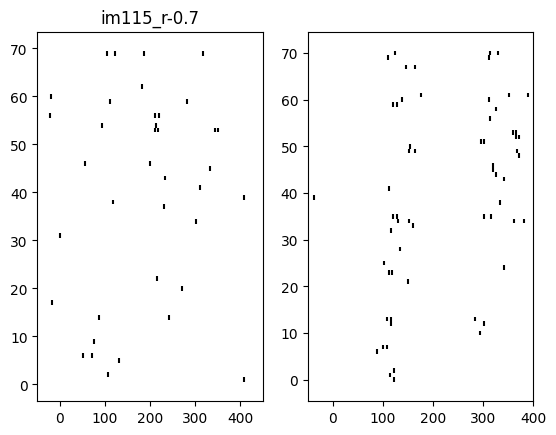

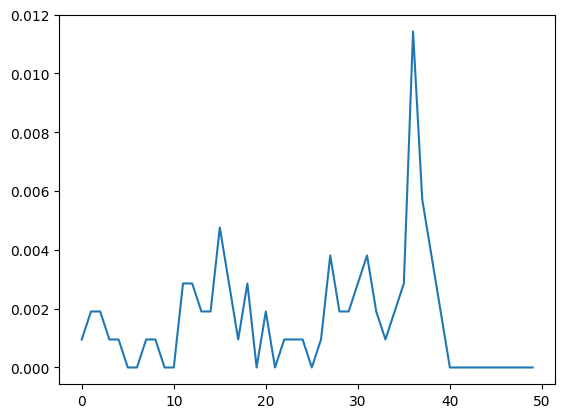

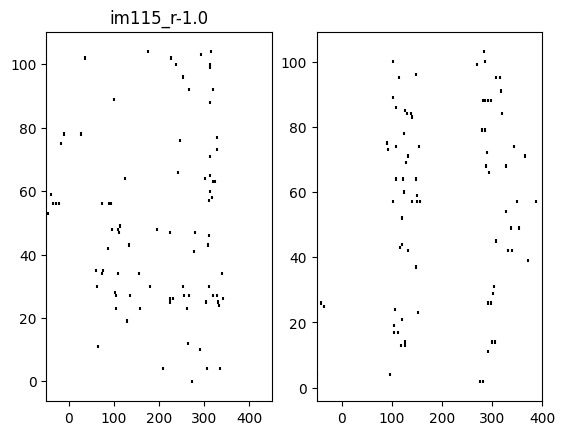

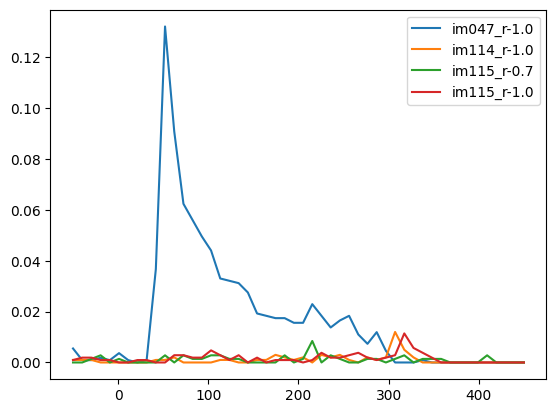

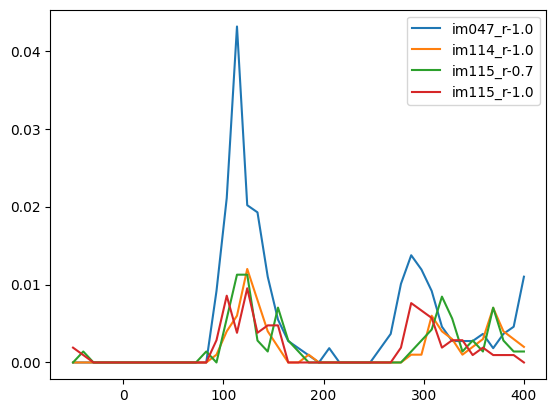

In [2149]:
unit_to_plot = 12621
unit_tensor_index = np.where(tensor_unit_ids==unit_to_plot)[0][0]
unit = v1_sess_stim_tensor[unit_tensor_index]
unit_burst = v1_sess_burst_tensor[unit_tensor_index]
vis_response_slice = slice(200, 700)
time = np.linspace(vis_response_slice.start-250, vis_response_slice.stop-250, vis_response_slice.stop-vis_response_slice.start)

burst_slice = slice(1950, 2400)
burst_time = np.linspace(burst_slice.start-2000, burst_slice.stop-2000, burst_slice.stop-burst_slice.start)

mean_resps = []
mean_burst_resps = []
for image in np.unique(image_ids):

    image_inds = np.array(image_ids)==image
    tensor_inds = np.array(stim_tensor_inds)[image_inds]
    burst_inds = np.array(burst_tensor_inds)[image_inds]

    unit_resp_array = bin_spike_array(unit[tensor_inds][:, vis_response_slice])
    fig, ax = plt.subplots()
    ax.plot(np.mean(unit_resp_array, axis=0))
    

    fig, ax = plt.subplots(1, 2)
    plot_raster(unit[tensor_inds][:, vis_response_slice], time, ax[0])
    ax[0].set_title(image)
    
    plot_raster(unit_burst[burst_inds][:, burst_slice], burst_time, ax[1])

    fig.savefig(f'Unit_{unit_to_plot}_session_{session_id}_image_{image}_raster.pdf')

    mean_resps.append(np.mean(unit_resp_array, axis=0))

    burst_resp_array = bin_spike_array(unit_burst[burst_inds][:, burst_slice])
    mean_burst_resps.append(np.mean(burst_resp_array, axis=0))


fig, ax = plt.subplots()
ax.plot(np.linspace(vis_response_slice.start-250, vis_response_slice.stop-250, 50), np.array(mean_resps).T)
ax.legend(np.unique(image_ids))
fig.savefig(f'Unit_{unit_to_plot}_session_{session_id}_mean_resp_by_image.pdf')

fig, ax = plt.subplots()
ax.plot(np.linspace(burst_slice.start-2000, burst_slice.stop-2000, 45), np.array(mean_burst_resps).T)
ax.legend(np.unique(image_ids))
fig.savefig(f'Unit_{unit_to_plot}_session_{session_id}_mean_burstresp_by_image.pdf')


In [2051]:
unit_stim_tuning_curves = np.mean(unit_tuning_responses[:, :, 27:52], axis=2) - np.mean(unit_tuning_responses[:, :, 2:27], axis=2)
unit_burst_tuning_curves = np.mean(unit_burst_tuning_responses[:, :, 200:225], axis=2) - np.mean(unit_burst_tuning_responses[:, :, 175:200], axis=2)

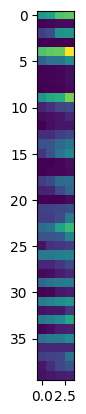

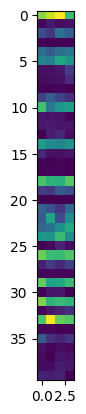

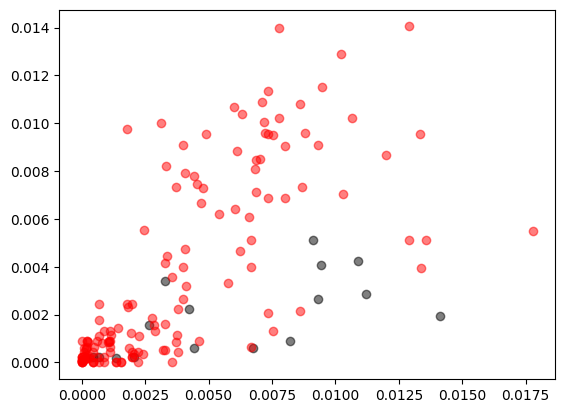

In [1896]:
index_array = np.argsort(unit_stim_tuning_curves, axis=1)

image_tuning_sorted = np.take_along_axis(unit_stim_tuning_curves, index_array, axis=1)
burst_image_tuning_sorted = np.take_along_axis(unit_burst_tuning_curves, index_array, axis=1)

plt.figure()
plt.imshow(image_tuning_sorted)

plt.figure()
plt.imshow(burst_image_tuning_sorted)

plt.figure()
plt.plot(image_tuning_sorted[sig_response].flatten(), burst_image_tuning_sorted[sig_response].flatten(), 'ko', alpha=0.5)
plt.plot(image_tuning_sorted[np.invert(sig_response)].flatten(), burst_image_tuning_sorted[np.invert(sig_response)].flatten(), 'ro', alpha=0.5)

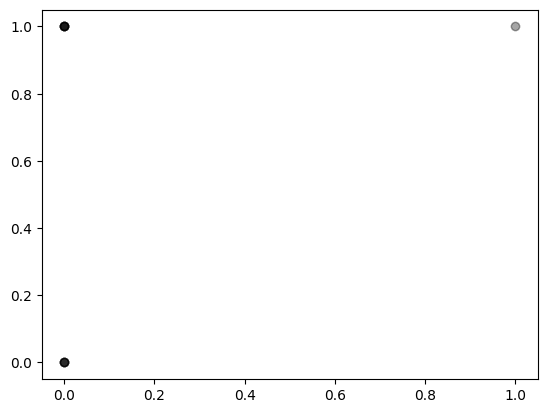

In [1913]:
plt.plot(sig_response, sig_rf, 'ko', alpha=0.1)

In [1731]:
norm = lambda x: x/np.max(x, axis=1)[:, None]

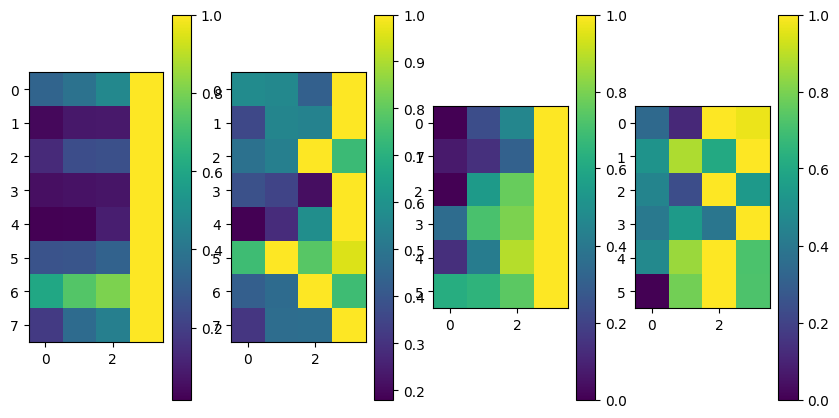

In [1732]:
fig, ax = plt.subplots(1,4)
fig.set_size_inches([10,5])

im1 = ax[0].imshow(norm(image_tuning_sorted[sig_response]))
im2 = ax[1].imshow(norm(burst_image_tuning_sorted[sig_response]))

im3 = ax[2].imshow(norm(image_tuning_sorted[np.invert(sig_response)]))
im4 = ax[3].imshow(norm(burst_image_tuning_sorted[np.invert(sig_response)]))

[plt.colorbar(im, ax=a) for a, im in zip(ax, [im1, im2, im3, im4])]

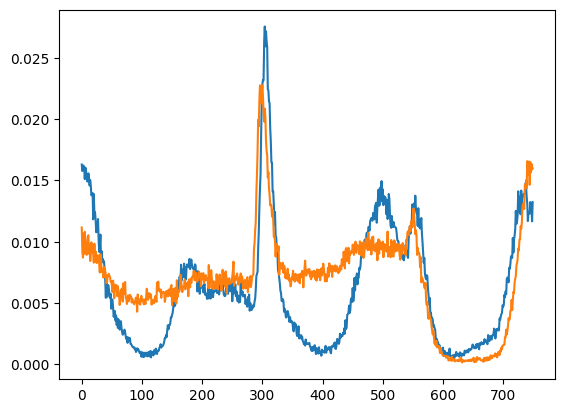

In [1480]:
plt.plot(np.mean(v1_sess_stim_tensor[:, np.array(stim_tensor_inds)+1], axis=(0,1)))
plt.plot(np.mean(v1_sess_stim_tensor[:, np.array(stim_tensor_inds)], axis=(0,1)))

ax = plt.gca()
#ax.set_xlim(200,300)

In [1419]:
meanv1resp = np.mean(v1_sess_stim_tensor, axis=(0,1))
np.mean(meanv1resp[270:520]) - np.mean(meanv1resp[200:250])

0.002732742407640606

In [1423]:
np.mean(meanv1resp[270:520])

0.009977987472811423

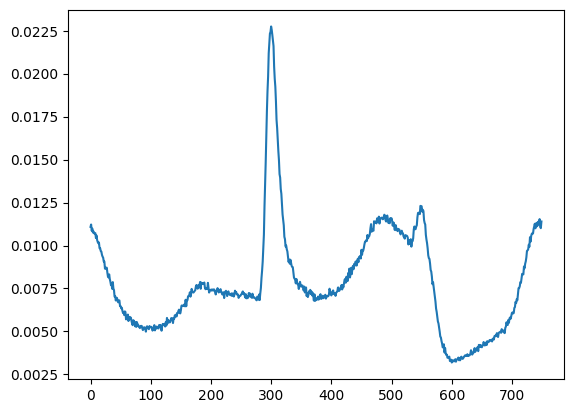

In [1420]:
plt.plot(meanv1resp)

In [1418]:
np.mean(flatten_list(pre_image_firing_rates))

0.0025708759325780606

In [1412]:
flatten_list = lambda listlist: [v for sub in listlist for v in sub]

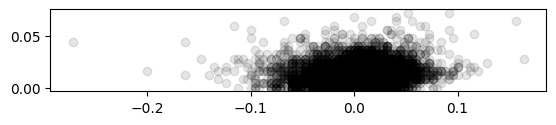

In [1417]:
fig, ax = plt.subplots()
ax.plot(flatten_list(pre_image_firing_rates), flatten_list(burst_firing_rates), 'ko', alpha=0.1)
ax.set_aspect('equal')

In [1223]:
overall_fr = session_units[session_units['structure_acronym']=='LGd']['firing_rate']


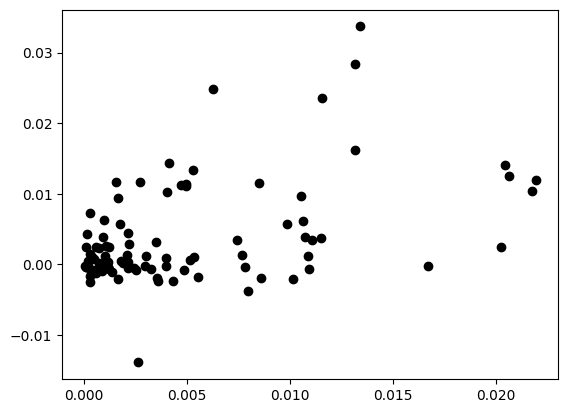

In [1395]:
plt.plot(np.mean(burst_firing_rates, axis=0),np.mean(pre_image_firing_rates, axis=0), 'ko')

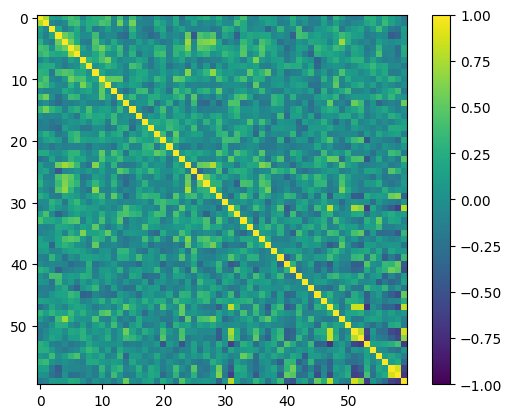

In [1777]:
fig, ax = plt.subplots()
im = ax.imshow(np.corrcoef(np.array(pre_image_firing_rates).T), clim=[-1,1])
plt.colorbar(im)

c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


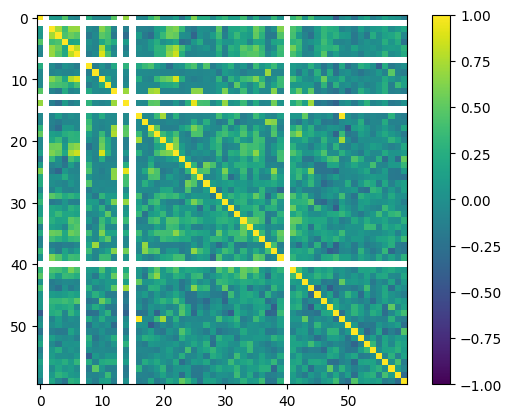

In [1778]:
fig, ax = plt.subplots()
im = ax.imshow(np.corrcoef(np.array(burst_firing_rates).T), clim=[-1,1])
plt.colorbar(im)

c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02022927, 0.12137559, 0.39109912, 1.29467296, 2.38031018,
        1.72623061, 1.39581929, 1.04517869, 0.80242751, 0.37761295,
        0.21577883, 0.15509103, 0.04720162, 0.02697235]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

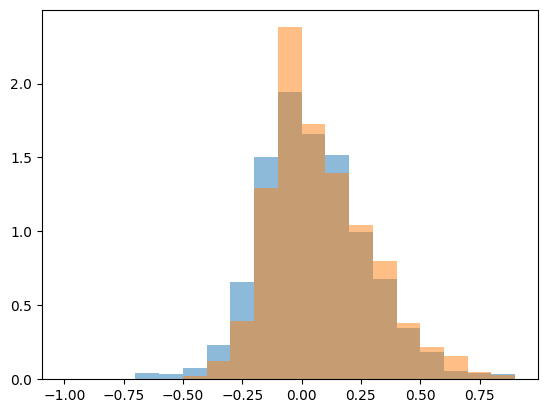

In [1785]:
plt.hist(np.corrcoef(np.array(pre_image_firing_rates).T).flatten(), bins=np.arange(-1,1,0.1), density=True, alpha=0.5)
plt.hist(np.corrcoef(np.array(burst_firing_rates).T).flatten(), bins=np.arange(-1,1,0.1), density=True, alpha=0.5)

c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\svc_ccg\AppData\Local\Continuum\anaconda3\envs\DynamicGating\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


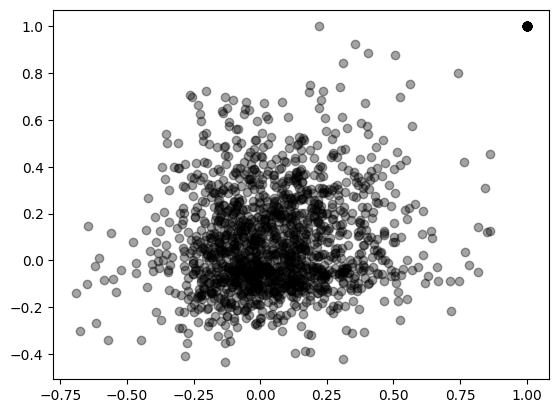

In [1786]:
plt.plot(np.corrcoef(np.array(pre_image_firing_rates).T).flatten(), np.corrcoef(np.array(burst_firing_rates).T).flatten(), 'ko', alpha=0.2)

In [1787]:
np.nanmedian(np.corrcoef(np.array(pre_image_firing_rates).T).flatten())

0.03266173208777225

In [1432]:
pre_image_firing_rates = np.array(pre_image_firing_rates)
burst_firing_rates = np.array(burst_firing_rates)

In [1433]:
pre_image_firing_rates.shape

(385, 94)

In [1399]:
image_tuning = []
burst_image_tuning = []
for image_id in np.unique(image_ids):

    rows = np.array(image_ids)==image_id
    stim_resp = np.nanmean(pre_image_firing_rates[rows], axis=0)
    burst_bystim_resp = np.nanmean(burst_firing_rates[rows], axis=0)
    image_tuning.append(stim_resp)
    burst_image_tuning.append(burst_bystim_resp)

image_tuning = np.array(image_tuning)
burst_image_tuning = np.array(burst_image_tuning)



[Text(0, 0, 'im047_r-1.0'),
 Text(1, 0, 'im114_r-1.0'),
 Text(2, 0, 'im115_r-0.7'),
 Text(3, 0, 'im115_r-1.0')]

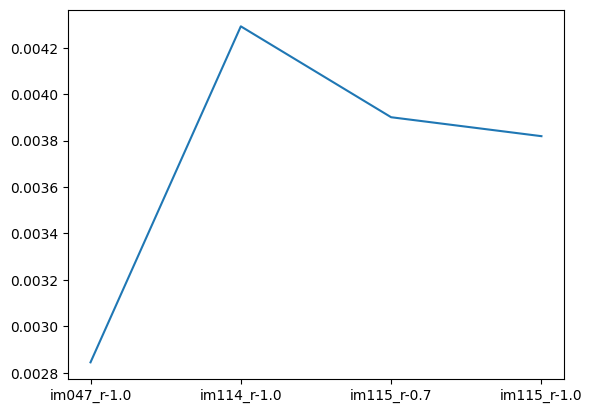

In [1400]:
fig, ax = plt.subplots()
ax.plot(np.mean(image_tuning, axis=1))
ax.set_xticks(np.arange(len(np.unique(image_ids))))
ax.set_xticklabels(np.unique(image_ids))

In [1401]:
image_tuning_norm = image_tuning/np.max(image_tuning, axis=0)[None, :]
burst_image_tuning_norm = burst_image_tuning/np.max(burst_image_tuning, axis=0)[None, :]

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\1141389057.py:1: RuntimeWarning: divide by zero encountered in divide
  image_tuning_norm = image_tuning/np.max(image_tuning, axis=0)[None, :]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\1141389057.py:1: RuntimeWarning: invalid value encountered in divide
  image_tuning_norm = image_tuning/np.max(image_tuning, axis=0)[None, :]


In [1402]:
index_array = np.argsort(image_tuning_norm, axis=0)
image_tuning_norm_sorted = np.take_along_axis(image_tuning_norm, index_array, axis=0)
burst_image_tuning_norm_sorted = np.take_along_axis(burst_image_tuning_norm, index_array, axis=0)

image_tuning_sorted = np.take_along_axis(image_tuning, index_array, axis=0)
burst_image_tuning_sorted = np.take_along_axis(burst_image_tuning, index_array, axis=0)

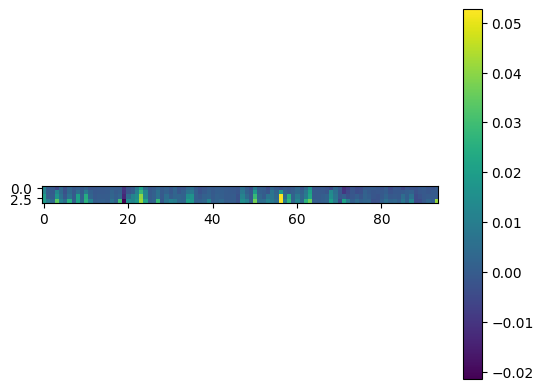

In [1409]:
plt.imshow(image_tuning_sorted)
plt.colorbar()

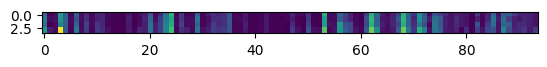

In [1404]:
plt.imshow(burst_image_tuning_sorted)

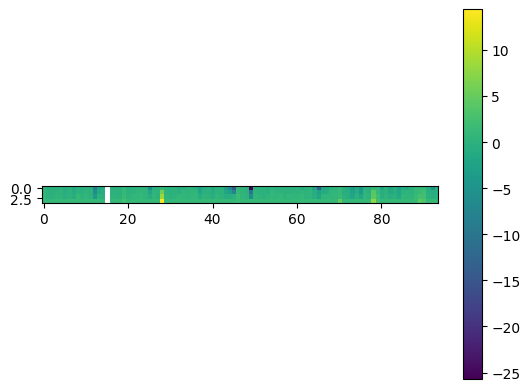

In [1408]:
plt.imshow(image_tuning_norm_sorted)
plt.colorbar()


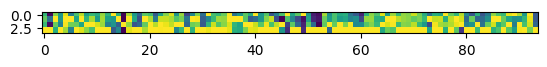

In [1406]:
plt.imshow(burst_image_tuning_norm_sorted)

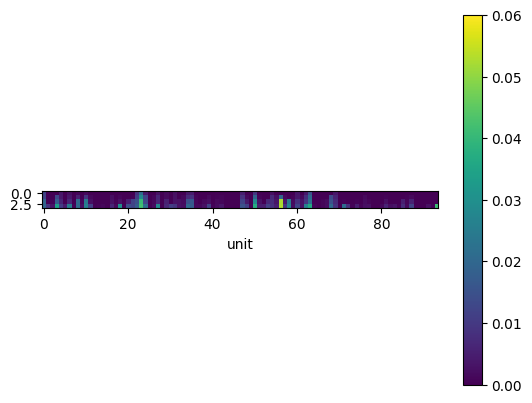

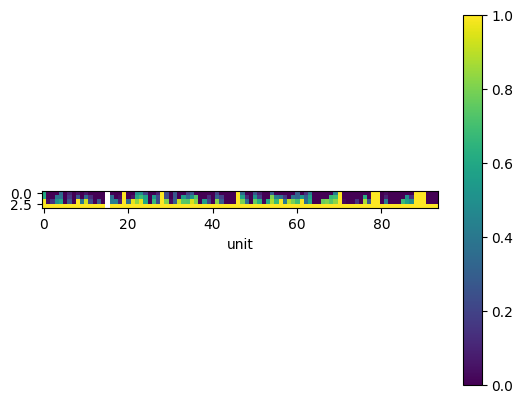

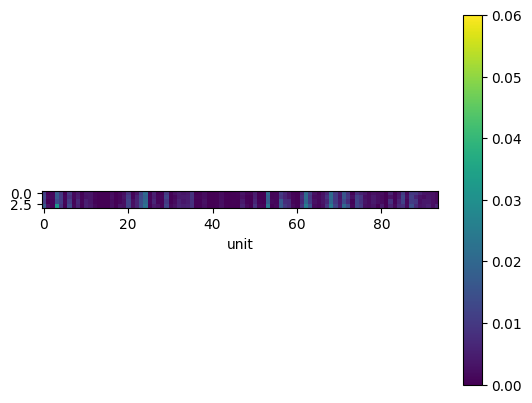

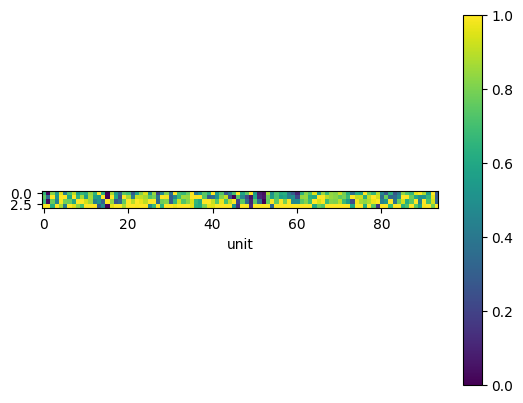

In [1407]:
for mat, name, clim in zip([image_tuning_sorted, image_tuning_norm_sorted, 
            burst_image_tuning_sorted, burst_image_tuning_norm_sorted],
            ['image', 'image_norm', 'burst', 'burst_norm'], 
            [[0,0.06], [0,1], [0,0.06], [0,1]]):
    
    fig, ax = plt.subplots()
    im = ax.imshow(mat, clim=clim)
    ax.set_xlabel('unit')
    plt.colorbar(im)

    #fig.savefig(f'{session_id}_{name}.pdf')

Text(0, 0.5, 'Response to subsequent 4Hz event')

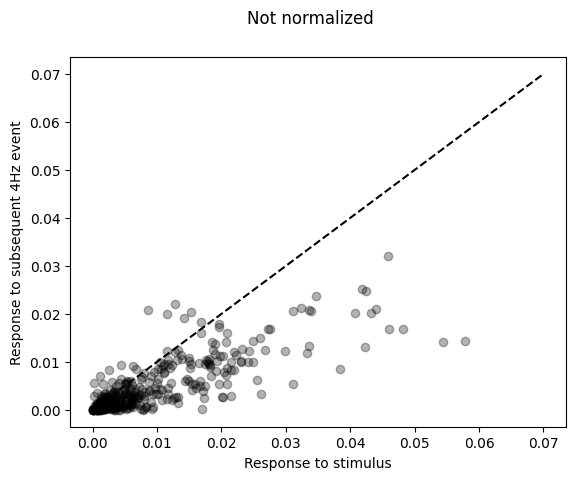

In [1298]:
fig, ax = plt.subplots()
fig.suptitle('Not normalized')
for unit in range(burst_image_tuning_norm_sorted.shape[1]):
    imresp = image_tuning_sorted[:, unit]
    burstresp = burst_image_tuning_sorted[:, unit]
    ax.plot(imresp, burstresp, 'ko', alpha=0.3)

ax.plot([0,0.07], [0,0.07], 'k--')
ax.set_xlabel('Response to stimulus')
ax.set_ylabel('Response to subsequent 4Hz event')


Text(0, 0.5, 'Response to subsequent 4Hz event')

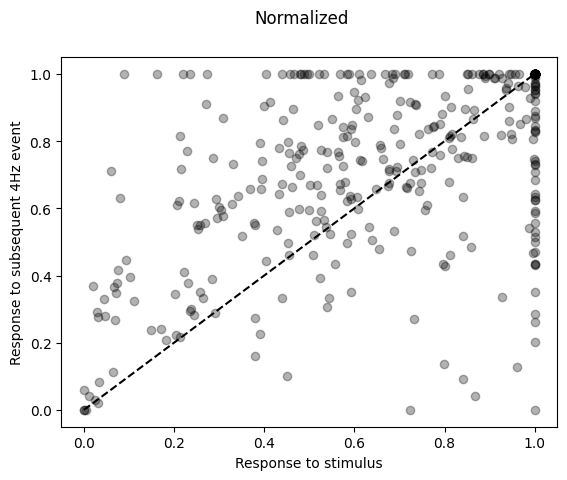

In [1299]:
fig, ax = plt.subplots()
fig.suptitle('Normalized')
for unit in range(burst_image_tuning_norm_sorted.shape[1]):
    imresp = image_tuning_norm_sorted[:, unit]
    burstresp = burst_image_tuning_norm_sorted[:, unit]
    ax.plot(imresp, burstresp, 'ko', alpha=0.3)

ax.plot([0,1], [0,1], 'k--')
ax.set_xlabel('Response to stimulus')
ax.set_ylabel('Response to subsequent 4Hz event')


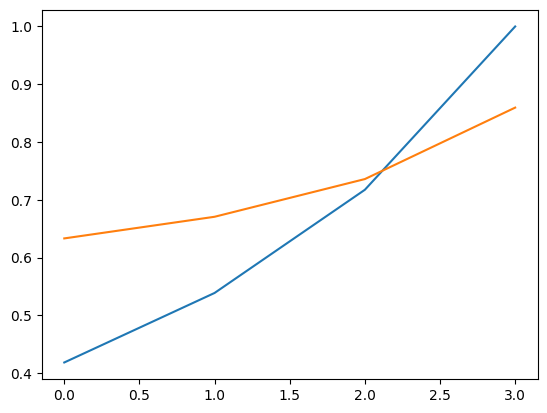

In [1297]:
fig, ax = plt.subplots()
ax.plot(np.nanmean(image_tuning_norm_sorted, axis=1))
ax.plot(np.nanmean(burst_image_tuning_norm_sorted, axis=1))
#ax.plot([0,1], [0,1], 'k--')

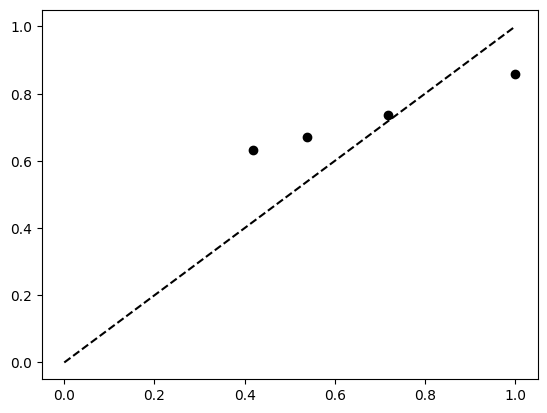

In [1278]:
plt.plot(np.nanmean(image_tuning_norm_sorted, axis=1), np.nanmean(burst_image_tuning_norm_sorted, axis=1), 'ko')
plt.plot([0,1], [0,1], 'k--')

In [1233]:
pre_image_ranked = []
burst_ranked = []
for unit in range(pre_image_firing_rates.shape[1]):

    unit_image_response = pre_image_firing_rates[:, unit]
    unit_burst_response = burst_firing_rates[:, unit]

    image_rank = np.argsort(unit_image_response)
    #image_rank = np.argsort(unit_burst_response)

    pre_image_ranked.append(unit_image_response[image_rank])
    burst_ranked.append(unit_burst_response[image_rank])

pre_image_ranked = np.array(pre_image_ranked)
burst_ranked = np.array(burst_ranked)

In [1140]:
def get_deciles(array):

    a = scipy.stats.binned_statistic(np.arange(array.shape[1]), array, bins=10)

    return a[0]

In [1234]:
pre_image_ranked_norm = pre_image_ranked/np.max(pre_image_ranked, axis=1)[:, None]
burst_ranked_norm = burst_ranked/np.max(burst_ranked, axis=1)[:, None]

pre_image_ranked_norm_unit_order = np.argsort(np.mean(pre_image_ranked_norm, axis=1))

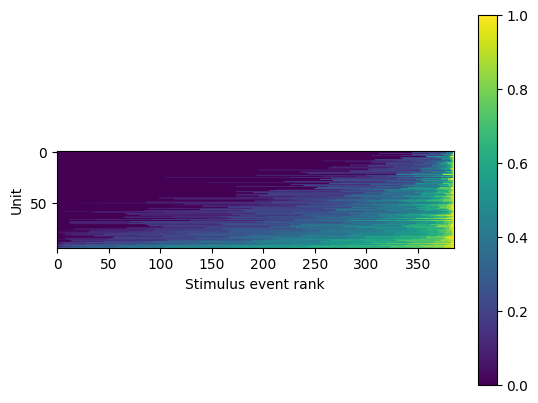

In [1246]:
fig, ax = plt.subplots()
im = ax.imshow(pre_image_ranked_norm[pre_image_ranked_norm_unit_order])
ax.set_xlabel('Stimulus event rank')
ax.set_ylabel('Unit')
plt.colorbar(im)
fig.savefig(f'{session_id}_stimulus_firing_rate_heatmap.pdf')

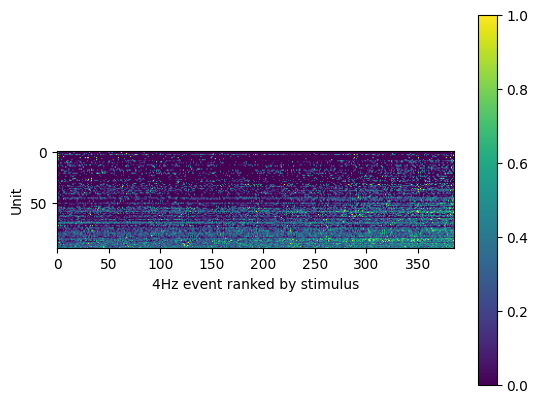

In [1247]:
fig, ax = plt.subplots()
im = ax.imshow(burst_ranked_norm[pre_image_ranked_norm_unit_order])
ax.set_xlabel('4Hz event ranked by stimulus')
ax.set_ylabel('Unit')
plt.colorbar(im)
fig.savefig(f'{session_id}_4Hzevent_firing_rate_heatmap.pdf')

Text(0.5, 0.98, '1178173272_across_unit_tuning_for_stim_and_4Hz.pdf')

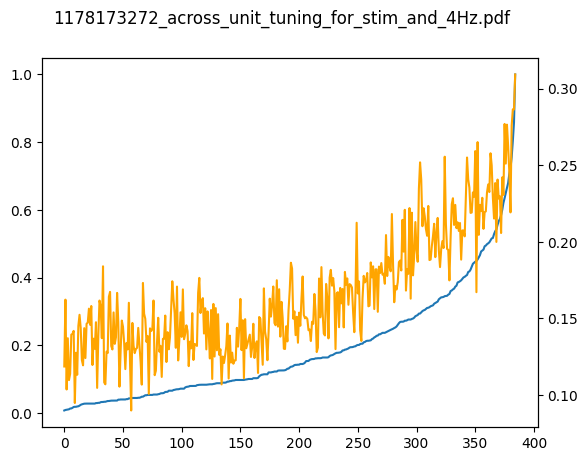

In [1248]:
fig, ax = plt.subplots()
ax.plot(np.nanmean(pre_image_ranked_norm, axis=0))
ax2 = ax.twinx()
ax2.plot(np.nanmean(burst_ranked_norm, axis=0), c='orange')
fig.suptitle(f'{session_id}_across_unit_tuning_for_stim_and_4Hz.pdf')

In [1145]:
np.corrcoef(np.nanmean(get_deciles(pre_image_ranked_norm), axis=0), np.nanmean(get_deciles(burst_ranked_norm), axis=0))


array([[1.       , 0.5636979],
       [0.5636979, 1.       ]])

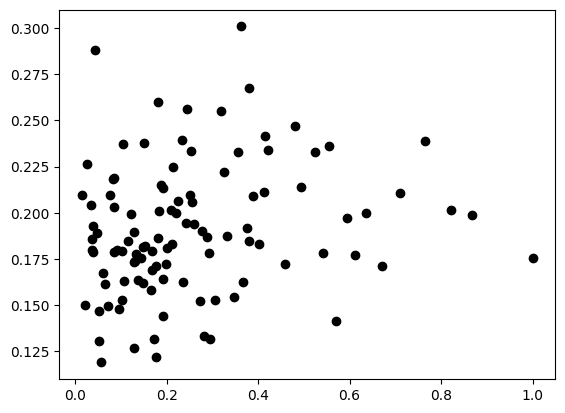

In [1146]:
corr = np.corrcoef(np.nanmean(pre_image_ranked_norm, axis=0), np.nanmean(burst_ranked_norm, axis=0))
plt.plot(np.nanmean(pre_image_ranked_norm, axis=0), np.nanmean(burst_ranked_norm, axis=0), 'ko')


In [1738]:
unit.shape

(538, 4000)

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\2149458145.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\2149458145.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['tensor_burst_ind'] = burst_tensor_inds
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\2149458145.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

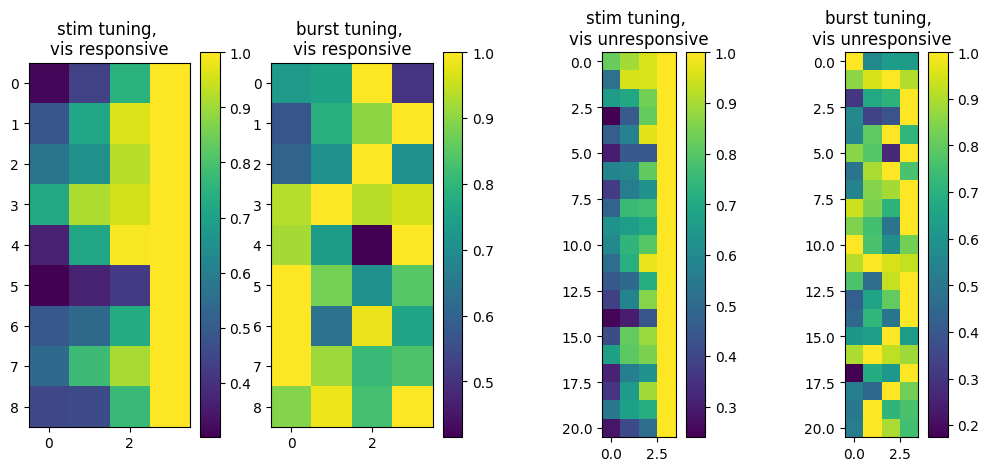

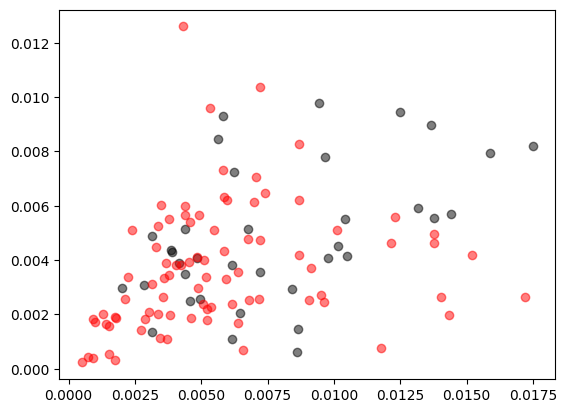

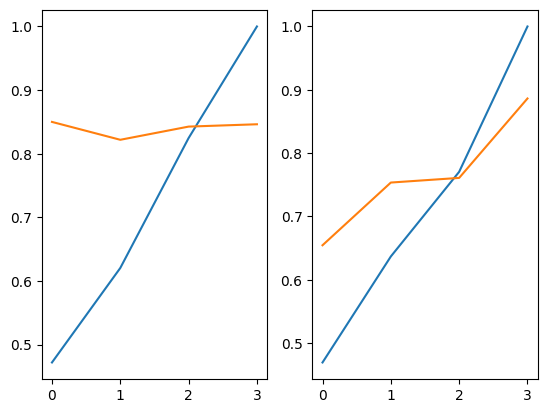

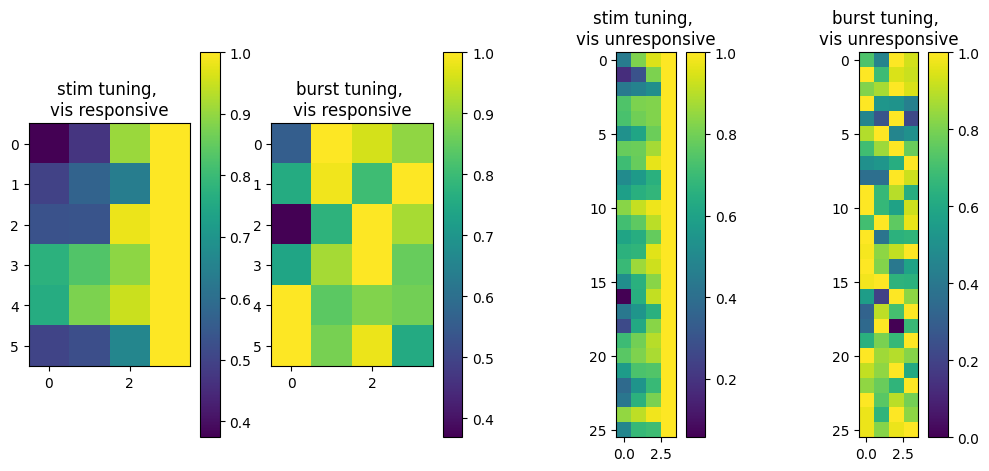

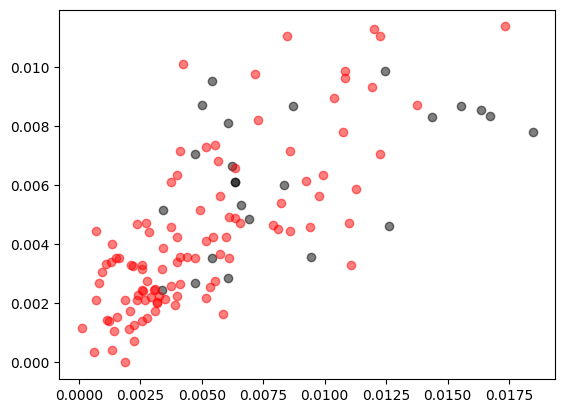

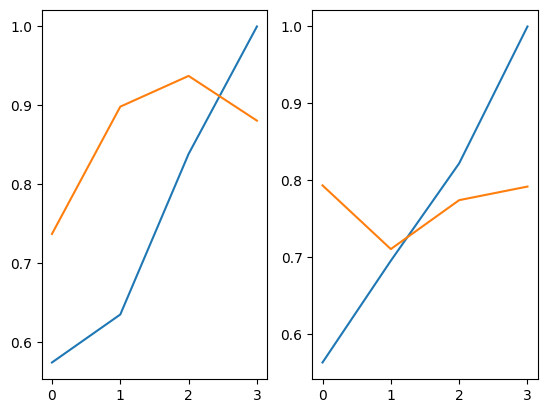

In [1773]:
bin_spikes = lambda x: np.mean(x.reshape(-1, 10), axis=1)
bin_spike_array = lambda x: np.mean(x.reshape(x.shape[0], -1, 10), axis=2)

region_of_interest = 'LP'
across_session_tuning_resp = []
across_session_tuning_unresp = []
across_session_stim_burst_frs = []
for session_id in sessions_with_many_v1_bouts:

    session_burst_tensor = burst_tensor[session_id]
    session_task_tensor = task_tensor[session_id]

    session_burst_times = np.load(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\session_analysis',
                                    session_id, 'VISp_burst_times.npy'))
    sess_ccgs = session_data[session_id]['ccgs']['VISp']['VISp']
    good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)

    session_stim = master_stim[master_stim['session_id']==int(session_id)].sort_values(by='start_time')
    inds_before_bursts = np.searchsorted(session_stim['start_time'].values, session_burst_times) - 1
    good_inds = (inds_before_bursts<len(session_stim))&(inds_before_bursts>-1)
    session_stims_before_bursts = session_stim.iloc[inds_before_bursts[good_inds]]

    session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
    burst_tensor_inds = np.arange(len(session_burst_times))[good_inds]
    session_stims_before_bursts['tensor_burst_ind'] = burst_tensor_inds
    session_stims_before_bursts['qualifying'] = good_traces[good_inds]

    if session_id in ['1234203203',
                    '1176989662',
                    '1178460518',
                    '1232954220',
                    ]:

        session_stims_before_bursts['index'] = session_stims_before_bursts['index'] + 1

    session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
    region_units = session_units[session_units['structure_acronym']==region_of_interest]['unit_id'].values
    if len(region_units)==0:
        continue

    sess_burst_tensor = tu.get_tensor_by_unit_ids(region_units, session_burst_tensor)
    sess_stim_tensor = tu.get_tensor_by_unit_ids(region_units, session_task_tensor)

    # fig, axes = plt.subplots(2,1)
    # fig.suptitle(session_id)
    # ax = axes[0]
    # ax2 = axes[1]
    # stim_trial_ind = session_stims_before_bursts['index'].iloc[0]
    # burst_trial_ind = session_stims_before_bursts['tensor_burst_ind'].iloc[0]
    
    # stimtime = np.arange(-250, 500) + 1000*session_stims_before_bursts.iloc[0]['start_time']
    # ax.plot(stimtime, np.mean(sess_stim_tensor[:, stim_trial_ind], axis=0))
    # ax.set_xlim(stimtime[250], stimtime[250]+250)

    # time = np.arange(-2000, 2000) + session_burst_times[burst_trial_ind]*1000
    # ax2.plot(time, np.mean(sess_burst_tensor[:, burst_trial_ind], axis=0))
    # ax2.set_xlim(stimtime[250], stimtime[250]+250)

    
    image_ids = []
    stim_tensor_inds = []
    burst_tensor_inds = []
    for ind, row in session_stims_before_bursts.iterrows():
        if not row['qualifying']:
            continue

        if row['burst_time'] - row['start_time']>0.55:
            continue

        if row['burst_time'] - row['start_time']<0.25:
            continue

        if row['omitted']:
            continue

        
        image_ids.append(row['image_name'])
        stim_tensor_inds.append(row['index'])
        burst_tensor_inds.append(row['tensor_burst_ind'])
    
    image_counts = [np.sum(np.array(image_ids)==im) for im in np.unique(image_ids)]
    if np.any(np.array(image_counts)<10):
        continue

    unit_tuning_responses = []
    sig_response = []
    for unit in sess_stim_tensor:
        unit_image_responses = []
        image_sig = []
        for image in np.unique(image_ids):

            image_inds = np.array(image_ids)==image
            tensor_inds = np.array(stim_tensor_inds)[image_inds]

            unit_resp_array = bin_spike_array(unit[tensor_inds])
            unit_resp = bin_spikes(np.mean(unit[tensor_inds], axis=0))
            #image_sig.append(determine_visually_responsive(unit_resp))
            image_sig.append(determine_visually_responsive_array(unit_resp_array))
            unit_image_responses.append(unit_resp)
        
        sig_response.append(np.any(image_sig))
        unit_tuning_responses.append(unit_image_responses)

    unit_burst_tuning_responses = []
    for unit in sess_burst_tensor:
        unit_burst_responses = []
        for image in np.unique(image_ids):

            image_inds = np.array(image_ids)==image
            tensor_inds = np.array(burst_tensor_inds)[image_inds]



            unit_resp = bin_spikes(np.mean(unit[tensor_inds], axis=0))

            unit_burst_responses.append(unit_resp)
        
        unit_burst_tuning_responses.append(unit_burst_responses)


    unit_tuning_responses = np.array(unit_tuning_responses)
    unit_burst_tuning_responses = np.array(unit_burst_tuning_responses)

    unit_stim_tuning_curves = np.mean(unit_tuning_responses[:, :, 27:52], axis=2) #- np.mean(unit_tuning_responses[:, :, 2:27], axis=2)
    unit_burst_tuning_curves = np.mean(unit_burst_tuning_responses[:, :, 200:225], axis=2)

    index_array = np.argsort(unit_stim_tuning_curves, axis=1)
    image_tuning_sorted = np.take_along_axis(unit_stim_tuning_curves, index_array, axis=1)
    burst_image_tuning_sorted = np.take_along_axis(unit_burst_tuning_curves, index_array, axis=1)

    fig, ax = plt.subplots(1,4)
    fig.set_size_inches([12,5])

    #norm = lambda x: x
    norm = lambda x: x/np.max(x, axis=1)[:, None]
    
    im1 = ax[0].imshow(norm(image_tuning_sorted[sig_response]))
    im2 = ax[1].imshow(norm(burst_image_tuning_sorted[sig_response]))

    im3 = ax[2].imshow(norm(image_tuning_sorted[np.invert(sig_response)]))
    im4 = ax[3].imshow(norm(burst_image_tuning_sorted[np.invert(sig_response)]))

    [plt.colorbar(im, ax=a) for a, im in zip(ax, [im1, im2, im3, im4])]
    ax[0].set_title('stim tuning, \nvis responsive')
    ax[1].set_title('burst tuning, \nvis responsive')
    ax[2].set_title('stim tuning, \nvis unresponsive')
    ax[3].set_title('burst tuning, \nvis unresponsive')

    fig, ax = plt.subplots()
    ax.plot(image_tuning_sorted[sig_response].flatten(), burst_image_tuning_sorted[sig_response].flatten(), 'ko', alpha=0.5)
    ax.plot(image_tuning_sorted[np.invert(sig_response)].flatten(), burst_image_tuning_sorted[np.invert(sig_response)].flatten(), 'ro', alpha=0.5)

    session_tuning_resp = np.mean(norm(image_tuning_sorted[sig_response]), axis=0)
    session_burst_tuning_resp = np.mean(norm(burst_image_tuning_sorted[sig_response]), axis=0)

    session_tuning_unresp = np.mean(norm(image_tuning_sorted[np.invert(sig_response)]), axis=0)
    session_burst_tuning_unresp = np.mean(norm(burst_image_tuning_sorted[np.invert(sig_response)]), axis=0)

    across_session_tuning_resp.append([session_tuning_resp, session_burst_tuning_resp])
    across_session_tuning_unresp.append([session_tuning_unresp, session_burst_tuning_unresp])


    fig, ax = plt.subplots(1,2)
    ax[0].plot(session_tuning_resp)
    ax[0].plot(session_burst_tuning_resp)
    ax[1].plot(session_tuning_unresp)
    ax[1].plot(session_burst_tuning_unresp)

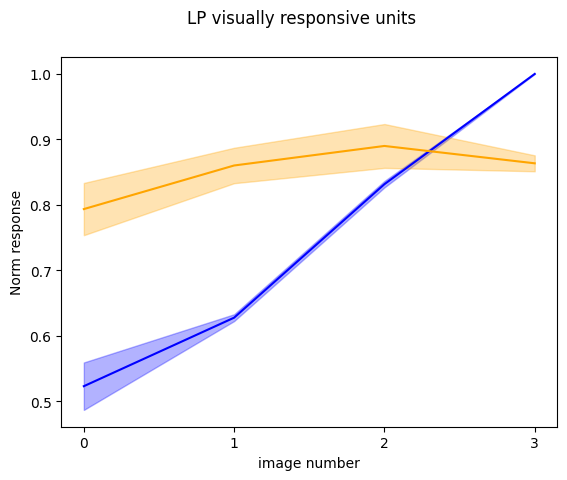

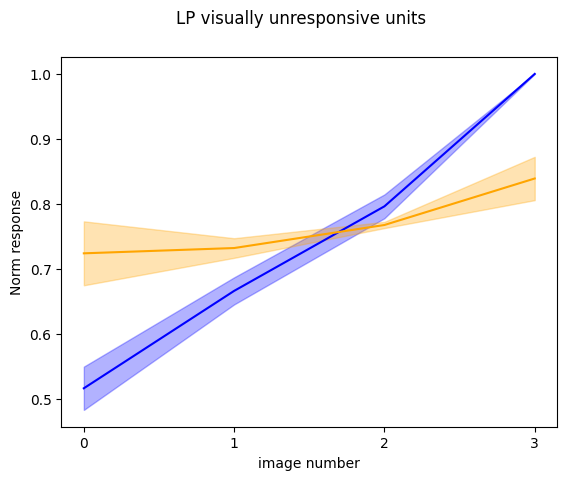

In [1774]:
across_session_tuning = np.array(across_session_tuning_resp)
fig, ax = plt.subplots()
fig.suptitle(f'{region_of_interest} visually responsive units')
colors = ['b', 'orange']
for cond in [0,1]:
    mean = np.nanmean(across_session_tuning[:, cond], axis=0)
    sem = np.nanstd(across_session_tuning[:, cond], axis=0)/across_session_tuning.shape[0]**0.5

    ax.plot(np.arange(4), mean, color=colors[cond])
    ax.fill_between(np.arange(4), mean+sem, mean-sem, alpha=0.3, color=colors[cond])
    ax.set_xticks(np.arange(4))
    ax.set_xlabel('image number')
    ax.set_ylabel('Norm response')

fig.savefig(f'{region_of_interest}_across_session_image_burst_tuning_visually_responsive.pdf')

across_session_tuning = np.array(across_session_tuning_unresp)
fig, ax = plt.subplots()
fig.suptitle(f'{region_of_interest} visually unresponsive units')
colors = ['b', 'orange']
for cond in [0,1]:
    mean = np.nanmean(across_session_tuning[:, cond], axis=0)
    sem = np.nanstd(across_session_tuning[:, cond], axis=0)/across_session_tuning.shape[0]**0.5
    ax.plot(np.arange(4), mean, color=colors[cond])
    ax.fill_between(np.arange(4), mean+sem, mean-sem, alpha=0.3, color=colors[cond])
    ax.set_xticks(np.arange(4))
    ax.set_xlabel('image number')
    ax.set_ylabel('Norm response')

fig.savefig(f'{region_of_interest}_across_session_image_burst_tuning_visually_unresponsive.pdf')


C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\444877477.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\444877477.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session_stims_before_bursts['tensor_burst_ind'] = burst_tensor_inds
C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\444877477.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

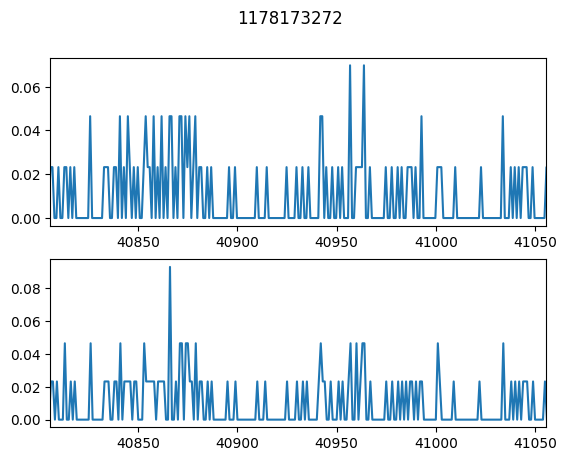

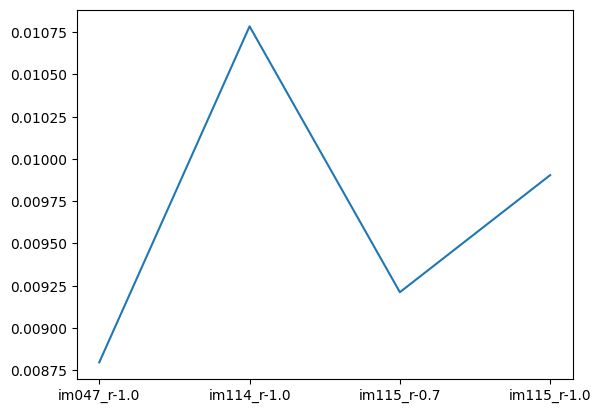

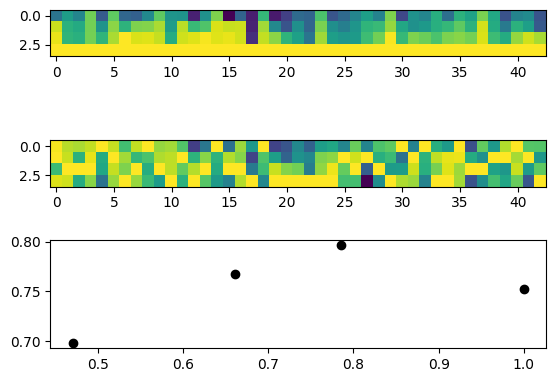

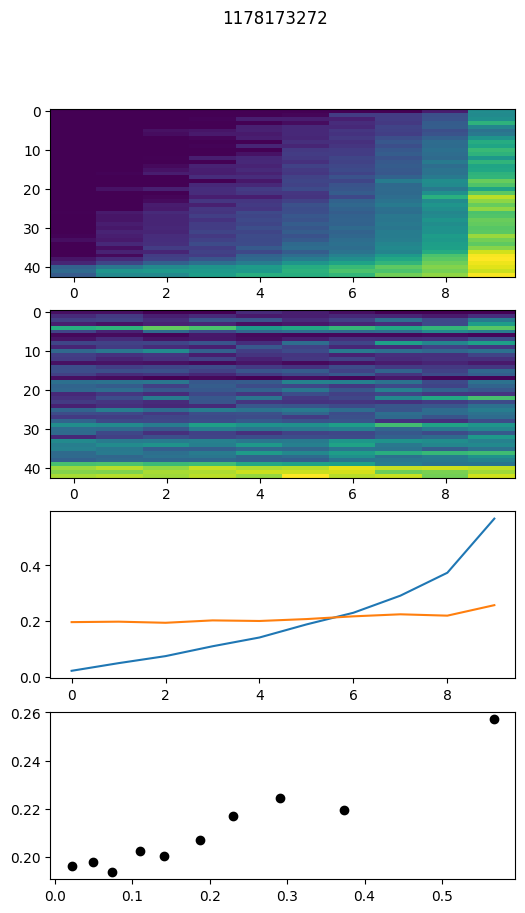

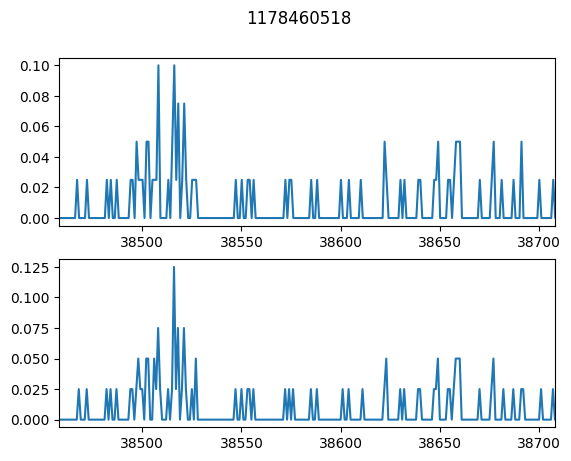

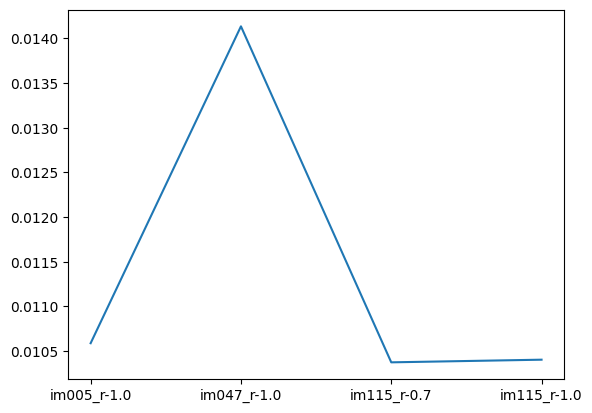

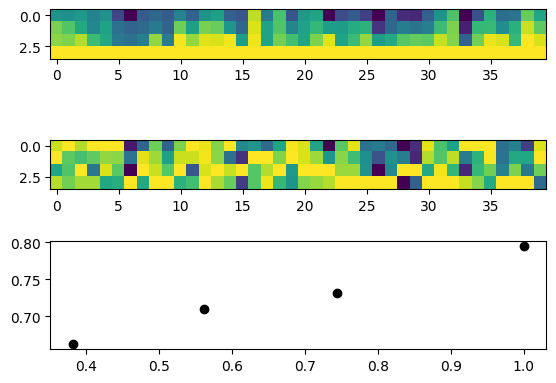

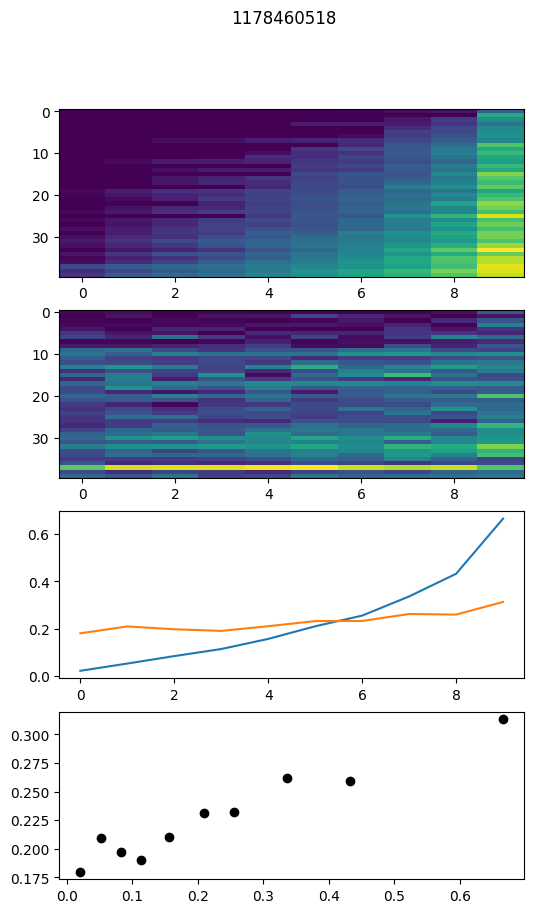

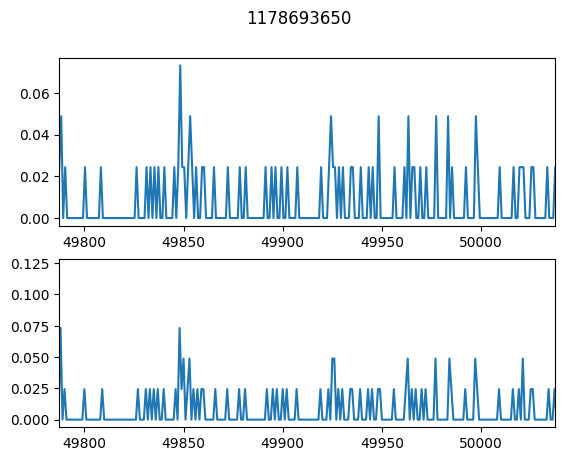

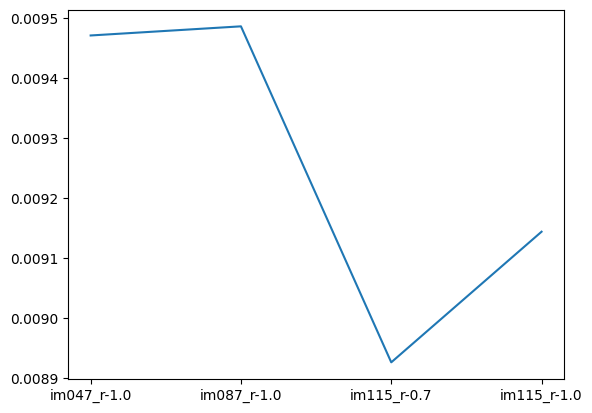

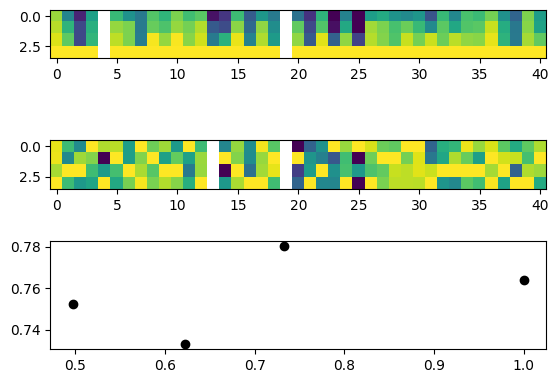

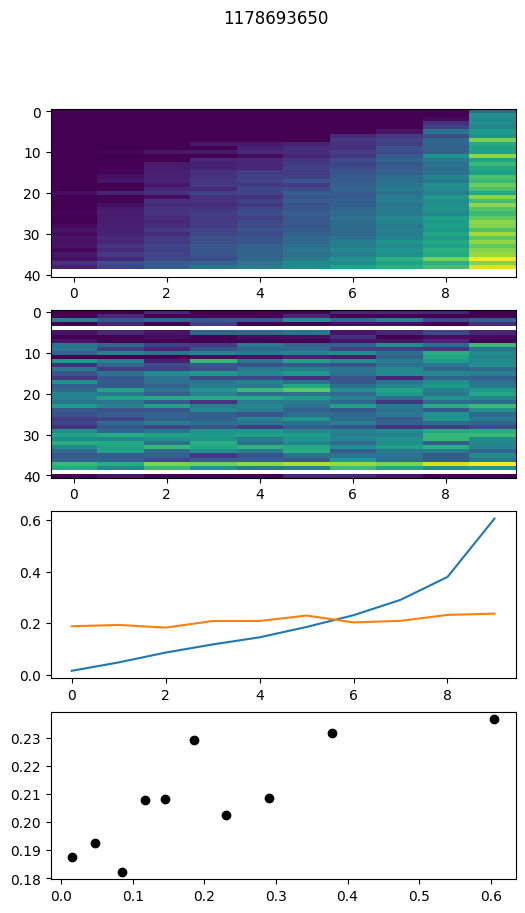

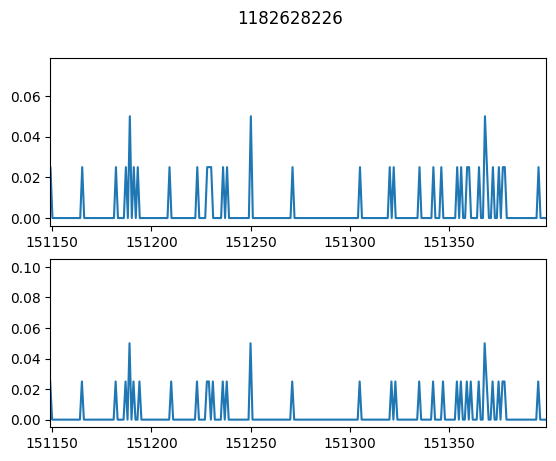

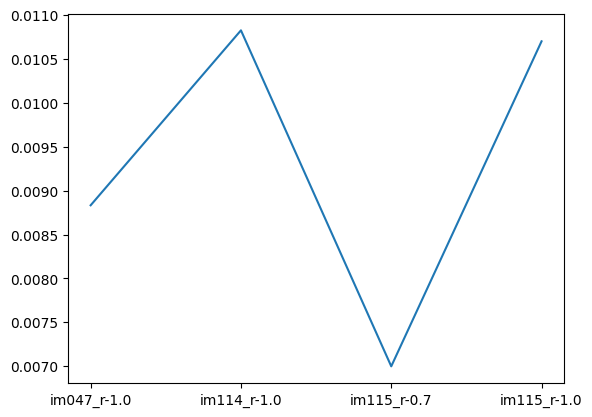

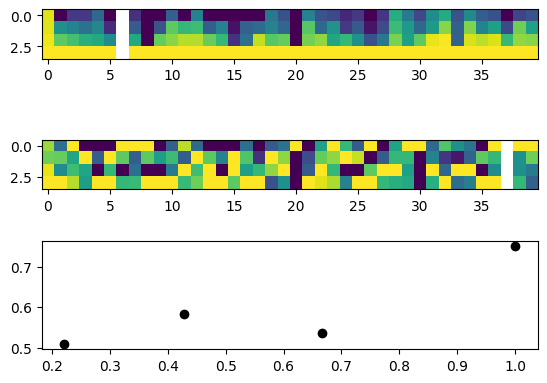

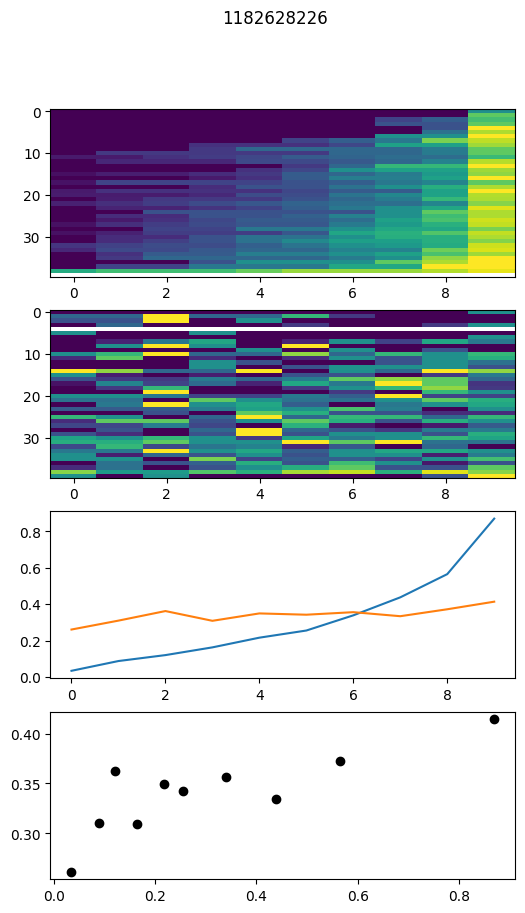

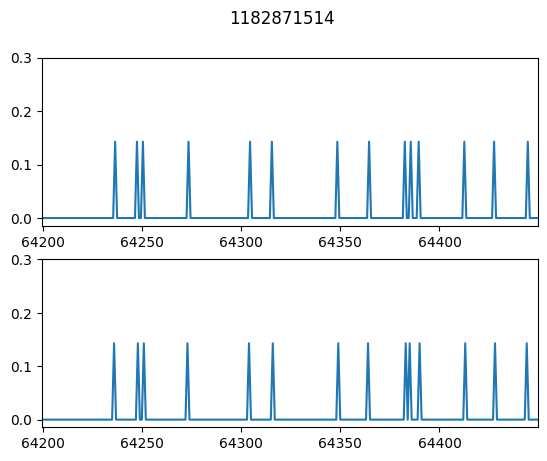

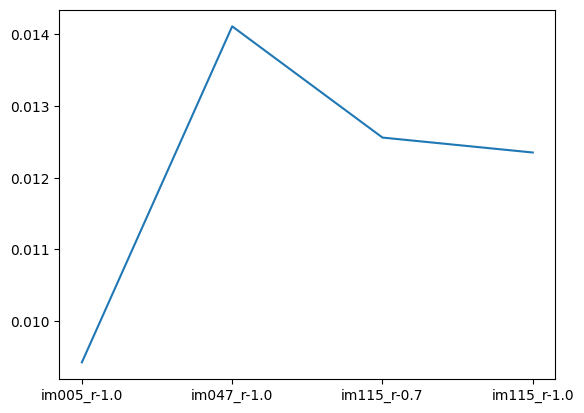

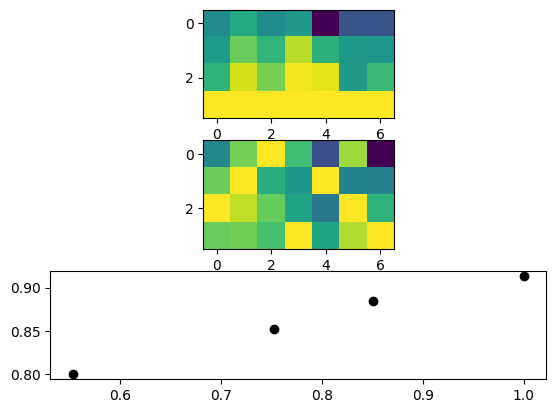

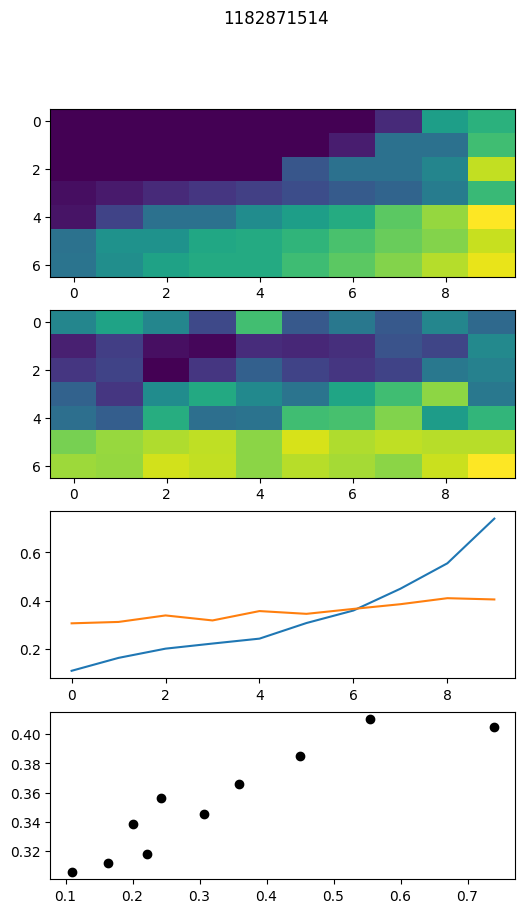

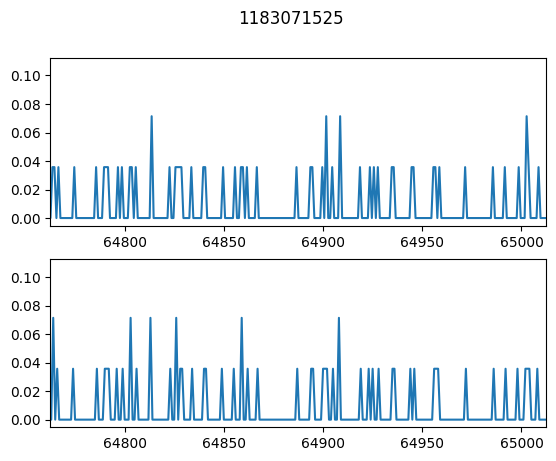

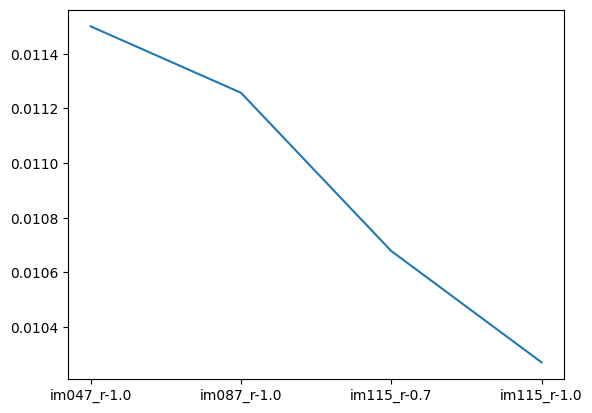

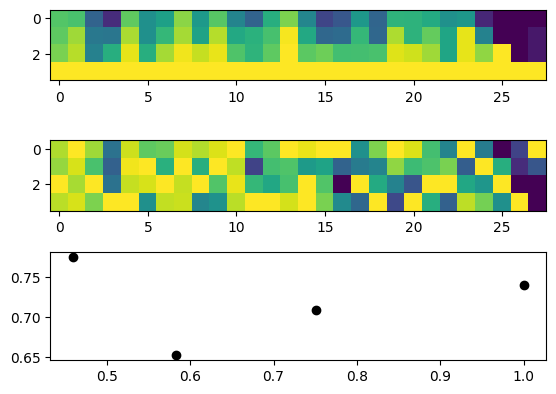

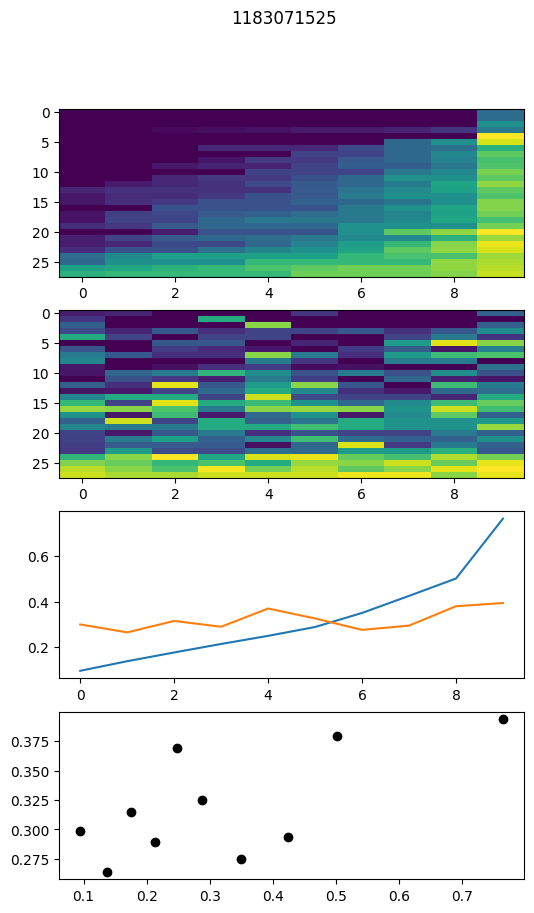

In [1351]:
region_of_interest = 'LGd'
across_session_tuning = []
across_session_stim_burst_frs = []
for session_id in sessions_with_many_v1_bouts:

    session_burst_tensor = burst_tensor[session_id]
    session_task_tensor = task_tensor[session_id]

    session_burst_times = np.load(os.path.join(r'\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\derived_table_info\4Hz_bursts\session_analysis',
                                    session_id, 'VISp_burst_times.npy'))
    sess_ccgs = session_data[session_id]['ccgs']['VISp']['VISp']
    good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)

    session_stim = master_stim[master_stim['session_id']==int(session_id)].sort_values(by='start_time')
    inds_before_bursts = np.searchsorted(session_stim['start_time'].values, session_burst_times) - 1
    good_inds = (inds_before_bursts<len(session_stim))&(inds_before_bursts>-1)
    session_stims_before_bursts = session_stim.iloc[inds_before_bursts[good_inds]]

    session_stims_before_bursts['burst_time'] = session_burst_times[good_inds]
    burst_tensor_inds = np.arange(len(session_burst_times))[good_inds]
    session_stims_before_bursts['tensor_burst_ind'] = burst_tensor_inds
    session_stims_before_bursts['qualifying'] = good_traces[good_inds]

    if session_id in ['1234203203',
                    '1176989662',
                    '1178460518',
                    '1232954220',
                    ]:

        session_stims_before_bursts['index'] = session_stims_before_bursts['index'] + 1

    session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
    region_units = session_units[session_units['structure_acronym']==region_of_interest]['unit_id'].values
    if len(region_units)==0:
        continue

    sess_burst_tensor = tu.get_tensor_by_unit_ids(region_units, session_burst_tensor)
    sess_stim_tensor = tu.get_tensor_by_unit_ids(region_units, session_task_tensor)

    fig, axes = plt.subplots(2,1)
    fig.suptitle(session_id)
    ax = axes[0]
    ax2 = axes[1]
    stim_trial_ind = session_stims_before_bursts['index'].iloc[0]
    burst_trial_ind = session_stims_before_bursts['tensor_burst_ind'].iloc[0]
    
    stimtime = np.arange(-250, 500) + 1000*session_stims_before_bursts.iloc[0]['start_time']
    ax.plot(stimtime, np.mean(sess_stim_tensor[:, stim_trial_ind], axis=0))
    ax.set_xlim(stimtime[250], stimtime[250]+250)

    time = np.arange(-2000, 2000) + session_burst_times[burst_trial_ind]*1000
    ax2.plot(time, np.mean(sess_burst_tensor[:, burst_trial_ind], axis=0))
    ax2.set_xlim(stimtime[250], stimtime[250]+250)

    pre_image_firing_rates = []
    burst_firing_rates = []
    image_ids = []
    for ind, row in session_stims_before_bursts.iterrows():
        if not row['qualifying']:
            continue

        if row['burst_time'] - row['start_time']>0.55:
            continue

        if row['burst_time'] - row['start_time']<0.25:
            continue

        if row['omitted']:
            continue

        if row['is_change_x']:
            continue

        stim_trial_response = np.mean(sess_stim_tensor[:, row['index']][:, 250:500], axis=1)
        burst_trial_response = np.mean(sess_burst_tensor[:, row['tensor_burst_ind']][:, 2000:2250], axis=1)

        pre_image_firing_rates.append(stim_trial_response)
        burst_firing_rates.append(burst_trial_response)
        image_ids.append(row['image_name'])
    
    pre_image_firing_rates = np.array(pre_image_firing_rates)
    burst_firing_rates = np.array(burst_firing_rates)

    image_tuning = []
    burst_image_tuning = []
    for image_id in np.unique(image_ids):

        rows = np.array(image_ids)==image_id
        stim_resp = np.nanmean(pre_image_firing_rates[rows], axis=0)
        burst_bystim_resp = np.nanmean(burst_firing_rates[rows], axis=0)
        image_tuning.append(stim_resp)
        burst_image_tuning.append(burst_bystim_resp)

    image_tuning = np.array(image_tuning)
    burst_image_tuning = np.array(burst_image_tuning)
    fig, ax = plt.subplots()
    ax.plot(np.mean(image_tuning, axis=1))
    ax.set_xticks(np.arange(len(np.unique(image_ids))))
    ax.set_xticklabels(np.unique(image_ids))

    image_tuning_norm = image_tuning/np.max(image_tuning, axis=0)[None, :]
    burst_image_tuning_norm = burst_image_tuning/np.max(burst_image_tuning, axis=0)[None, :]
    index_array = np.argsort(image_tuning_norm, axis=0)
    image_tuning_norm_sorted = np.take_along_axis(image_tuning_norm, index_array, axis=0)
    burst_image_tuning_norm_sorted = np.take_along_axis(burst_image_tuning_norm, index_array, axis=0)
    image_tuning_sorted = np.take_along_axis(image_tuning, index_array, axis=0)
    burst_image_tuning_sorted = np.take_along_axis(burst_image_tuning, index_array, axis=0)

    session_tuning = [np.nanmean(image_tuning_norm_sorted, axis=1), np.nanmean(burst_image_tuning_norm_sorted, axis=1)]
    across_session_tuning.append(session_tuning)
    across_session_stim_burst_frs.append([image_tuning_sorted.flatten(), burst_image_tuning_sorted.flatten()])

    fig, ax = plt.subplots(3,1)
    ax[0].imshow(image_tuning_norm_sorted)
    ax[1].imshow(burst_image_tuning_norm_sorted)
    ax[2].plot(np.nanmean(image_tuning_norm_sorted, axis=1), np.nanmean(burst_image_tuning_norm_sorted, axis=1), 'ko')

    pre_image_ranked = []
    burst_ranked = []
    for unit in range(pre_image_firing_rates.shape[1]):

        unit_image_response = pre_image_firing_rates[:, unit]
        unit_burst_response = burst_firing_rates[:, unit]

        image_rank = np.argsort(unit_image_response)
        #image_rank = np.argsort(unit_burst_response)

        pre_image_ranked.append(unit_image_response[image_rank])
        burst_ranked.append(unit_burst_response[image_rank])

    pre_image_ranked = np.array(pre_image_ranked)
    burst_ranked = np.array(burst_ranked)

    pre_image_ranked_norm = pre_image_ranked/np.max(pre_image_ranked, axis=1)[:, None]
    burst_ranked_norm = burst_ranked/np.max(burst_ranked, axis=1)[:, None]

    pre_image_ranked_norm = get_deciles(pre_image_ranked_norm)
    burst_ranked_norm = get_deciles(burst_ranked_norm)

    pre_image_ranked_norm_unit_order = np.argsort(np.mean(pre_image_ranked_norm, axis=1))

    fig, ax = plt.subplots(4,1)
    fig.set_size_inches([6, 10])
    fig.suptitle(session_id)
    ax[0].imshow(pre_image_ranked_norm[pre_image_ranked_norm_unit_order])
    ax[1].imshow(burst_ranked_norm[pre_image_ranked_norm_unit_order])

    ax[2].plot(np.nanmean(pre_image_ranked_norm, axis=0))
    ax[2].plot(np.nanmean(burst_ranked_norm, axis=0))

    ax[3].plot(np.nanmean(pre_image_ranked_norm, axis=0), np.nanmean(burst_ranked_norm, axis=0), 'ko')
    [a.set_aspect('auto') for a in ax[:2]]

    #across_session_tuning.append((np.nanmean(pre_image_ranked_norm, axis=0), np.nanmean(burst_ranked_norm, axis=0)))


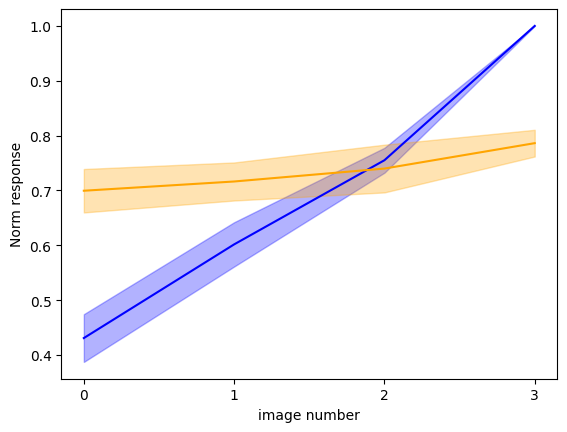

In [1515]:
across_session_tuning = np.array(across_session_tuning)
fig, ax = plt.subplots()
colors = ['b', 'orange']
for cond in [0,1]:
    mean = np.mean(across_session_tuning[:, cond], axis=0)
    sem = np.std(across_session_tuning[:, cond], axis=0)/across_session_tuning.shape[0]**0.5

    ax.plot(np.arange(4), mean, color=colors[cond])
    ax.fill_between(np.arange(4), mean+sem, mean-sem, alpha=0.3, color=colors[cond])
    ax.set_xticks(np.arange(4))
    ax.set_xlabel('image number')
    ax.set_ylabel('Norm response')

fig.savefig(f'{region_of_interest}_across_session_image_burst_tuning.pdf')

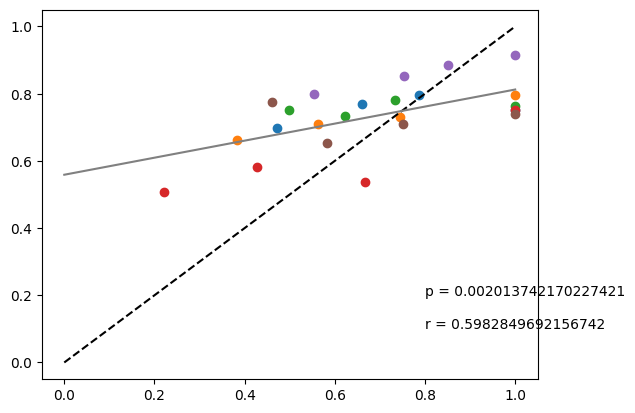

In [1516]:
fig, ax = plt.subplots()
stim_tuning = []
burst_tuning = []
for sessind in range(across_session_tuning.shape[0]):

    stim_tuning.extend(across_session_tuning[sessind, 0, :])
    burst_tuning.extend(across_session_tuning[sessind, 1, :])
    ax.plot(across_session_tuning[sessind, 0, :], across_session_tuning[sessind, 1, :], 'o')

ax.plot([0,1], [0,1], 'k--')
lin_fit = scipy.stats.linregress(stim_tuning, burst_tuning)
pval = lin_fit[3]

ax.plot([0, 1], [lin_fit[1], lin_fit[0]+lin_fit[1]], 'gray')
ax.text(0.8, 0.2, f'p = {pval}')
ax.text(0.8, 0.1, f'r = {lin_fit[2]}')
fig.savefig(f'{region_of_interest}_across_session_correlation_stim_tuning_burst_tuning.pdf')

In [1312]:
scipy.stats.linregress(stim_tuning, burst_tuning)

LinregressResult(slope=0.32285157807132686, intercept=0.45927200976508314, rvalue=0.7682846574351676, pvalue=1.8077453673265666e-06, stderr=0.052753048750721385, intercept_stderr=0.03501657778162814)

In [1518]:
across_session_stim_burst_frs = np.array(across_session_stim_burst_frs)
across_session_stim_burst_frs.shape

C:\Users\svc_ccg\AppData\Local\Temp\ipykernel_90984\629151114.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  across_session_stim_burst_frs = np.array(across_session_stim_burst_frs)


(6, 2)

In [1519]:
[len(across_session_stim_burst_frs[s,0])/4 for s in range(7)]

IndexError: index 6 is out of bounds for axis 0 with size 6

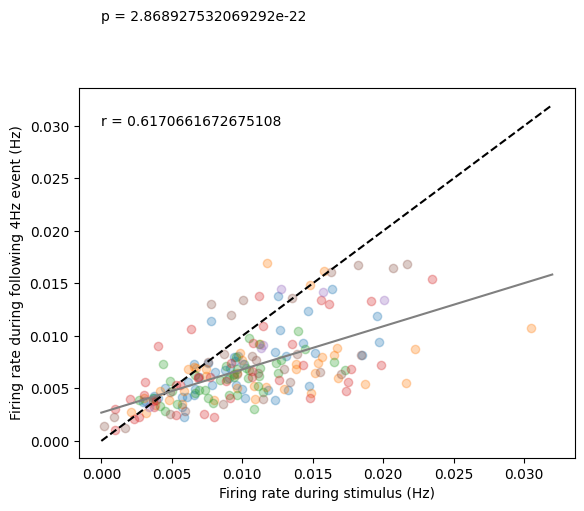

In [1520]:
fig, ax = plt.subplots()
all_stim_frs = []
all_burst_frs = []
for sessind in range(across_session_stim_burst_frs.shape[0]):

    stim_frs = across_session_stim_burst_frs[sessind, 0].reshape([-1, 4])
    burst_frs = across_session_stim_burst_frs[sessind, 1].reshape([-1, 4])

    ax.plot(np.mean(stim_frs, axis=1), np.mean(burst_frs, axis=1), 'o', alpha=0.3)
    all_stim_frs.extend(np.mean(stim_frs, axis=1))
    all_burst_frs.extend(np.mean(burst_frs, axis=1))

maxval = np.max([ax.get_xlim(), ax.get_ylim()])
ax.plot([0,maxval], [0,maxval], 'k--')
ax.set_xlabel('Firing rate during stimulus (Hz)')
ax.set_ylabel('Firing rate during following 4Hz event (Hz)')

lin_fit = scipy.stats.linregress(all_stim_frs, all_burst_frs)
pval = lin_fit[3]

ax.plot([0, maxval], [lin_fit[1], lin_fit[0]*maxval+lin_fit[1]], 'gray')
ax.text(0, 0.04, f'p = {pval}')
ax.text(0, 0.03, f'r = {lin_fit[2]}')
fig.savefig(f'{region_of_interest}_across_session_correlation_stim_fr_burst_fr.pdf')


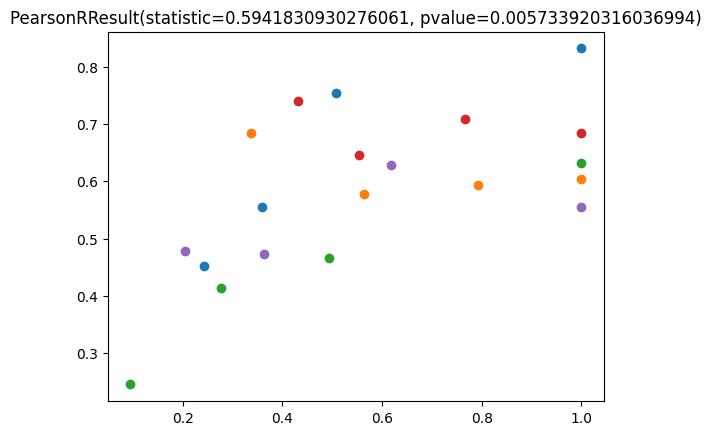

In [1350]:
fig, ax = plt.subplots()
all_stim = []
all_burst = []
for sess in across_session_tuning:

    ax.plot(sess[0], sess[1], 'o')
    all_stim.extend(sess[0])
    all_burst.extend(sess[1])
# ax.plot([0,1], [0,1], 'k--')
# ax.set_aspect('equal')

ax.set_title(scipy.stats.pearsonr(all_stim, all_burst))
fig.savefig(f'{region_of_interest}_across_session_correlation_between_stim_firing_and_4Hz_firing.pdf')

In [94]:
all_recorded_areas = glob.glob(os.path.join(data_dir, '*', '*ccgs.npy'))
all_recorded_areas = np.unique([os.path.basename(f).split('_')[1] for f in all_recorded_areas])

ccg_dict = {a:{} for a in all_burst_areas}
random_ccg_dict = {a:{} for a in all_burst_areas}
for area in all_burst_areas:
    for area2 in all_recorded_areas:

        ccg_files = glob.glob(os.path.join(data_dir, '*', area + '_' + area2 + '_ccgs.npy'))
        rand_ccg_files = glob.glob(os.path.join(data_dir, '*', area + '_' + area2 + '_ccgs_random.npy'))
        if len(ccg_files)>0:

            ccgs = []
            for f in ccg_files:
                ccg = np.load(f)
                ccgs.append(ccg)

            ccg_dict[area][area2] = ccgs

            rand_ccgs = []
            for f in rand_ccg_files:
                ccg = np.load(f)
                rand_ccgs.append(ccg)
            
            random_ccg_dict[area][area2] = rand_ccgs
            # concat = np.concatenate(ccgs)
            # fig, ax = plt.subplots(1,3)
            # fig.set_size_inches(12,6)
            # fig.suptitle(f'{area} to {area2}')
            # ax[0].plot(np.mean(concat, axis=0))
            # ax[1].hist(np.max(concat, axis=1), bins=np.arange(0, 0.8, 0.01))
            # ax[2].hist((np.argmax(concat, axis=1) - 100)/100, bins=np.arange(-1, 1, 0.1))

In [1962]:
session_dict['VISp']['CP']

['1182628226', '1182871514', '1183071525', '1194850630', '1195036753']

In [225]:
import h5py
import tensor_utils as tu

In [2407]:
v1_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_VISp_bursts.hdf5"
v1_random_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_VISp_random_times.hdf5"
v1_tensor = h5py.File(v1_tensor_file)
v1_random_tensor = h5py.File(v1_random_tensor_file)

m1_tensor_file = r"\\allen\programs\mindscope\workgroups\dynamicrouting\dynamic_gating\dg_active_unit_tensor_MOp_bursts.hdf5"
m1_tensor = h5py.File(m1_tensor_file)

In [1963]:
session_id = '1182628226'
session_tensor = v1_tensor[session_id]
session_random_tensor = v1_random_tensor[session_id]

sess_ccgs = session_data[session_id]['ccgs']['VISp']['VISp']
good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)

In [1964]:
session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
v1_sess_tensor = tu.get_tensor_by_unit_ids(session_units[session_units['structure_acronym']=='VISp']['unit_id'].values, session_tensor)

In [1965]:
v1_means = np.mean(v1_sess_tensor, axis=0)
v1_mean_binned = np.mean(np.reshape(v1_means, (v1_means.shape[0], 400, 10)), axis=2)
v1_mean_binned.shape


(96, 400)

In [1966]:
area_of_interest = 'CP'
area_units = session_units[session_units['structure_acronym']==area_of_interest]

In [1967]:
base_sub_array = lambda x: x - np.mean(x, axis=1)[:, None]

In [65]:
sem = lambda x: np.std(x, axis=0)/len(x)**0.5
mean0 = lambda x: np.mean(x, axis=0)
unpack_lists = lambda x: [ss for s in x for ss in s]
base_sub_array = lambda x: x - np.mean(x, axis=1)[:, None]

for area_of_interest in ['CP']:

    sessions = session_dict['VISp'][area_of_interest]
    rf_coherence = []
    no_rf_coherence = []
    rf_mean = []
    no_rf_mean = []
    for session_id in sessions:
        session_tensor = v1_tensor[session_id]
        session_random_tensor = v1_random_tensor[session_id]

        sess_ccgs = session_data[session_id]['ccgs']['VISp']['VISp']
        good_traces = get_qualifying_autoccgs(sess_ccgs, 0.1)

        session_units = tu.apply_good_units_filter(units_rf[units_rf['session']==int(session_id)])
        v1_sess_tensor = tu.get_tensor_by_unit_ids(session_units[session_units['structure_acronym']=='VISp']['unit_id'].values, session_tensor)

        v1_means = np.mean(v1_sess_tensor, axis=0)
        v1_mean_binned = np.mean(np.reshape(v1_means, (v1_means.shape[0], 400, 10)), axis=2)

        area_units = session_units[session_units['structure_acronym']==area_of_interest]

        # if area_units['is_sig_rf'].sum()<10:
        #     continue

        fig, ax = plt.subplots()
        fig.suptitle(f'{area_of_interest} {session_id}')
        fig2, ax2 = plt.subplots()
        for rf_or_not, coh_agg, mean_agg in zip([area_units['is_sig_rf'], ~area_units['is_sig_rf']], [rf_coherence, no_rf_coherence], [rf_mean, no_rf_mean]):

            if np.sum(rf_or_not)==0:
                continue

            rf_area_tensor = tu.get_tensor_by_unit_ids(area_units[rf_or_not]['unit_id'].values, session_tensor)
            rf_area_random_tensor = tu.get_tensor_by_unit_ids(area_units[rf_or_not]['unit_id'].values, session_random_tensor)
            
            mean = np.mean(rf_area_tensor, axis=0)
            mean_binned = np.mean(np.reshape(mean, (mean.shape[0], 400, 10)), axis=2)
            print(rf_area_tensor.shape)
            freqs, coh = multi_taper_coherence(base_sub_array(mean_binned[good_traces]), base_sub(v1_mean_binned[good_traces]), fs=100)

            random_mean = np.mean(rf_area_random_tensor, axis=0)
            random_mean_binned = np.mean(np.reshape(random_mean, (random_mean.shape[0], 400, 10)), axis=2)
            freqs, rand_coh = multi_taper_coherence(base_sub_array(random_mean_binned[good_traces]), base_sub_array(v1_mean_binned[good_traces]), fs=100)

            ax.plot(freqs, np.mean(coh, axis=0) - np.mean(rand_coh, axis=0))
            ax2.plot(np.mean(mean_binned, axis=0))

            coh_agg.append(np.array(coh) - np.array(rand_coh))
            mean_agg.append(mean_binned[good_traces])

    if len(rf_coherence)==0:
        continue
    
    rf_coherence = np.array(unpack_lists(rf_coherence))
    rf_coherence = np.array([r for r in rf_coherence if not np.any(np.isnan(r))])
    no_rf_coherence = np.array(unpack_lists(no_rf_coherence))
    #diff = rf_coherence - no_rf_coherence

    rf_mean = np.array(unpack_lists(rf_mean))
    no_rf_mean = np.array(unpack_lists(no_rf_mean))

    fig, ax = plt.subplots()
    fig.suptitle(area_of_interest)
    area_rf_coh = np.nanmean(rf_coherence, axis=0)
    area_rf_coh_sem = np.nanstd(rf_coherence, axis=0)/len(rf_coherence)**0.5
    area_no_rf_coh = np.nanmean(no_rf_coherence, axis=0)
    area_no_rf_coh_sem = np.nanstd(no_rf_coherence, axis=0)/len(no_rf_coherence)**0.5

    # diff_mean = np.mean(diff, axis=0)
    # diff_sem = np.std(diff, axis=0)/diff.shape[0]**0.5

    ax.plot(freqs, area_rf_coh, 'b')
    ax.fill_between(freqs, area_rf_coh+area_rf_coh_sem, area_rf_coh-area_rf_coh_sem, color='b', alpha=0.5)
    ax.plot(freqs, area_no_rf_coh, 'orange')
    ax.fill_between(freqs, area_no_rf_coh+area_no_rf_coh_sem, area_no_rf_coh-area_no_rf_coh_sem, color='orange', alpha=0.5)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Coherence')
    # ax.plot(freqs, diff_mean)
    # ax.fill_between(freqs, diff_mean - diff_sem, diff_mean+diff_sem, alpha=0.5)
    ax.axvspan(3,7, color='k', alpha=0.1)

    rf_mean_basesub = base_sub_array(rf_mean)
    no_rf_mean_basesub = base_sub_array(no_rf_mean)

    rf_mean_trace = np.mean(rf_mean, axis=0)
    no_rf_mean_trace = np.mean(no_rf_mean_basesub, axis=0)

    time = np.linspace(0, 2, 200)
    fig, ax = plt.subplots()
    ax.plot(time, mean0(rf_mean_basesub)[200:])
    ax.fill_between(time, mean0(rf_mean_basesub)[:200]+sem(rf_mean_basesub)[:200], mean0(rf_mean_basesub)[:200]-sem(rf_mean_basesub)[:200])
    ax.plot(time, mean0(no_rf_mean_basesub)[:200])
    ax.fill_between(time, mean0(no_rf_mean_basesub)[:200]+sem(no_rf_mean_basesub)[:200], mean0(no_rf_mean_basesub)[:200]-sem(no_rf_mean_basesub)[:200])
    ax.set_xlabel('Time from event onset')
    ax.set_ylabel('Firing rate (Hz)')


NameError: name 'v1_tensor' is not defined

In [2434]:
ind_band_low = np.searchsorted(freqs, 3)
ind_band_high = np.searchsorted(freqs, 7)

rf_band = np.mean(rf_coherence[:, ind_band_low:ind_band_high], axis=1)
no_rf_band = np.mean(no_rf_coherence[:, ind_band_low:ind_band_high], axis=1)

scipy.stats.wilcoxon(rf_band, no_rf_band)


WilcoxonResult(statistic=28158.0, pvalue=3.760576319098457e-14)

CP RF coherence: (201,)
CP No RF coherence: (439, 250)
CP RF 4Hz mean: (439, 250)
CP No RF 4Hz mean: (439, 250)


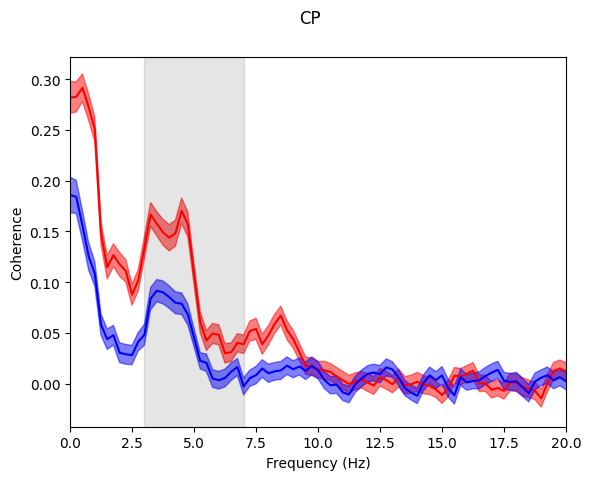

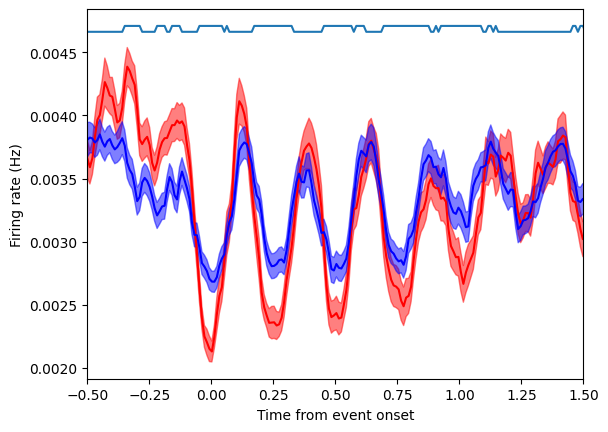

In [2466]:
sem = lambda x: np.std(x, axis=0)/len(x)**0.5
mean0 = lambda x: np.mean(x, axis=0)
unpack_lists = lambda x: [ss for s in x for ss in s]
base_sub_array = lambda x: x - np.mean(x, axis=1)[:, None]

fig, ax = plt.subplots()
fig.suptitle(area_of_interest)

ax.plot(freqs, area_rf_coh, 'r')
ax.fill_between(freqs, area_rf_coh+area_rf_coh_sem, area_rf_coh-area_rf_coh_sem, color='r', alpha=0.5)
ax.plot(freqs, area_no_rf_coh, 'b')
ax.fill_between(freqs, area_no_rf_coh+area_no_rf_coh_sem, area_no_rf_coh-area_no_rf_coh_sem, color='b', alpha=0.5)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coherence')
# ax.plot(freqs, diff_mean)
# ax.fill_between(freqs, diff_mean - diff_sem, diff_mean+diff_sem, alpha=0.5)
ax.axvspan(3,7, color='k', alpha=0.1)
ax.set_xlim(0,20)
fig.savefig('CP_rf_norf_coherence.pdf')

rf_mean_basesub = base_sub_array(rf_mean)[:, 150:]
no_rf_mean_basesub = base_sub_array(no_rf_mean)[:, 150:]

rf_mean_basesub = rf_mean[:, 150:]
no_rf_mean_basesub = no_rf_mean[:, 150:]

rf_mean_basesub = np.array([exponential_convolve(r) for r in rf_mean_basesub])
no_rf_mean_basesub = np.array([exponential_convolve(r) for r in no_rf_mean_basesub])

mean_sig_pvalues = np.array([scipy.stats.wilcoxon(rf_time, no_rf_time)[1] for rf_time, no_rf_time in zip(rf_mean_basesub.T, no_rf_mean_basesub.T)])
corrected_sig = statsmodels.stats.multitest.fdrcorrection(mean_sig_pvalues)[0]



print(f'CP RF coherence: {area_rf_coh.shape}')
print(f'CP No RF coherence: {no_rf_mean_basesub.shape}')
print(f'CP RF 4Hz mean: {rf_mean_basesub.shape}')
print(f'CP No RF 4Hz mean: {no_rf_mean_basesub.shape}')
 
time = np.linspace(-0.5, 2, 250)
fig, ax = plt.subplots()
ax.plot(time, (mean0(rf_mean_basesub)), 'r')
ax.fill_between(time, mean0(rf_mean_basesub)+sem(rf_mean_basesub), mean0(rf_mean_basesub)-sem(rf_mean_basesub), color='r', alpha=0.5)
ax.plot(time, mean0(no_rf_mean_basesub), 'b')
ax.fill_between(time, mean0(no_rf_mean_basesub)+sem(no_rf_mean_basesub), mean0(no_rf_mean_basesub)-sem(no_rf_mean_basesub), color='b', alpha=0.5)
ylim = ax.get_ylim()
ax.plot(time, corrected_sig*ylim[1]*0.01+ylim[1])

ax.set_xlabel('Time from event onset')
ax.set_ylabel('Firing rate (Hz)')
ax.set_xlim(-0.5, 1.5)

fig.savefig('CP_rf_norf_mean_trace.pdf')


In [2374]:
session_dict['VISp']['CP']

['1182628226', '1182871514', '1183071525', '1194850630', '1195036753']

In [2001]:
rf_coherence = np.array(unpack_lists(rf_coherence))
no_rf_coherence = np.array(unpack_lists(no_rf_coherence))
diff = rf_coherence - no_rf_coherence

rf_mean = np.array(unpack_lists(rf_mean))
no_rf_mean = np.array(unpack_lists(no_rf_mean))

In [2150]:
len(mean0(no_rf_mean_basesub))

250

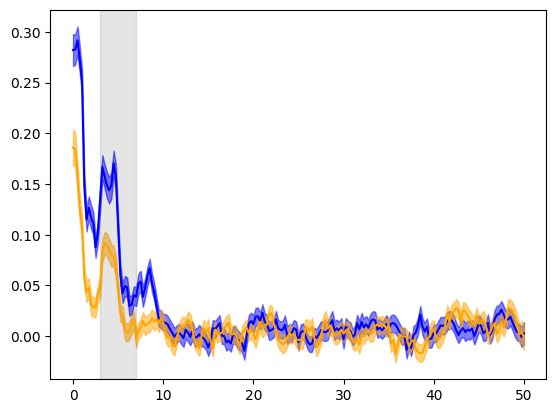

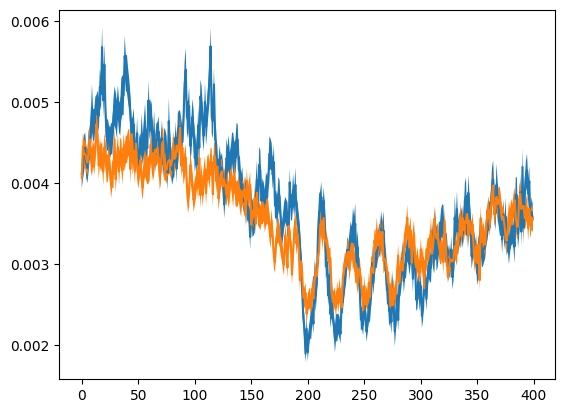

In [2151]:
fig, ax = plt.subplots()
area_rf_coh = np.mean(rf_coherence, axis=0)
area_rf_coh_sem = np.std(rf_coherence, axis=0)/len(rf_coherence)**0.5
area_no_rf_coh = np.mean(no_rf_coherence, axis=0)
area_no_rf_coh_sem = np.std(no_rf_coherence, axis=0)/len(no_rf_coherence)**0.5

diff_mean = np.mean(diff, axis=0)
diff_sem = np.std(diff, axis=0)/diff.shape[0]**0.5

ax.plot(freqs, area_rf_coh, 'b')
ax.fill_between(freqs, area_rf_coh+area_rf_coh_sem, area_rf_coh-area_rf_coh_sem, color='b', alpha=0.5)
ax.plot(freqs, area_no_rf_coh, 'orange')
ax.fill_between(freqs, area_no_rf_coh+area_no_rf_coh_sem, area_no_rf_coh-area_no_rf_coh_sem, color='orange', alpha=0.5)

# ax.plot(freqs, diff_mean)
# ax.fill_between(freqs, diff_mean - diff_sem, diff_mean+diff_sem, alpha=0.5)
ax.axvspan(3,7, color='k', alpha=0.1)

rf_mean_basesub = base_sub_array(rf_mean)
no_rf_mean_basesub = base_sub_array(no_rf_mean)

rf_mean_basesub = rf_mean
no_rf_mean_basesub = no_rf_mean


rf_mean_trace = np.mean(rf_mean, axis=0)
no_rf_mean_trace = np.mean(no_rf_mean_basesub, axis=0)

fig, ax = plt.subplots()
ax.plot(mean0(rf_mean_basesub))
ax.fill_between(np.arange(len(rf_mean[0])), mean0(rf_mean_basesub)+sem(rf_mean_basesub), mean0(rf_mean_basesub)-sem(rf_mean_basesub))
ax.plot(mean0(no_rf_mean_basesub))
ax.fill_between(np.arange(len(no_rf_mean[0])), mean0(no_rf_mean_basesub)+sem(no_rf_mean_basesub), mean0(no_rf_mean_basesub)-sem(no_rf_mean_basesub))


